#Part_1


데이터 선정 이유

신용카드에는 개인정보와 데이터를 이용하여 신용 점수를 산정하는데, 신용카드를 사용하는 개인의 신용도에 따른 신용카드 대금 연체 정도를 예측하기 위해서 고름.
또한, 연체 정도 예측을 통해 적당한 신용카드 사용을 제안하기 위해서.  

타겟 데이터

credit(신용도) : 신용도의 높음과 낮음, 낮을수록 고신용 사용자

#데이터 셋 선정


In [1]:
!pip install category_encoders
!pip install optuna
!pip install pdp
!pip install PDPbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from pdpbox.pdp import pdp_isolate, pdp_plot


from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, f1_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import log_loss
from tensorflow.keras.utils import to_categorical

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [5]:
plt.rc('font', family='NanumBarunGothic')

In [6]:
train = pd.read_csv('/content/drive/MyDrive/Project/data1/신용카드/card_train.csv')
test = pd.read_csv('/content/drive/MyDrive/Project/data1/신용카드/card_test.csv')

train = train.copy()
test = test.copy()

In [7]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [8]:
train.shape, test.shape

((26457, 20), (10000, 19))

#EDA

#데이터 설명

###gender : 성별 
###car : 차 소유 여부
###reality : 부동산 소유 여부 
###income_type : 소득 유형
###edu_type : 교육 수준
###family_type : 결혼 여부
###house_type : 생활 방식
###income_total : 연간 소득
###begin_month : 신용카드 발급 월
###occyp_type : 직업 유형
###credit : 신용도 0이 높은 신용
###FLAG_MOBIL : 핸드폰 소유 여부
###work_phone : 업무용 전화 소유 여부
###phone : 집전화 소유 여부
###email : 이메일 소유 여부
###DAYS_EMPLOYED : 업무 시작일
###DAYS_BIRTH : 출생일

도메인 지식이 없어, 각각의 컬럼을 확인함

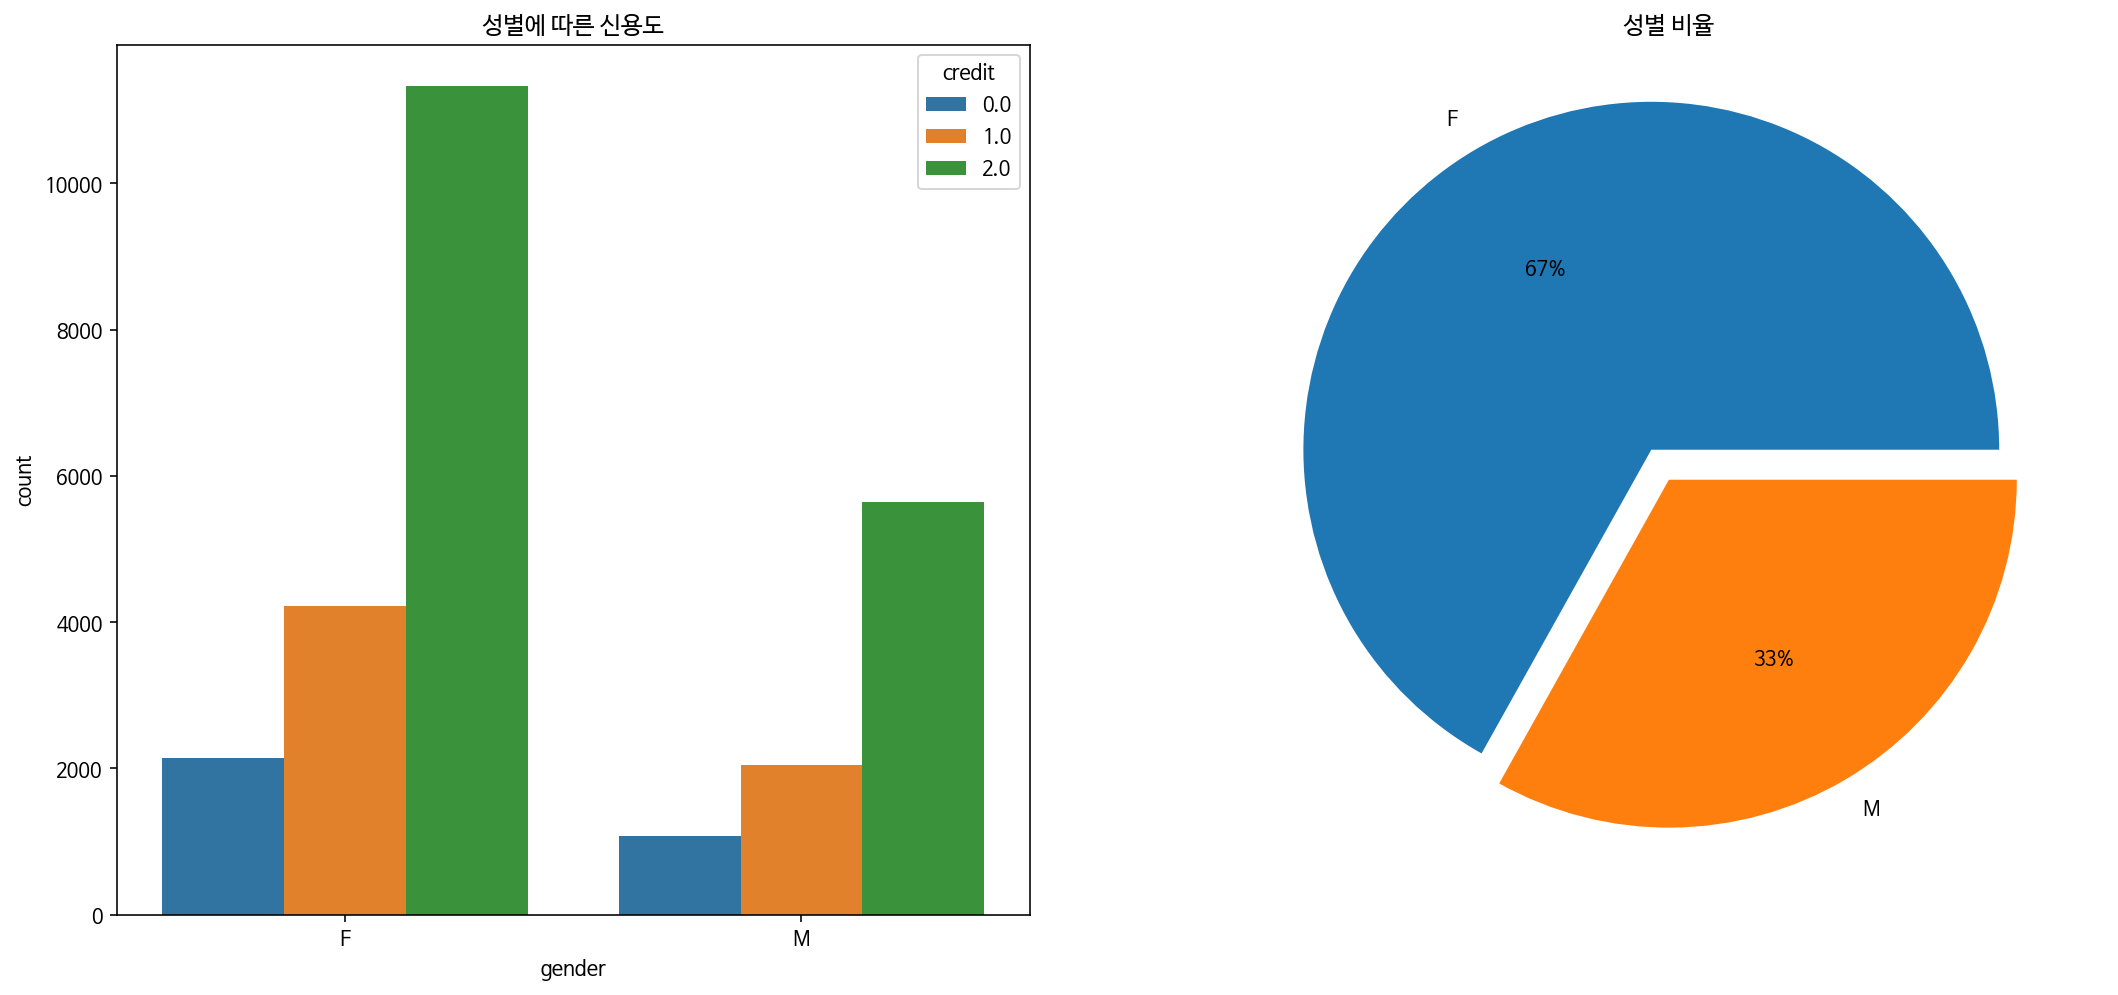

In [9]:
###성별 
gender_for_pie = train.groupby('gender').count()['index']

f,ax=plt.subplots(1,2,figsize=(18,8))
plt.pie(gender_for_pie, labels = gender_for_pie.index,explode = (0.1,0), autopct = '%1.f%%')
ax[0].set_title('성별에 따른 신용도')
sns.countplot('gender',hue='credit',data=train,ax=ax[0])
ax[1].set_title('성별 비율')
plt.show()

In [10]:
pd.crosstab(train.gender,train.credit,margins=True).style.background_gradient(cmap='summer_r')

credit,0.0,1.0,2.0,All
gender,,,,
F,2148,4220,11329,17697
M,1074,2047,5639,8760
All,3222,6267,16968,26457


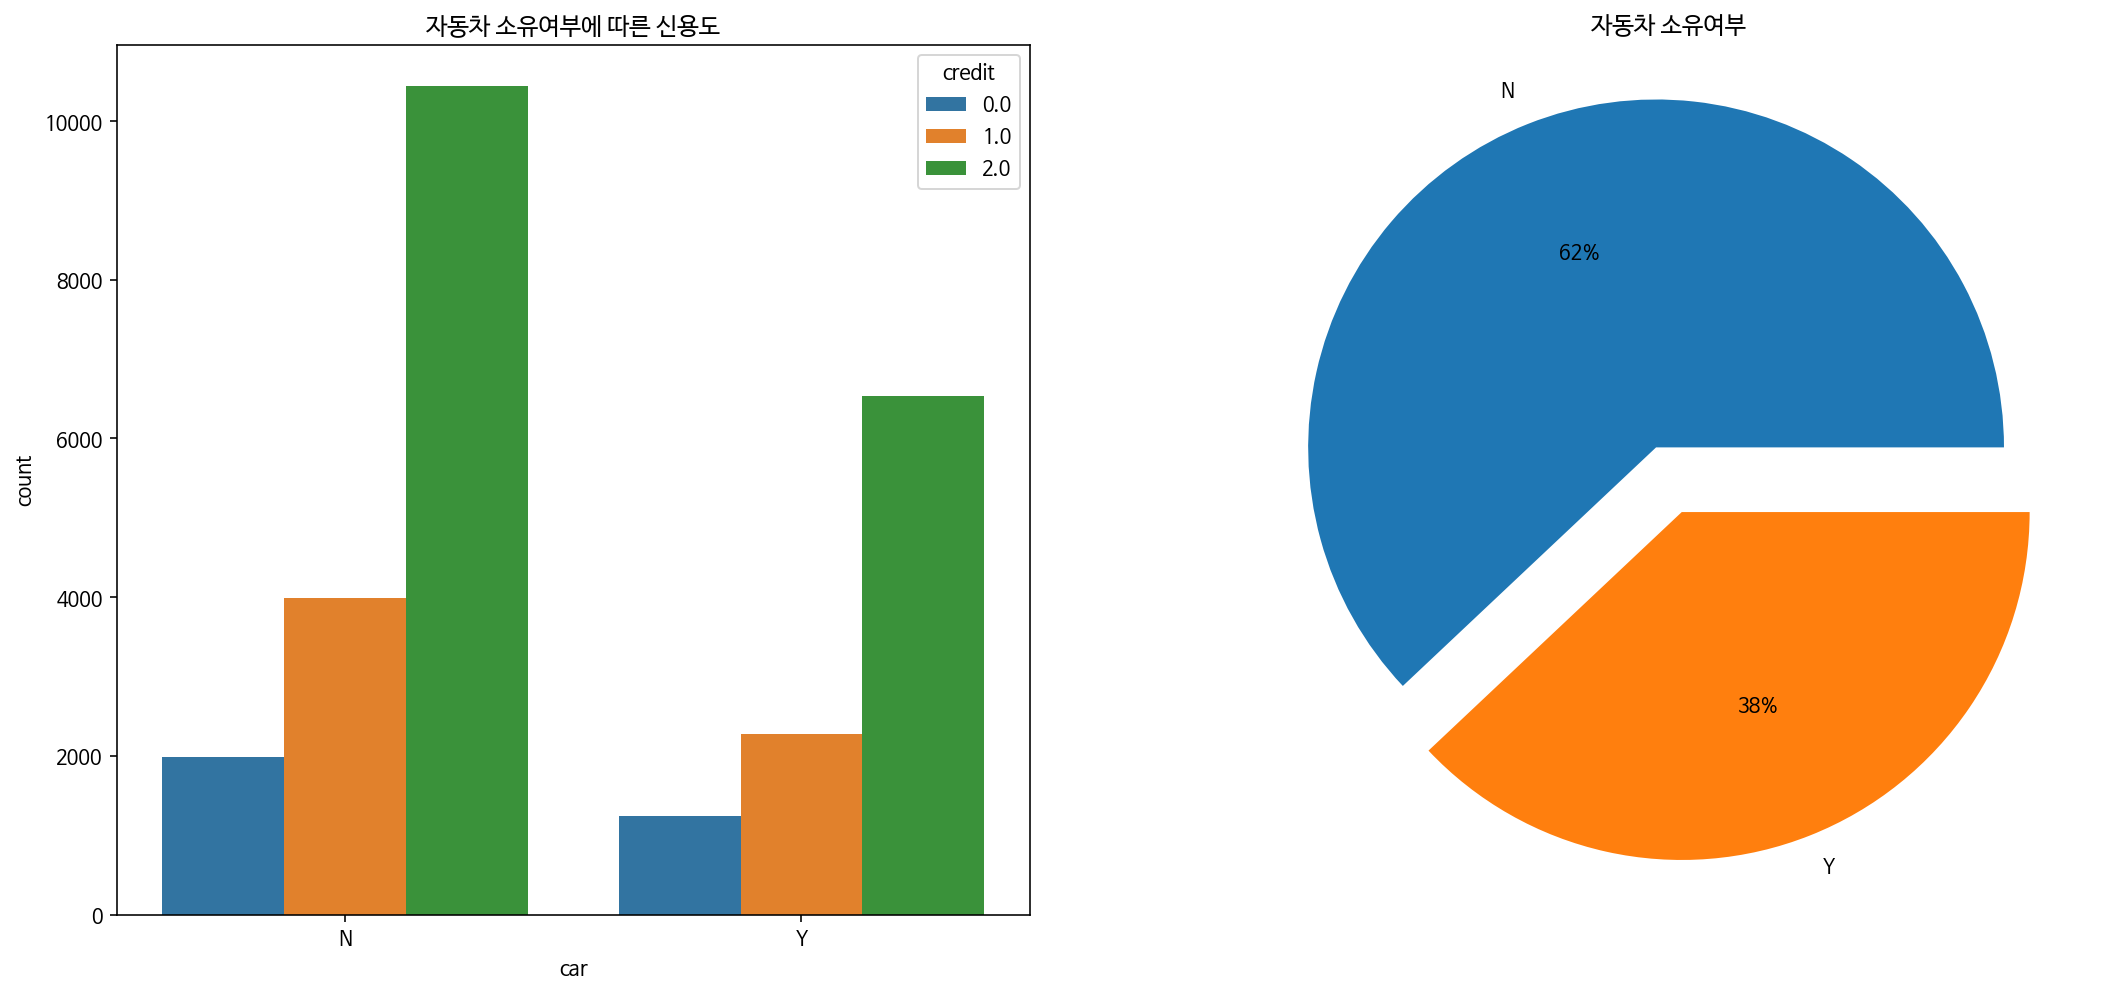

In [11]:
###차량 
car_for_pie = train.groupby('car').count()['index']

f,ax=plt.subplots(1,2,figsize=(18,8))
plt.pie(car_for_pie, labels = car_for_pie.index, explode = (0.1,0.1), autopct = '%1.f%%')
ax[0].set_title('자동차 소유여부에 따른 신용도')
sns.countplot('car',hue='credit',data=train,ax=ax[0])
ax[1].set_title('자동차 소유여부')
plt.show()

In [12]:
pd.crosstab(train.car,train.credit,margins=True).style.background_gradient(cmap='summer_r')

credit,0.0,1.0,2.0,All
car,,,,
N,1982,3990,10438,16410
Y,1240,2277,6530,10047
All,3222,6267,16968,26457


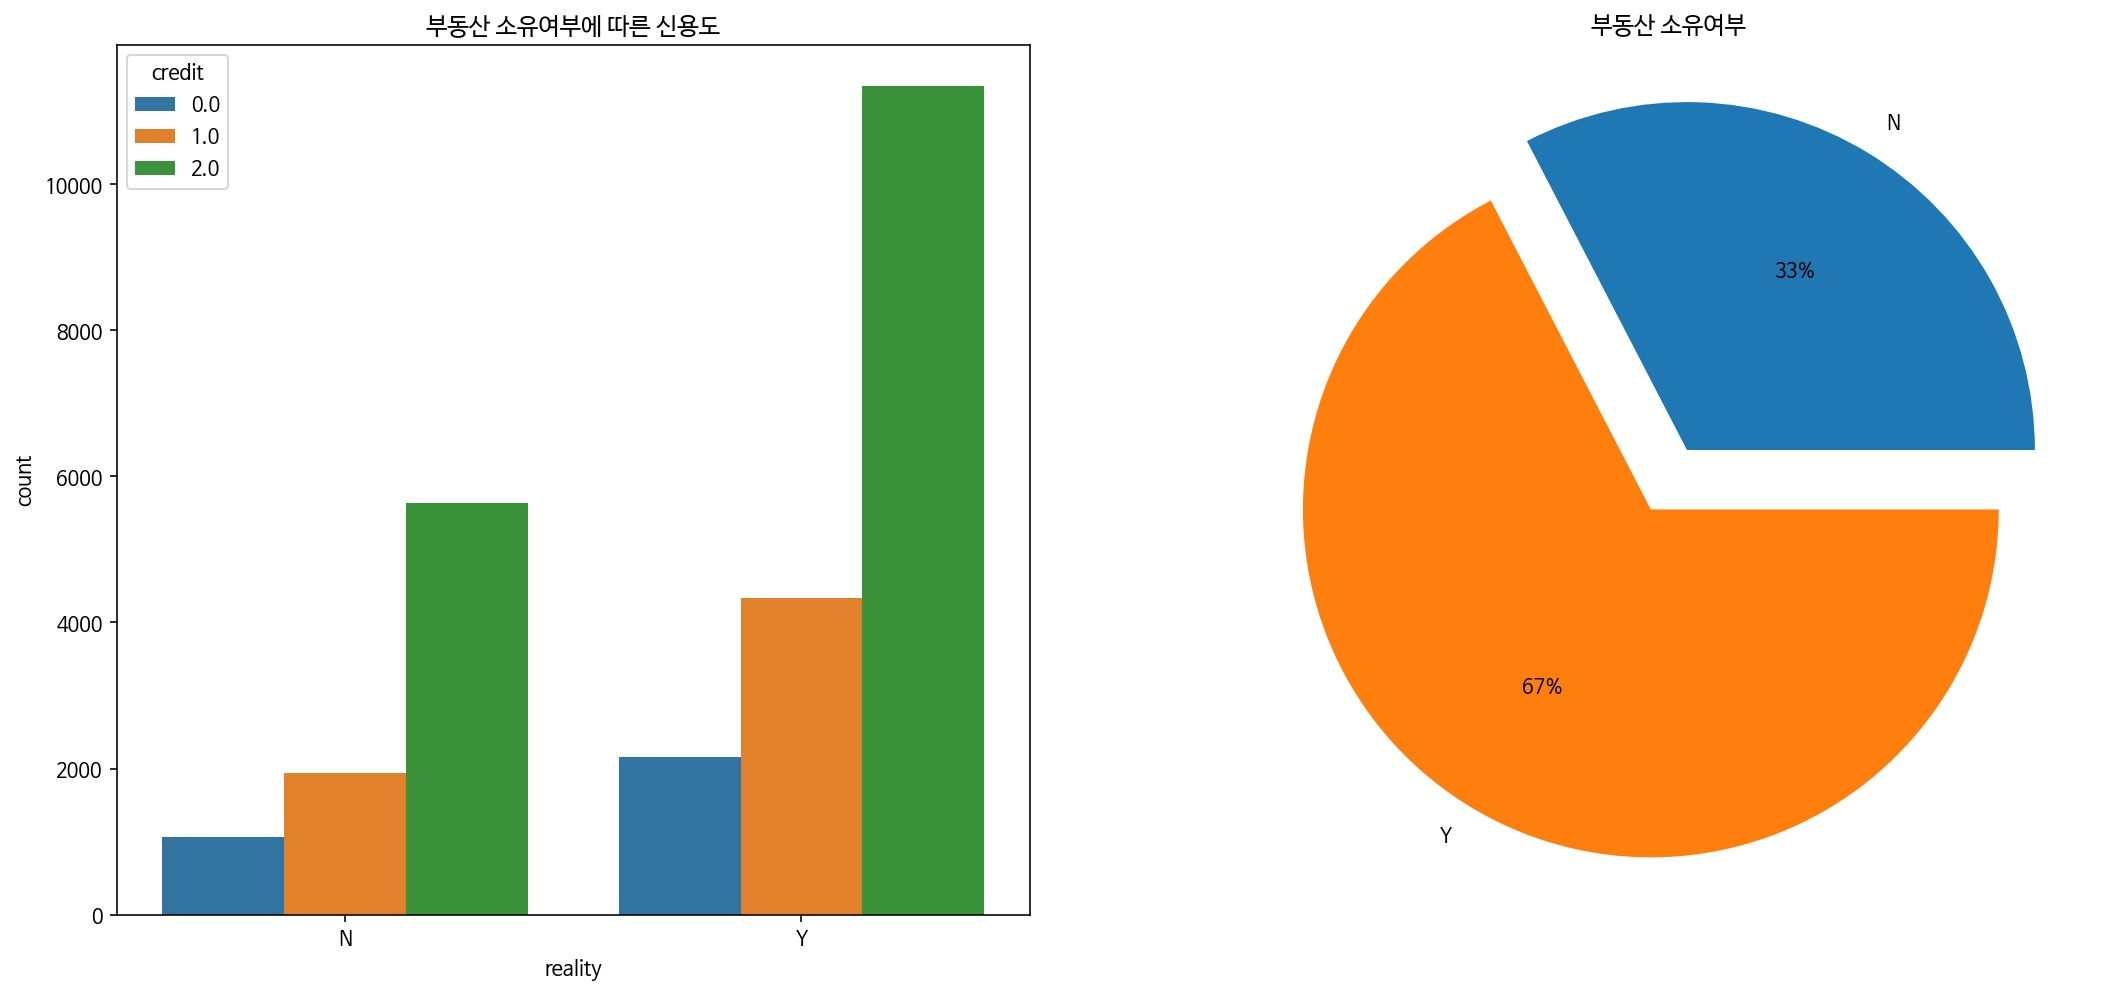

In [13]:
###reality 
reality_for_pie = train.groupby('reality').count()['index']

f,ax=plt.subplots(1,2,figsize=(18,8))
plt.pie(reality_for_pie, labels = reality_for_pie.index, explode = (0.1,0.1), autopct = '%1.f%%')
ax[0].set_title('부동산 소유여부에 따른 신용도')
sns.countplot('reality',hue='credit',data=train,ax=ax[0])
ax[1].set_title('부동산 소유여부')
plt.show()

In [14]:
pd.crosstab(train.reality,train.credit,margins=True).style.background_gradient(cmap='summer_r')

credit,0.0,1.0,2.0,All
reality,,,,
N,1064,1935,5628,8627
Y,2158,4332,11340,17830
All,3222,6267,16968,26457


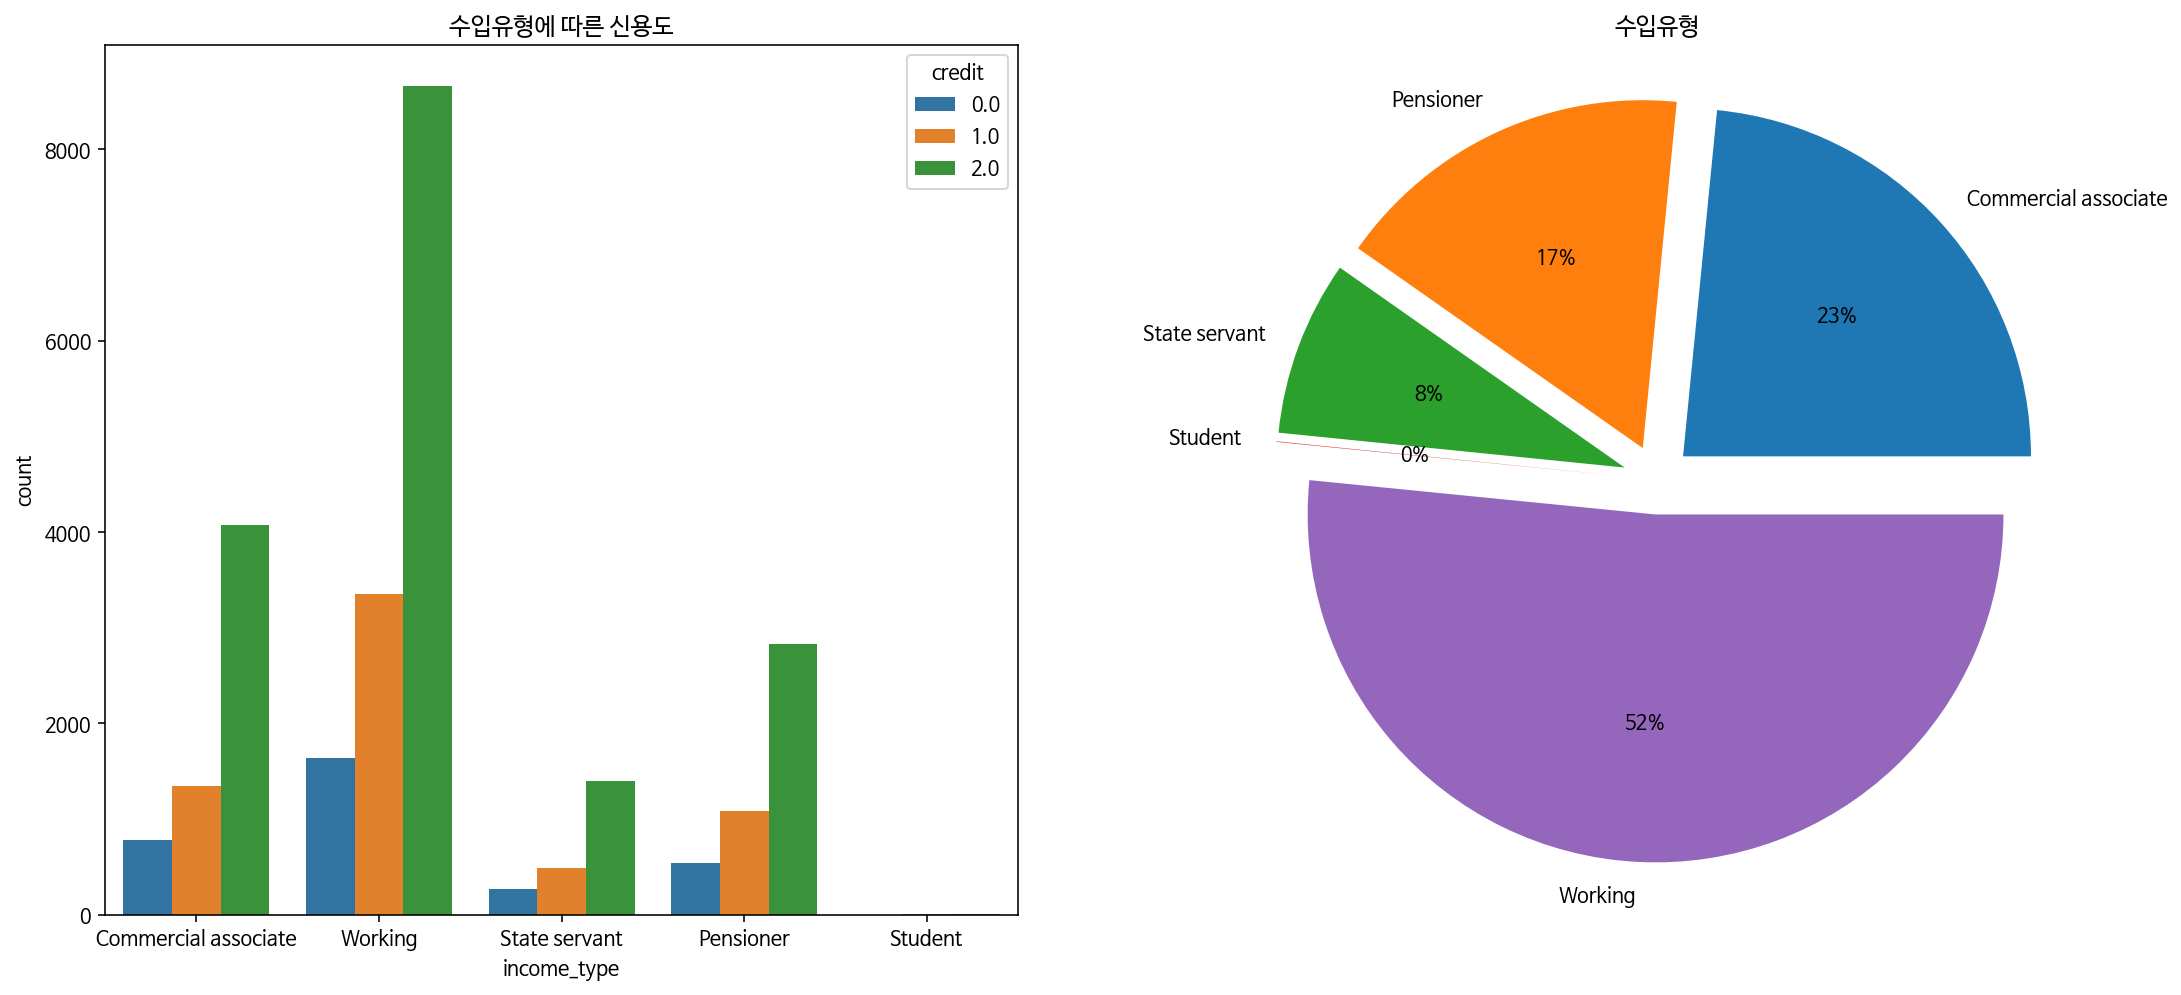

In [15]:
###income_type 
income_type_for_pie = train.groupby('income_type').count()['index']

f,ax=plt.subplots(1,2,figsize=(18,8))
plt.pie(income_type_for_pie, labels = income_type_for_pie.index, explode = (0.1,0.1,0.1,0.1,0.1), autopct = '%1.f%%')
ax[0].set_title('수입유형에 따른 신용도')
sns.countplot('income_type',hue='credit',data=train,ax=ax[0])
ax[1].set_title('수입유형')
plt.show()

In [16]:
pd.crosstab(train.income_type,train.credit,margins=True).style.background_gradient(cmap='summer_r')

credit,0.0,1.0,2.0,All
income_type,,,,
Commercial associate,782,1344,4076,6202
Pensioner,536,1084,2829,4449
State servant,265,489,1400,2154
Student,0,3,4,7
Working,1639,3347,8659,13645
All,3222,6267,16968,26457


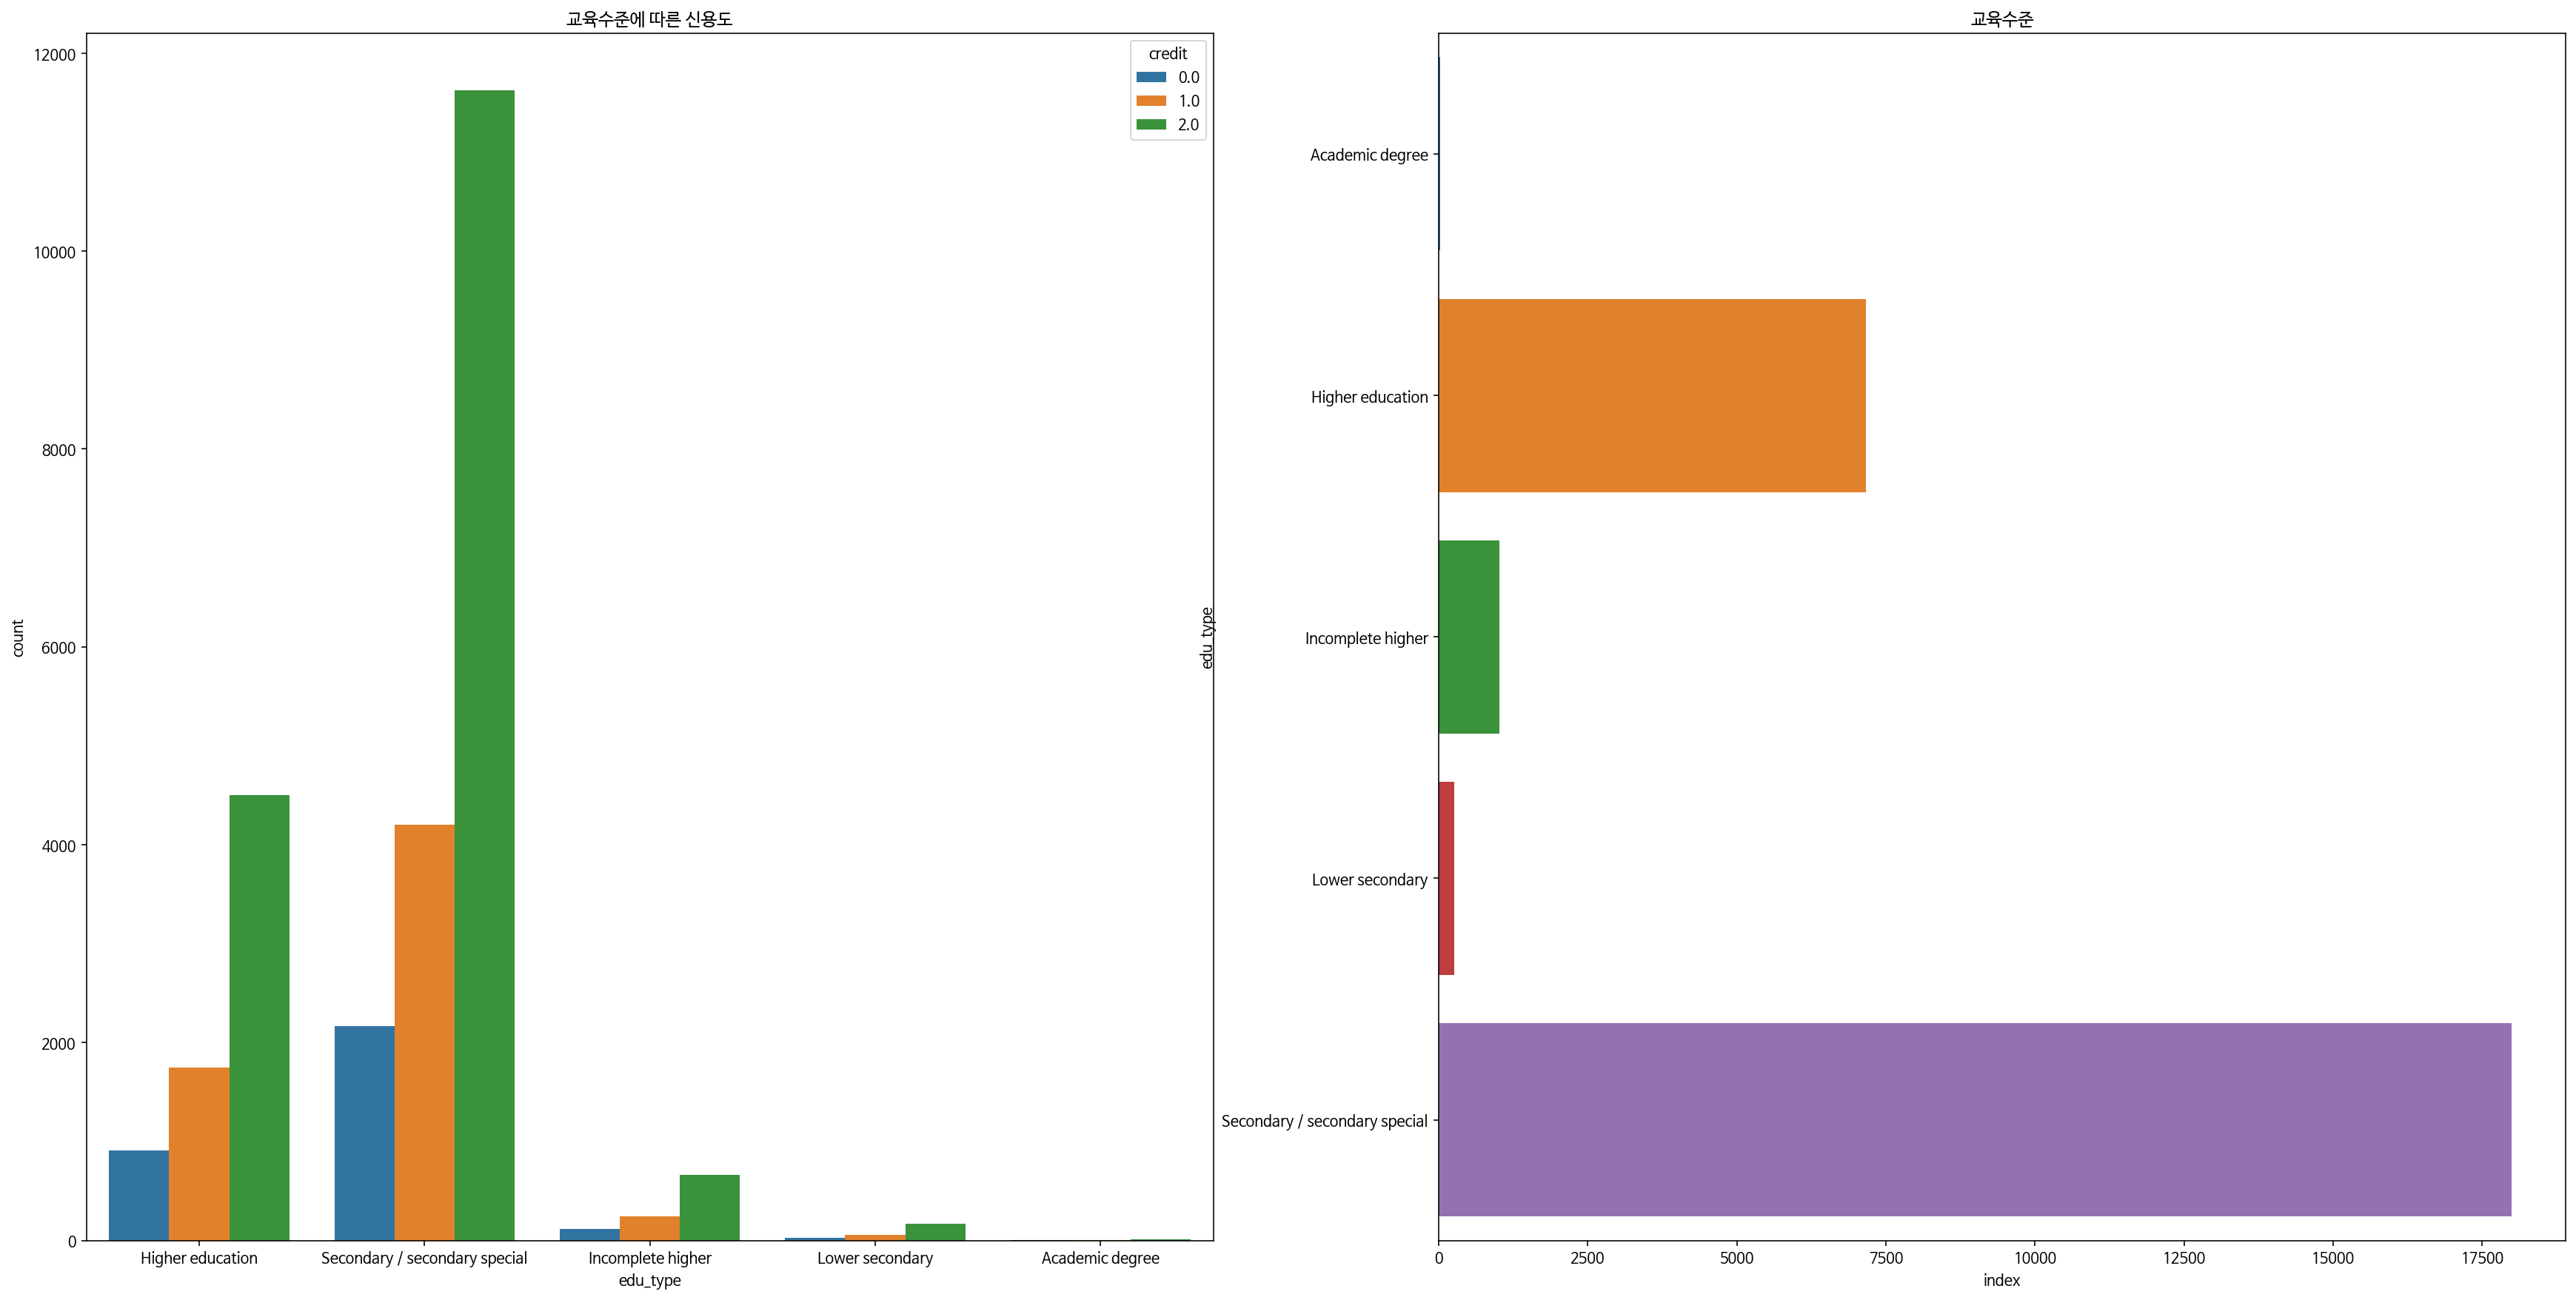

In [17]:
###edu_type 
edu_type_for_bar = train.groupby('edu_type').count()['index'].reset_index()

f,ax=plt.subplots(1,2,figsize=(30,15))
sns.barplot(data=edu_type_for_bar, x = 'index',y = 'edu_type')
ax[0].set_title('교육수준에 따른 신용도')
sns.countplot('edu_type',hue='credit',data=train,ax=ax[0])
ax[1].set_title('교육수준')
plt.show()

In [18]:
pd.crosstab(train.edu_type,train.credit,margins=True).style.background_gradient(cmap='summer_r')

credit,0.0,1.0,2.0,All
edu_type,,,,
Academic degree,2,7,14,23
Higher education,909,1751,4502,7162
Incomplete higher,114,246,660,1020
Lower secondary,28,59,170,257
Secondary / secondary special,2169,4204,11622,17995
All,3222,6267,16968,26457


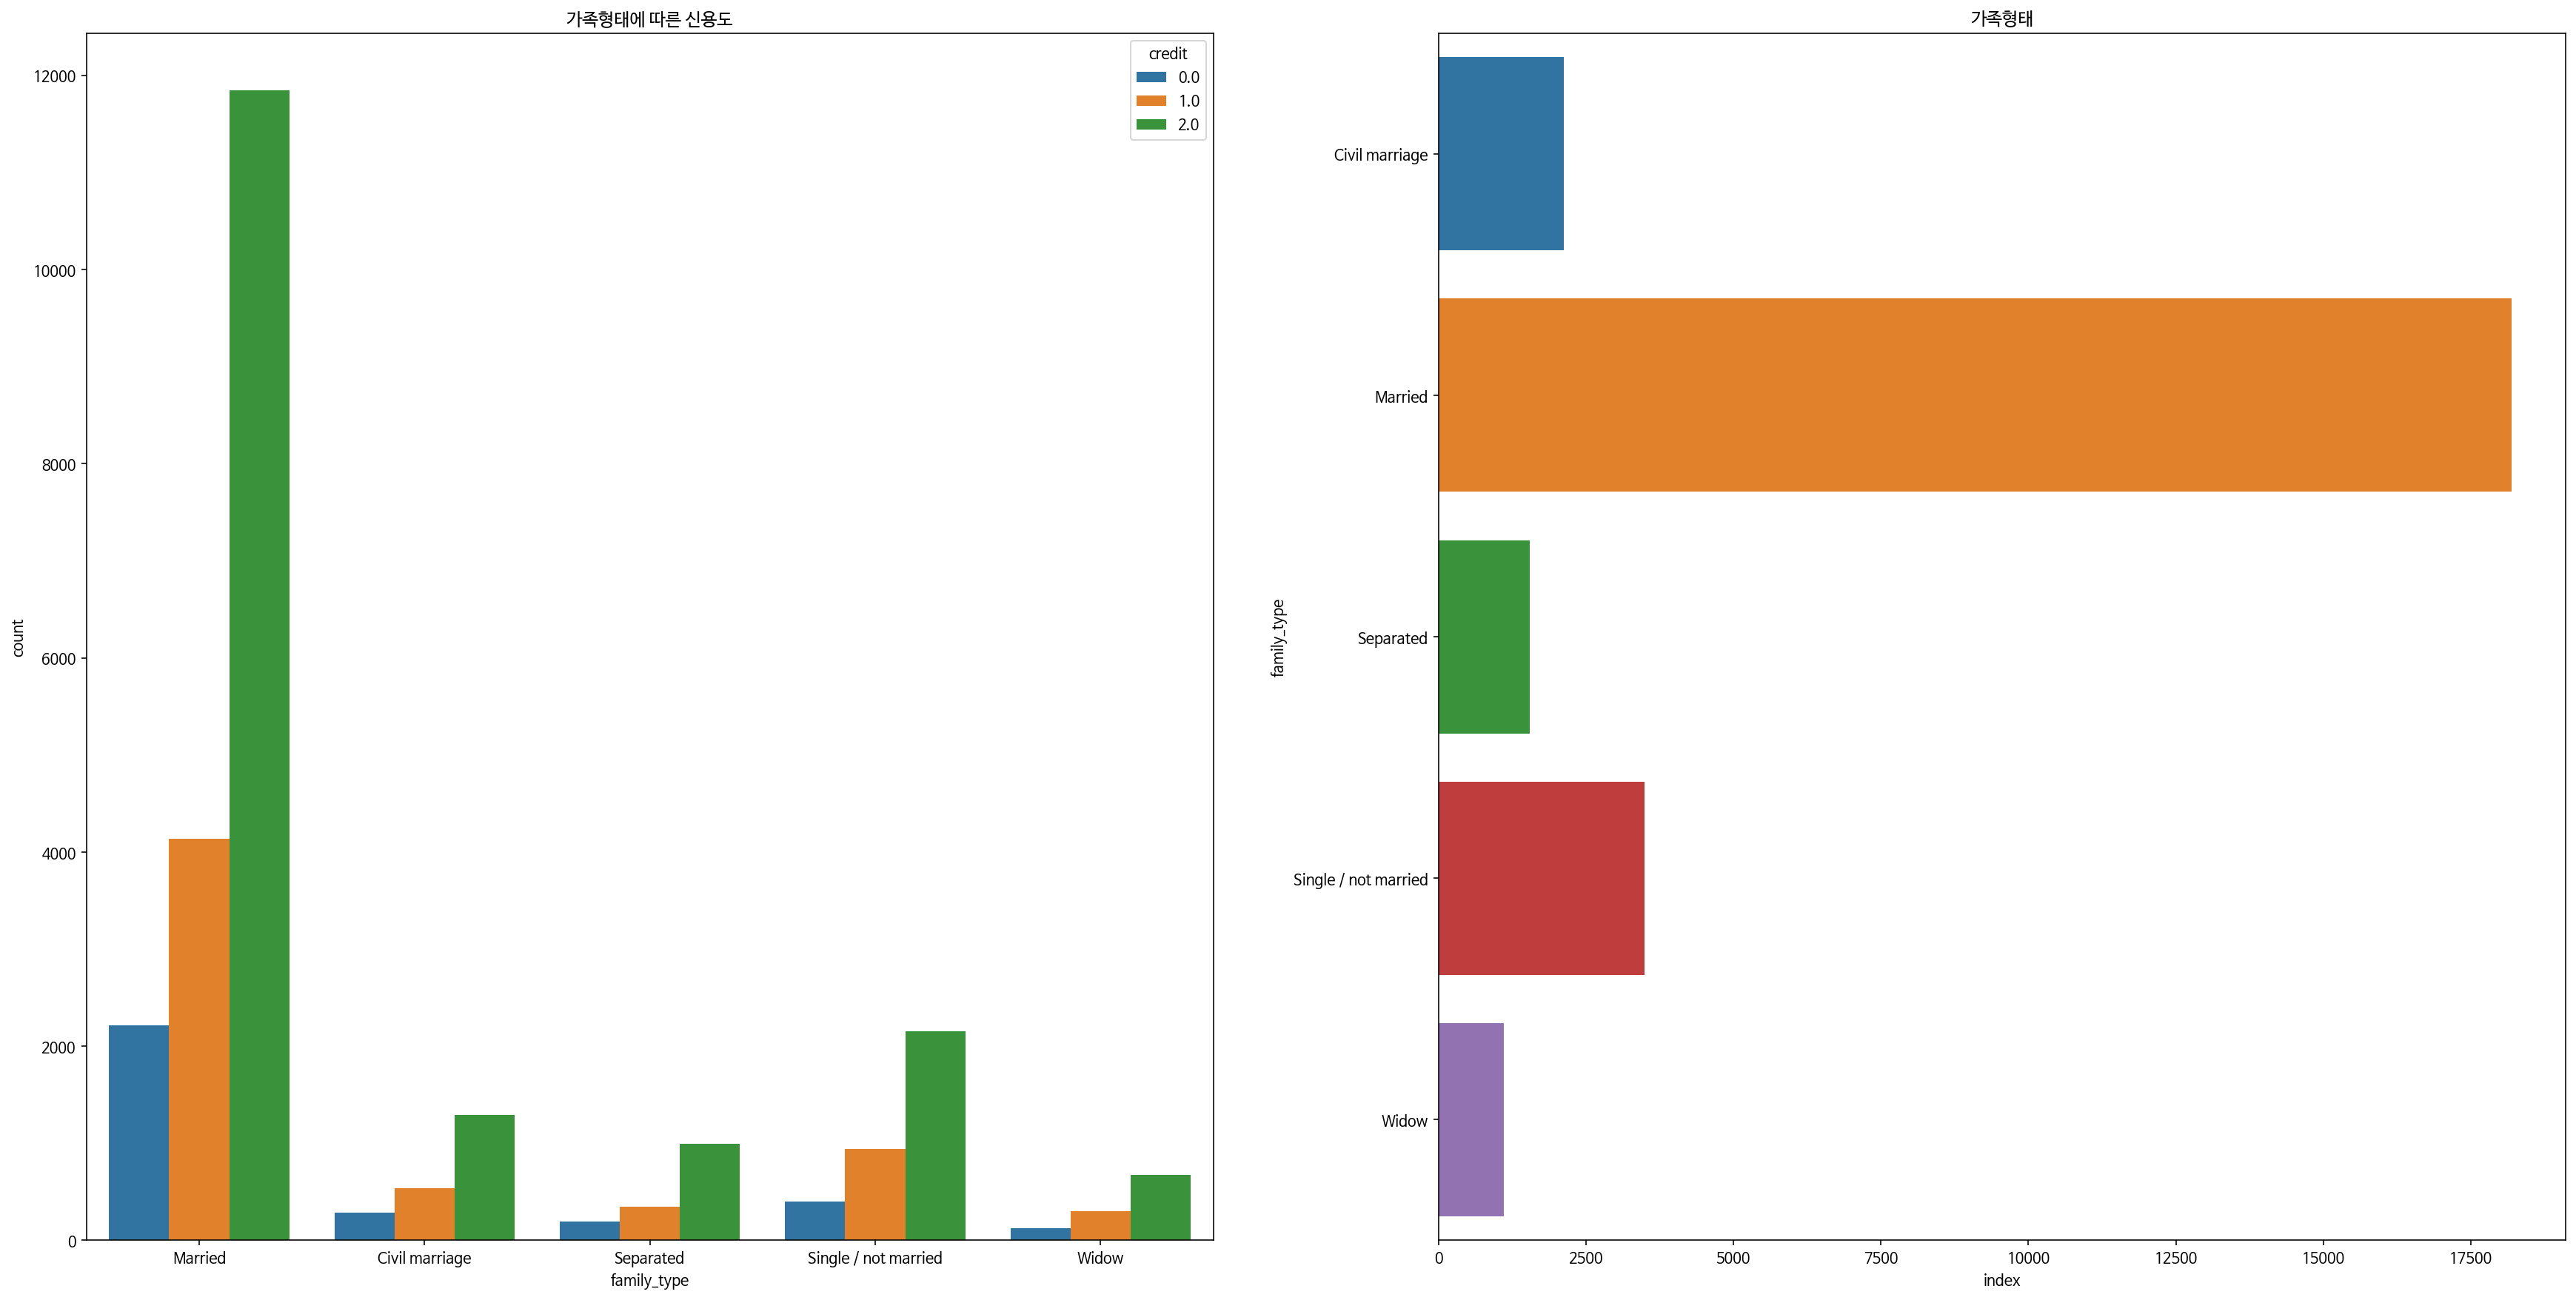

In [19]:
###family_type 
family_type_for_bar = train.groupby('family_type').count()['index'].reset_index()

f,ax=plt.subplots(1,2,figsize=(30,15))
sns.barplot(data=family_type_for_bar, x = 'index',y = 'family_type')
ax[0].set_title('가족형태에 따른 신용도')
sns.countplot('family_type',hue='credit',data=train,ax=ax[0])
ax[1].set_title('가족형태')
plt.show()

In [20]:
pd.crosstab(train.family_type,train.credit,margins=True).style.background_gradient(cmap='summer_r')

credit,0.0,1.0,2.0,All
family_type,,,,
Civil marriage,288,539,1296,2123
Married,2213,4140,11843,18196
Separated,193,349,997,1539
Single / not married,402,940,2154,3496
Widow,126,299,678,1103
All,3222,6267,16968,26457


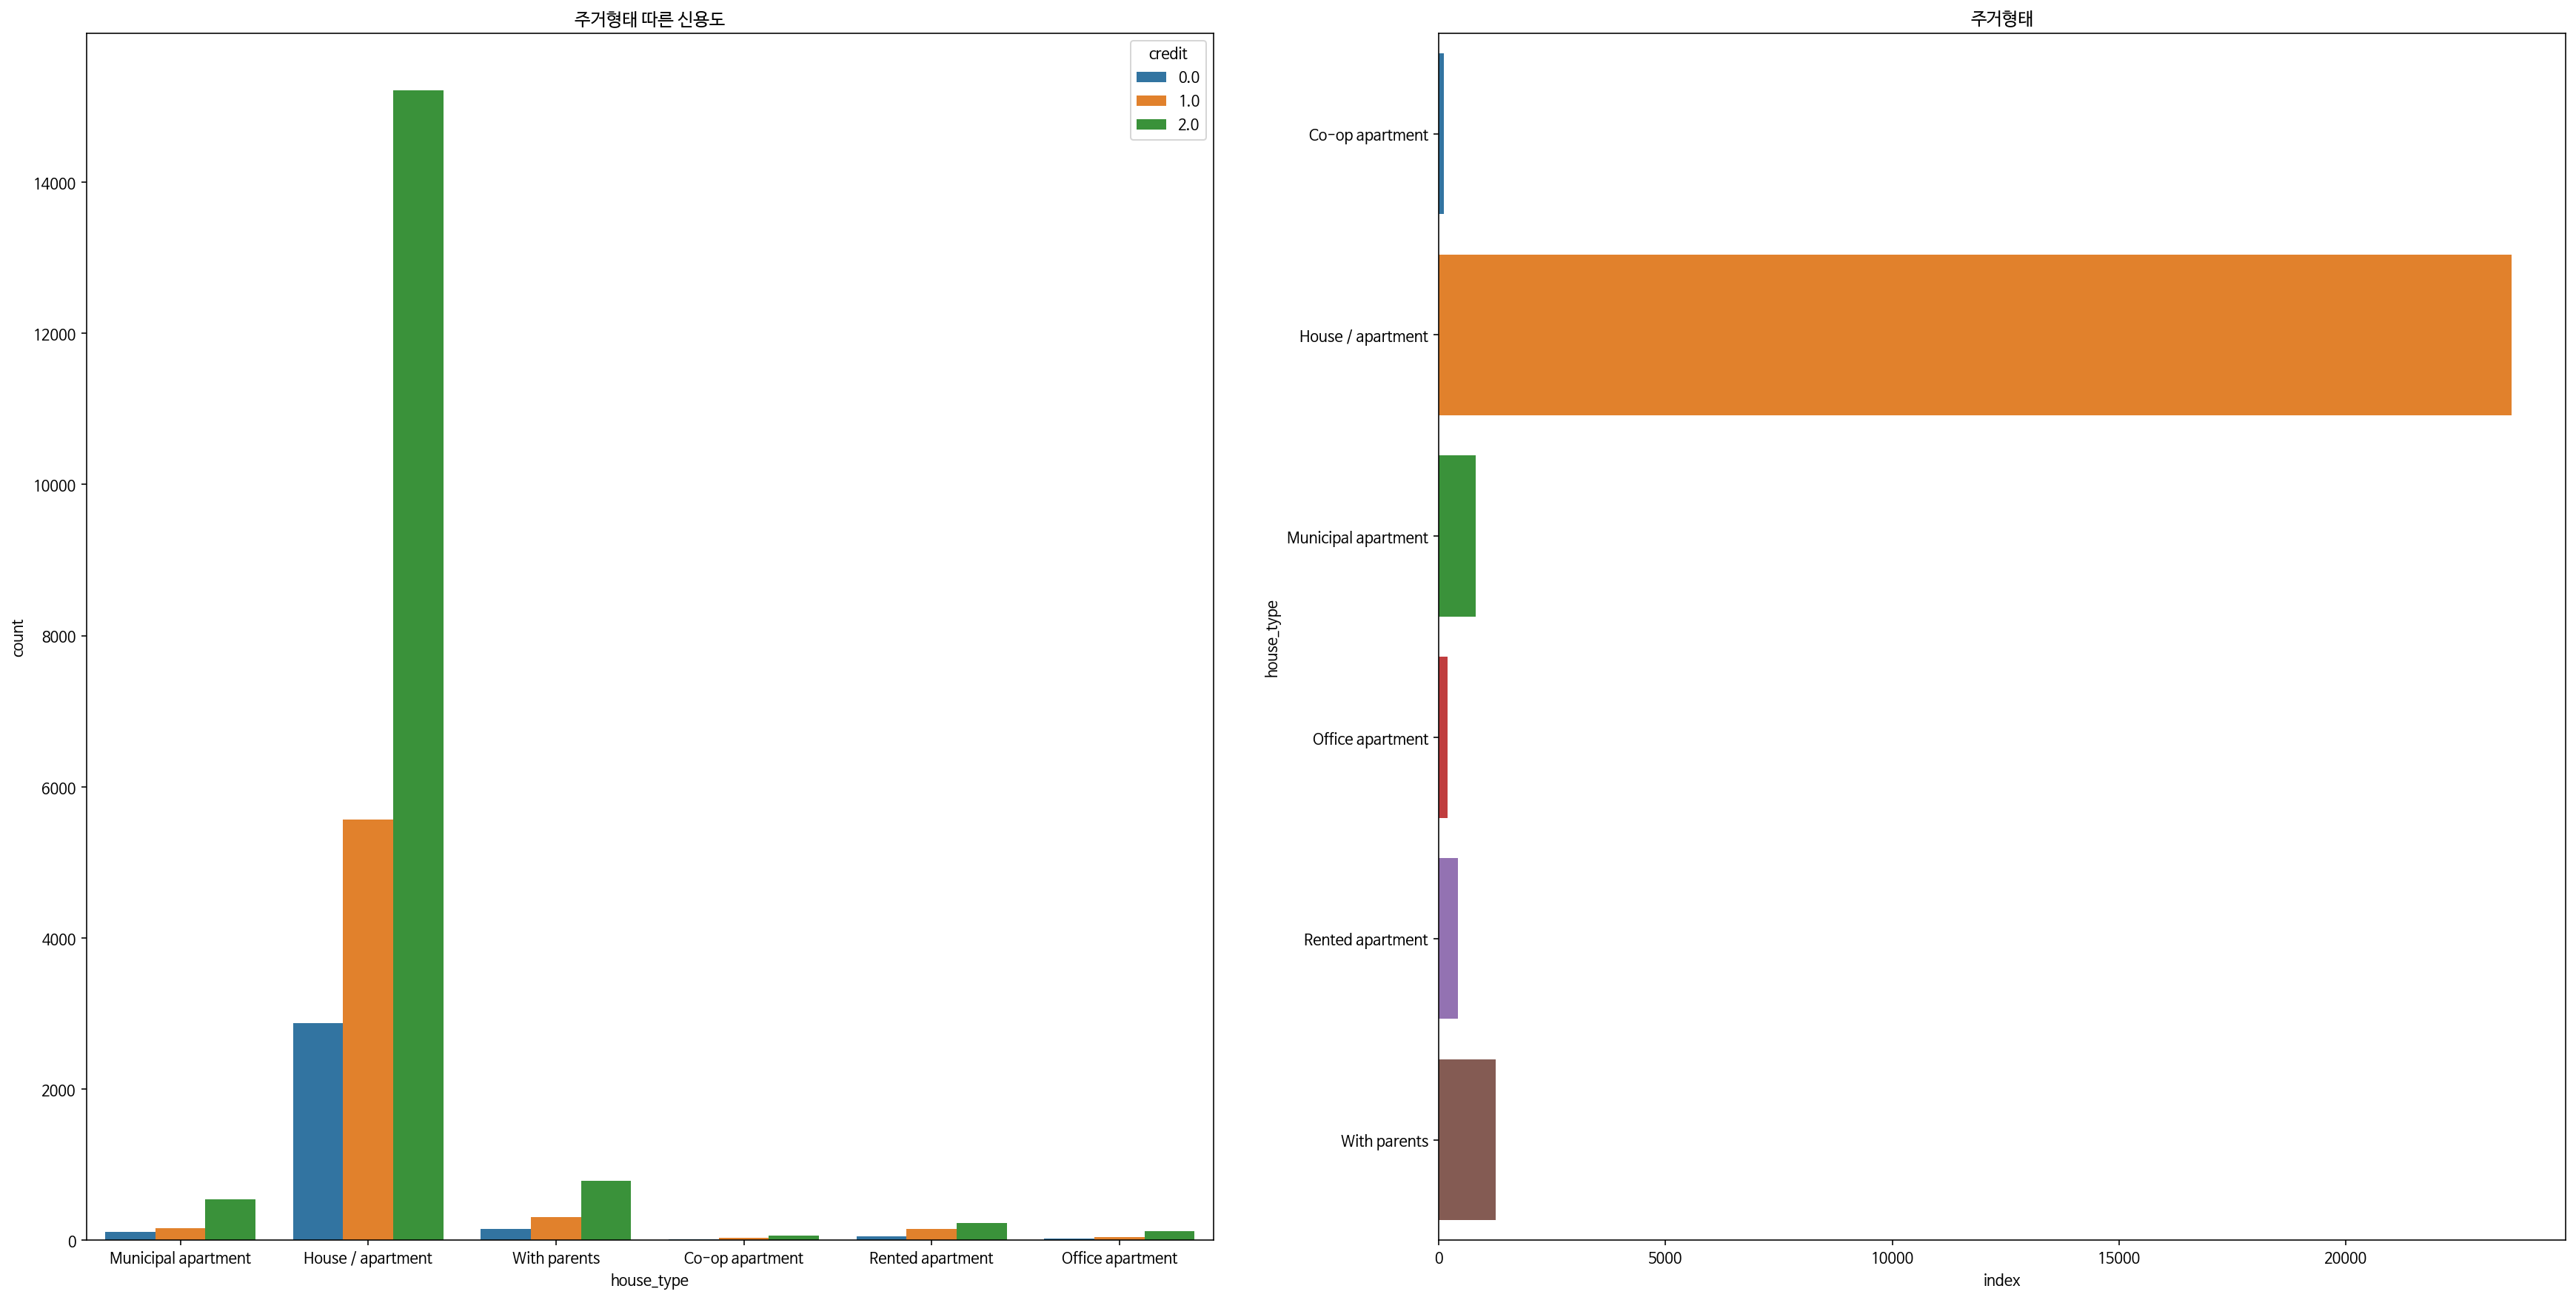

In [21]:
###house_type 
house_type_for_bar = train.groupby('house_type').count()['index'].reset_index()

f,ax=plt.subplots(1,2,figsize=(30,15))
sns.barplot(data=house_type_for_bar, x = 'index',y = 'house_type')
ax[0].set_title('주거형태 따른 신용도')
sns.countplot('house_type',hue='credit',data=train,ax=ax[0])
ax[1].set_title('주거형태')
plt.show()

In [22]:
pd.crosstab(train.house_type,train.credit,margins=True).style.background_gradient(cmap='summer_r')

credit,0.0,1.0,2.0,All
house_type,,,,
Co-op apartment,14,30,66,110
House / apartment,2873,5569,15211,23653
Municipal apartment,110,160,548,818
Office apartment,24,48,118,190
Rented apartment,50,147,232,429
With parents,151,313,793,1257
All,3222,6267,16968,26457


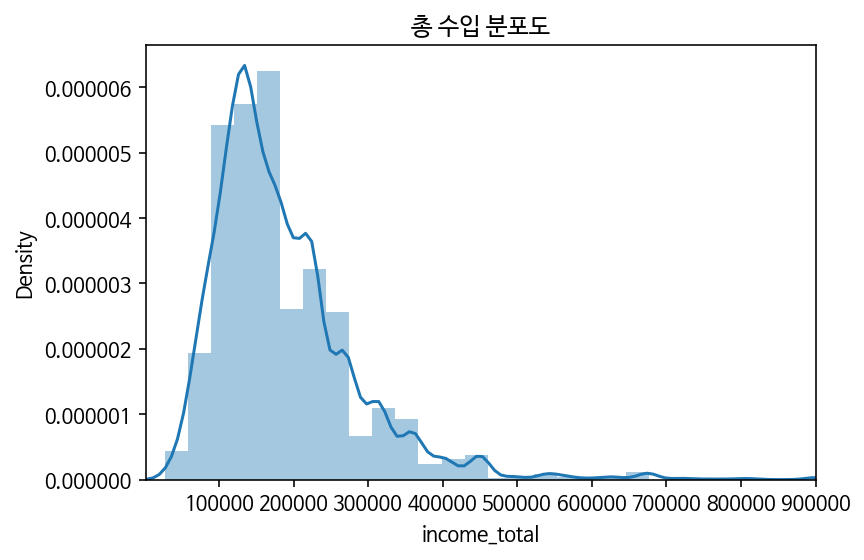

In [23]:
###income_total 

#income_total_=train.groupby('income_total')['index'].count().reset_index()

sns.distplot(train.income_total)
plt.xlim(2000,900000)
plt.title('총 수입 분포도')
plt.show()

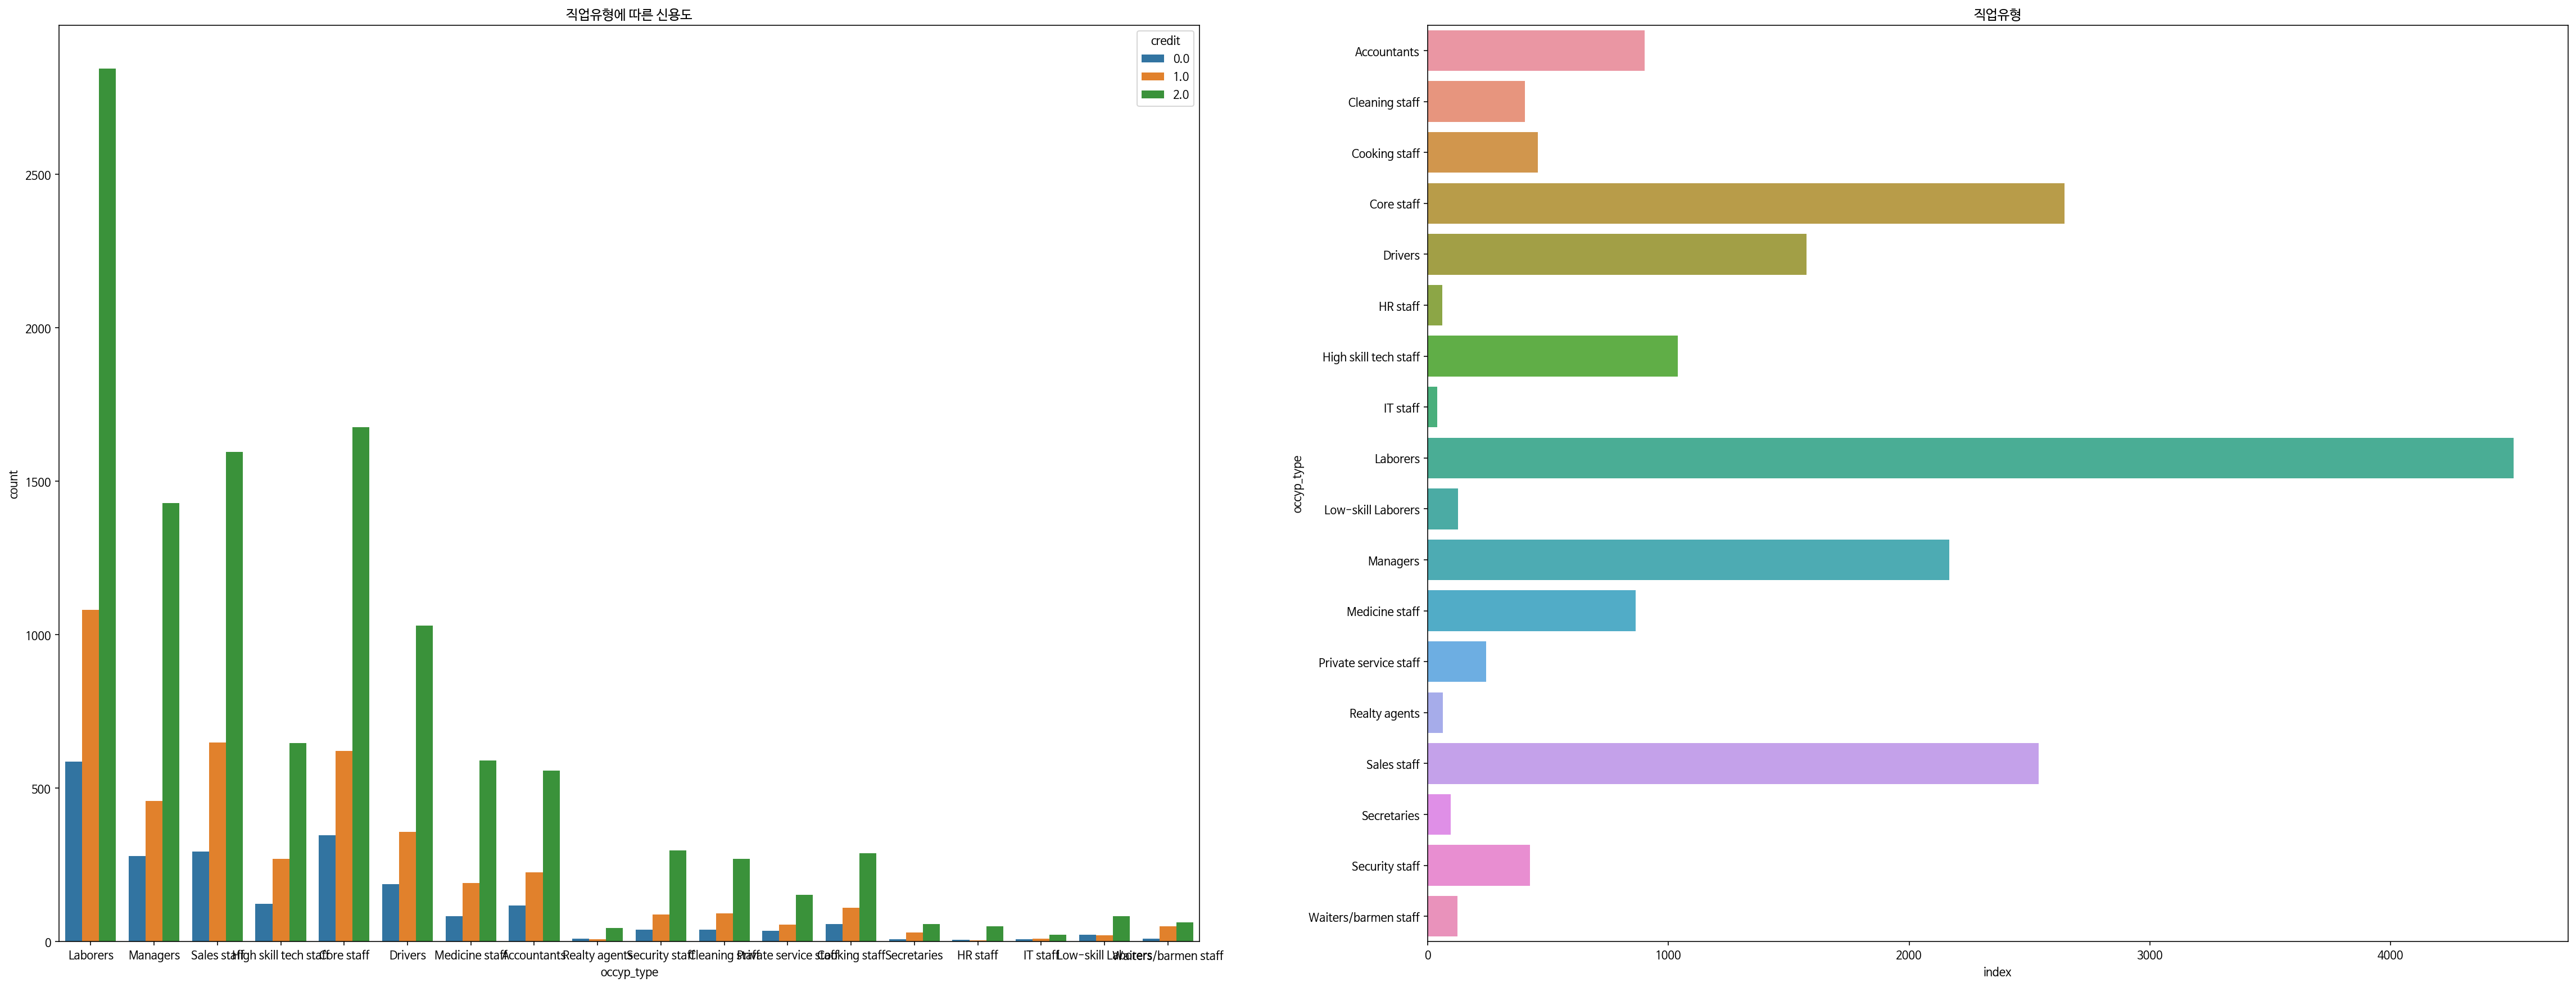

In [24]:
###occyp_type
occyp_type_for_bar = train.groupby('occyp_type').count()['index'].reset_index()

f,ax=plt.subplots(1,2,figsize=(40,15))
sns.barplot(data=occyp_type_for_bar, x = 'index',y = 'occyp_type')
ax[0].set_title('직업유형에 따른 신용도')
sns.countplot('occyp_type',hue='credit',data=train,ax=ax[0])
ax[1].set_title('직업유형')
plt.show()

In [25]:
pd.crosstab(train.occyp_type,train.credit,margins=True).style.background_gradient(cmap='summer_r')

credit,0.0,1.0,2.0,All
occyp_type,,,,
Accountants,118,227,557,902
Cleaning staff,40,93,270,403
Cooking staff,58,110,289,457
Core staff,347,622,1677,2646
Drivers,187,358,1030,1575
HR staff,7,4,51,62
High skill tech staff,123,270,647,1040
IT staff,8,10,23,41
Laborers,586,1082,2844,4512


In [26]:
###flag_mobil

train.groupby('FLAG_MOBIL')['index'].count().reset_index()

### 다 같은값으로 무의미한 데이터라고 생각해서 전처리 과정에서 삭제예정

,FLAG_MOBIL,index
0,1,26457


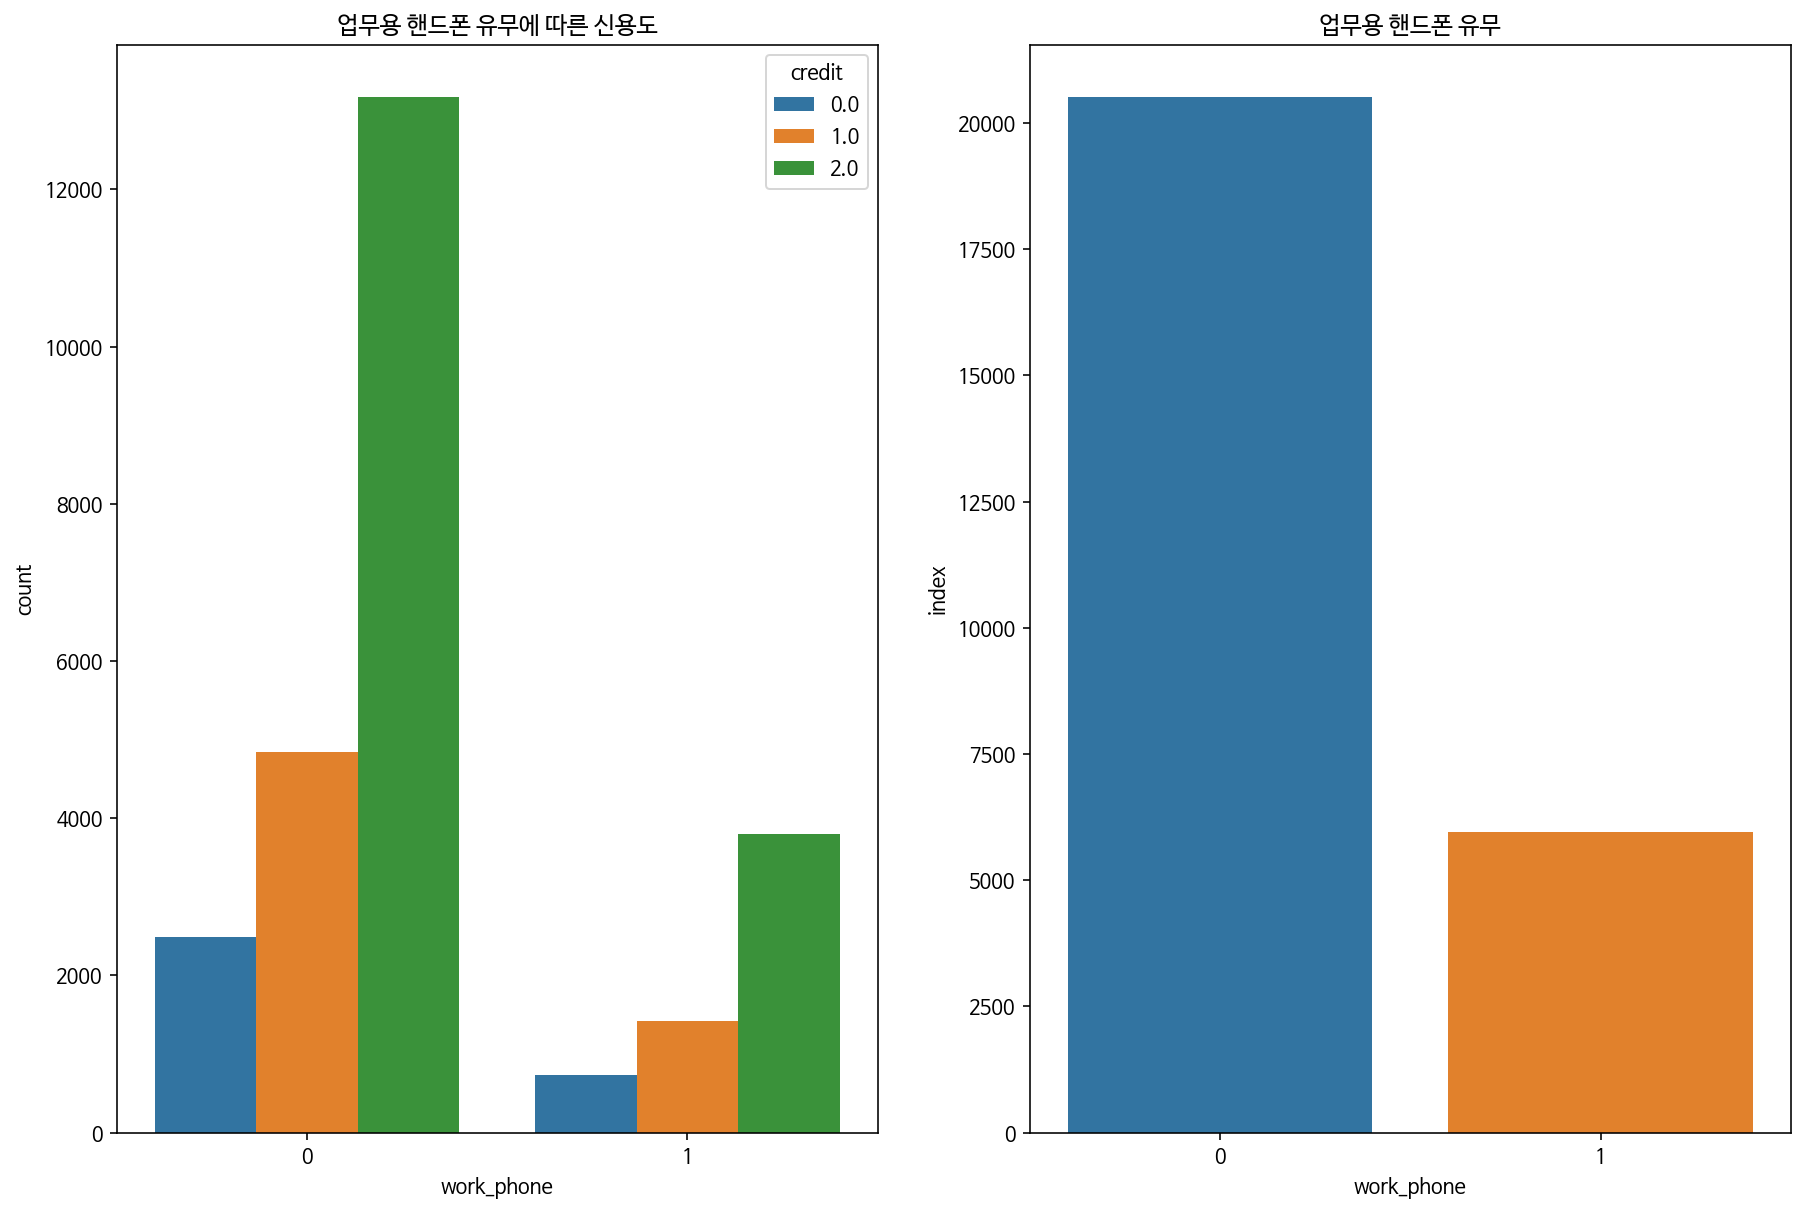

In [27]:
###work_phone
work_phone_bar=train.groupby('work_phone')['index'].count().reset_index()

f,ax=plt.subplots(1,2,figsize=(15,10))
sns.barplot(data=work_phone_bar, y = 'index',x = 'work_phone')
ax[0].set_title('업무용 핸드폰 유무에 따른 신용도')
sns.countplot('work_phone',hue='credit',data=train,ax=ax[0])
ax[1].set_title('업무용 핸드폰 유무')
plt.show()

In [28]:
pd.crosstab(train.work_phone,train.credit,margins=True).style.background_gradient(cmap='summer_r')

credit,0.0,1.0,2.0,All
work_phone,,,,
0,2493,4844,13174,20511
1,729,1423,3794,5946
All,3222,6267,16968,26457


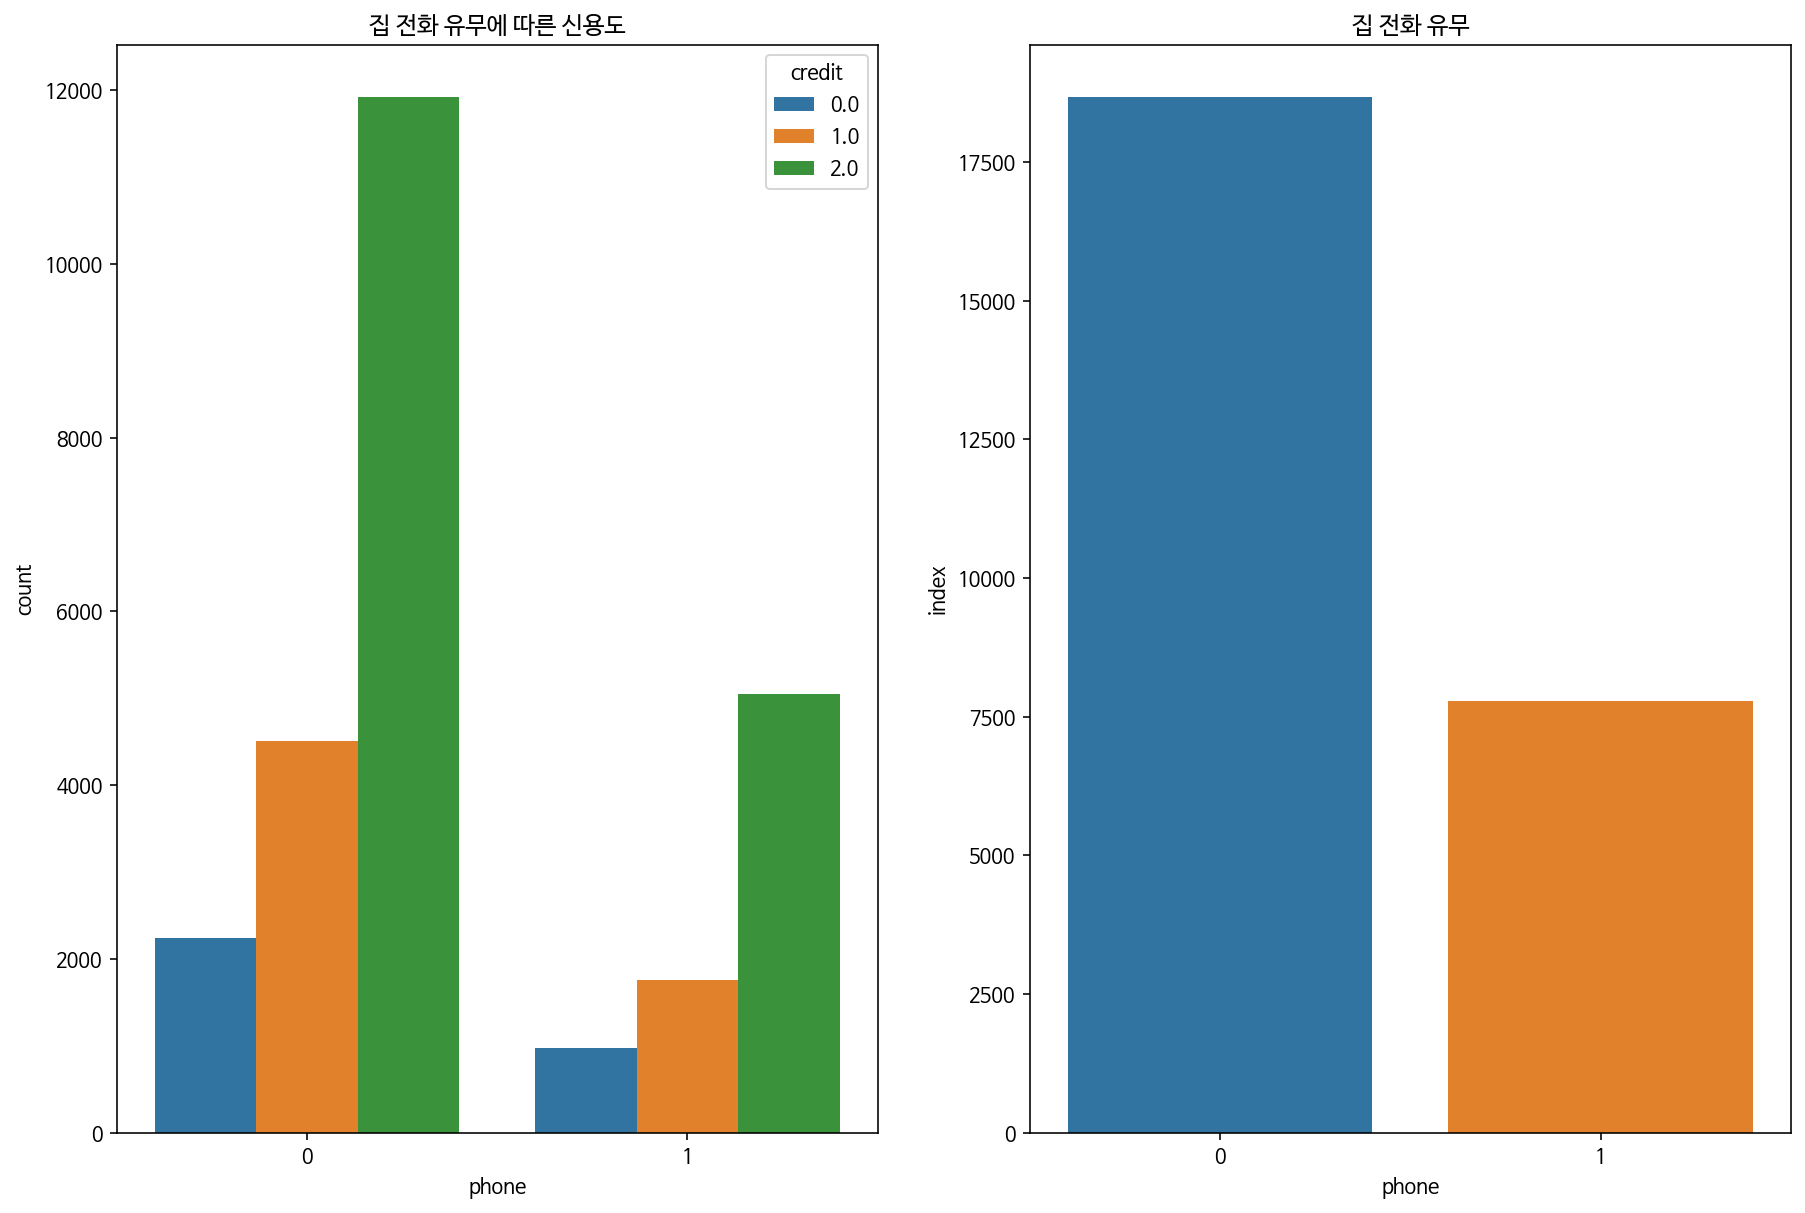

In [29]:
###phone
phone_bar=train.groupby('phone')['index'].count().reset_index()

f,ax=plt.subplots(1,2,figsize=(15,10))
sns.barplot(data=phone_bar, y = 'index',x = 'phone')
ax[0].set_title('집 전화 유무에 따른 신용도')
sns.countplot('phone',hue='credit',data=train,ax=ax[0])
ax[1].set_title('집 전화 유무')
plt.show()

In [30]:
pd.crosstab(train.phone,train.credit,margins=True).style.background_gradient(cmap='summer_r')

credit,0.0,1.0,2.0,All
phone,,,,
0,2245,4510,11917,18672
1,977,1757,5051,7785
All,3222,6267,16968,26457


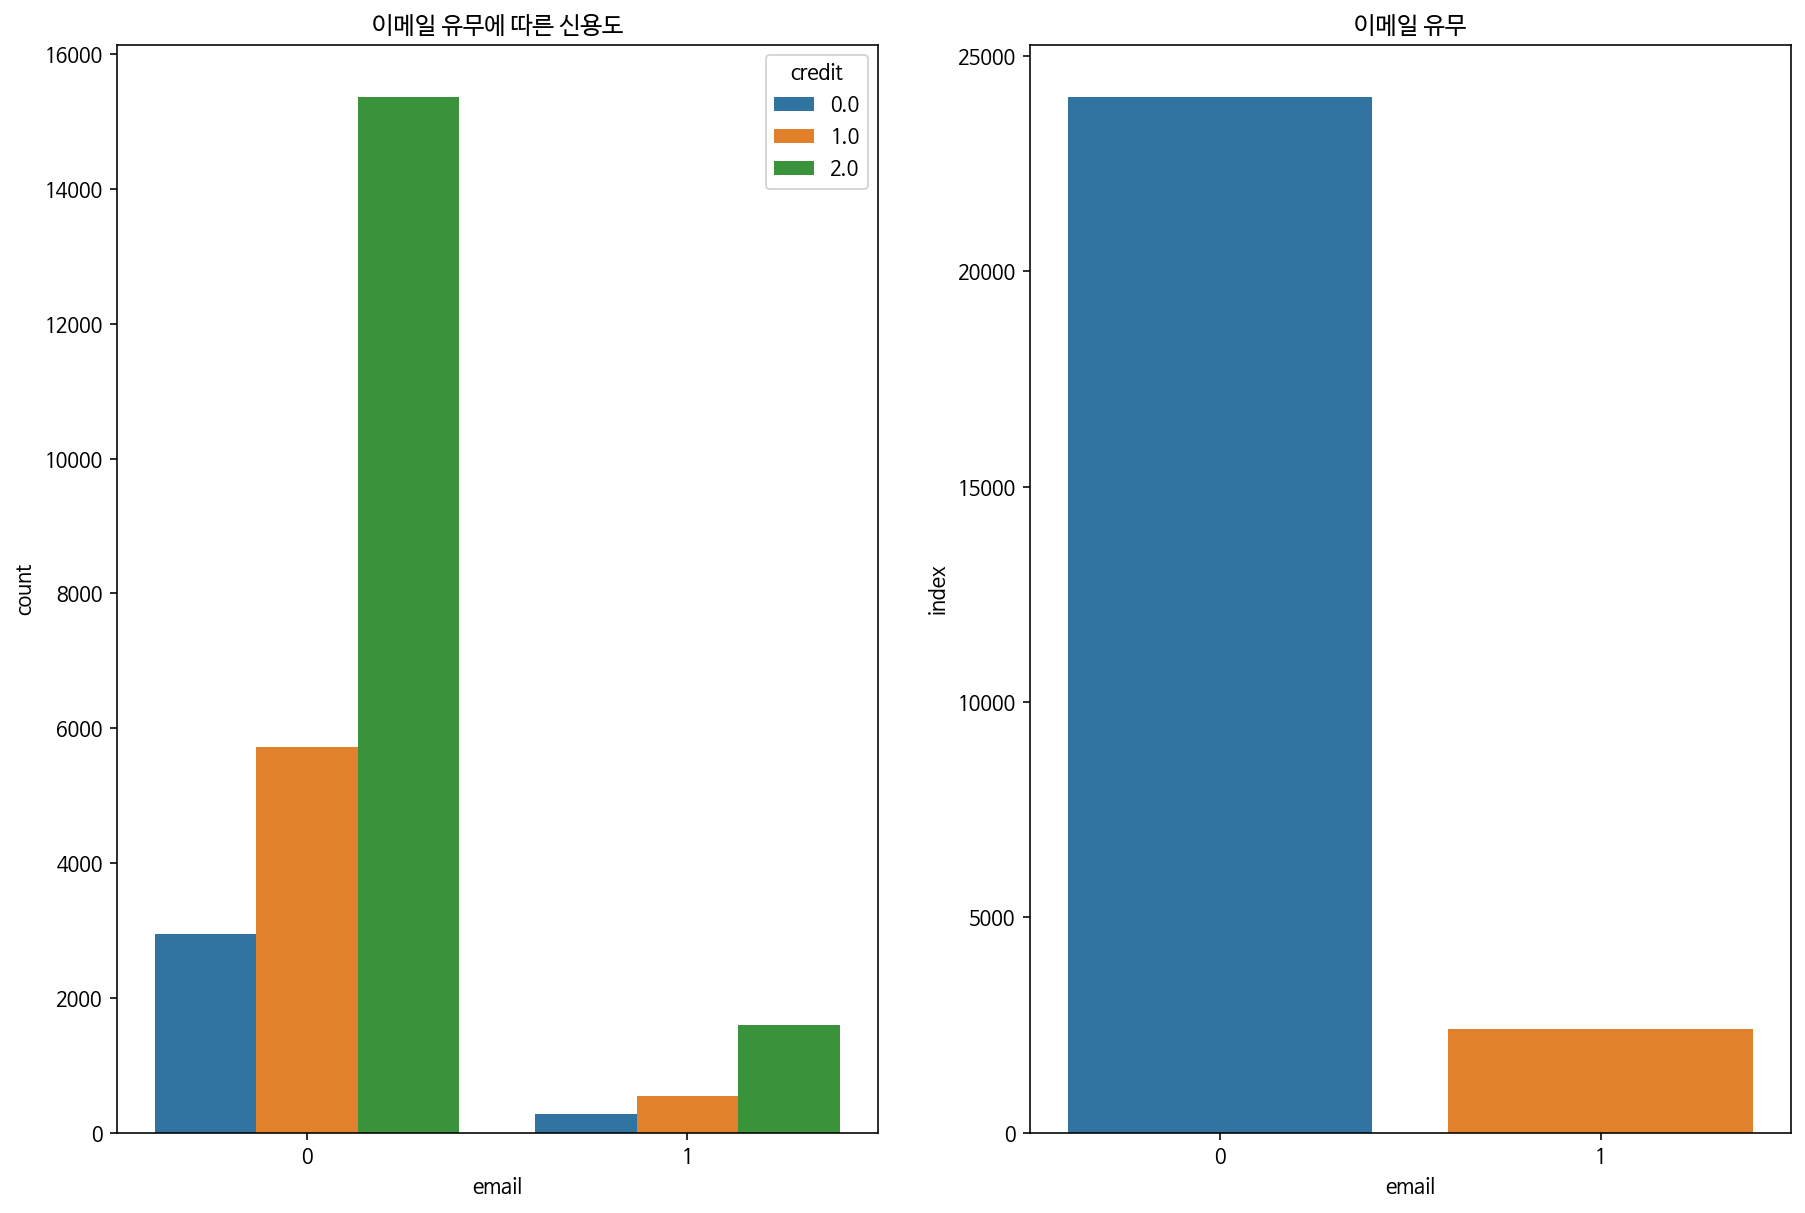

In [31]:
###email
email_bar=train.groupby('email')['index'].count().reset_index()

f,ax=plt.subplots(1,2,figsize=(15,10))
sns.barplot(data=email_bar, y = 'index',x = 'email')
ax[0].set_title('이메일 유무에 따른 신용도')
sns.countplot('email',hue='credit',data=train,ax=ax[0])
ax[1].set_title('이메일 유무')
plt.show()

In [32]:
pd.crosstab(train.email,train.credit,margins=True).style.background_gradient(cmap='summer_r')

credit,0.0,1.0,2.0,All
email,,,,
0,2953,5724,15365,24042
1,269,543,1603,2415
All,3222,6267,16968,26457


# 전처리 & Feature engineering

In [33]:
###결측치 확인하기
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [34]:
###직업 유형 nan의 경우 연금(pensioner)이여서 은퇴자라고 명칭을 바꿈.
train.occyp_type = train.occyp_type.fillna(value='retired')
test.occyp_type = test.occyp_type.fillna(value='retired')

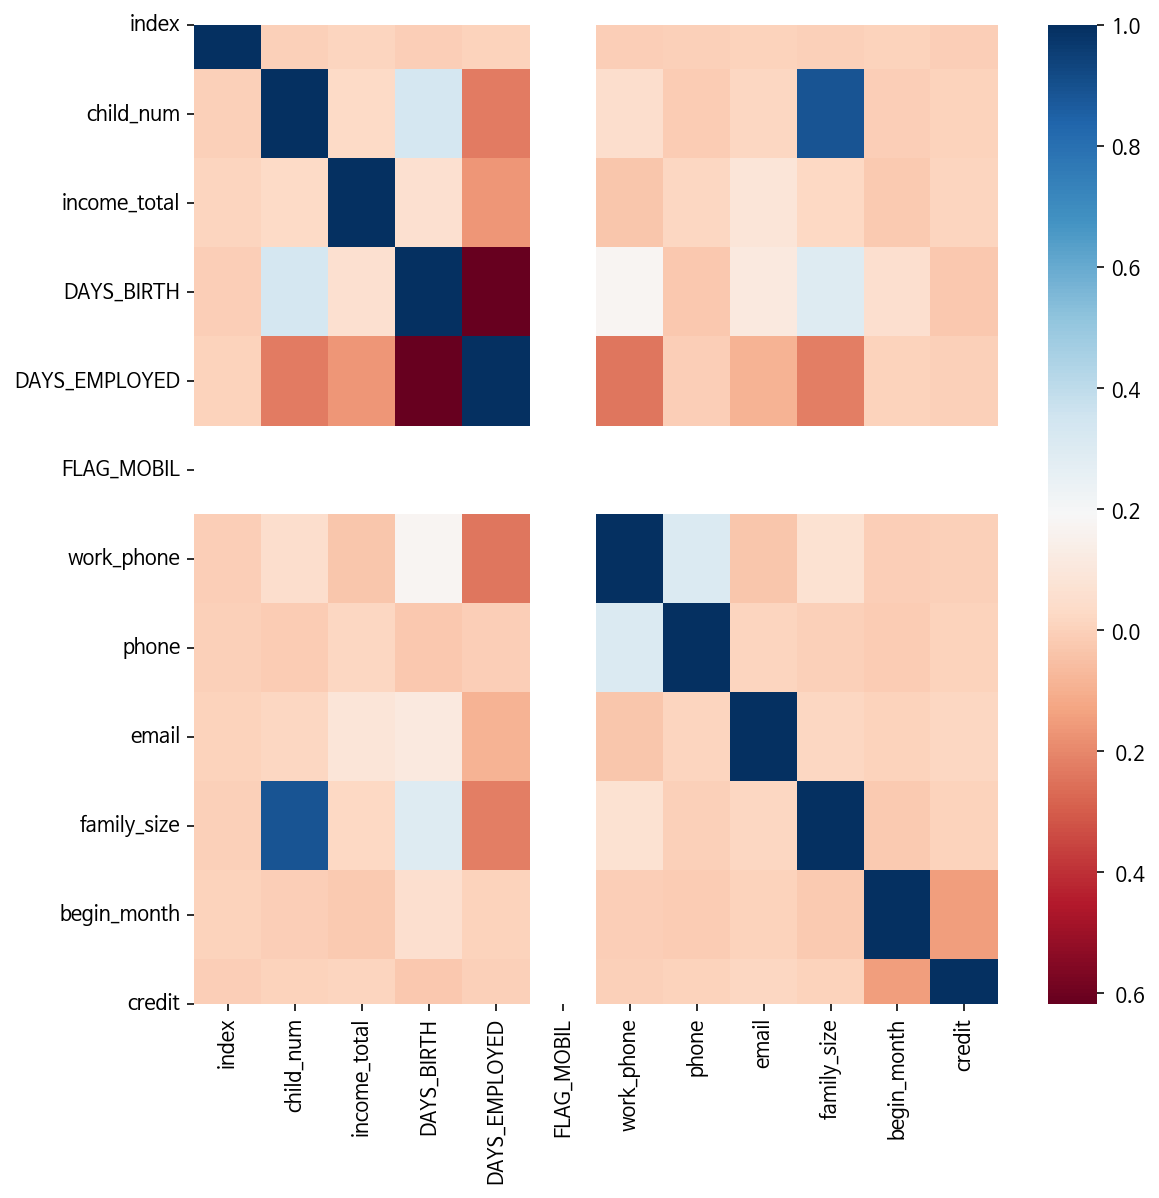

In [35]:
###특성들의 상관도 보기
###특히 상관도가 높은 특성들을 보기 위해서 상관도 보기 추가
plt.figure(figsize =(9,9))
corr = train.corr()
sns.heatmap(corr,cmap='RdBu')
plt.show()

In [36]:
###아이들 데이터 값들 보기
###7부터는 무의미한 값을 갖는다고 판단함.
###7,14,19는 제거하겠음
train.child_num.value_counts()

0     18340
1      5386
2      2362
3       306
4        47
5        10
14        3
7         2
19        1
Name: child_num, dtype: int64

In [37]:
###가족들 크기 데이터 값 보기
###9부터는 유의미한 값을 갖지 않는다고 판단함
###9, 15, 20은 제거하겠음
train.family_size.value_counts()

2.0     14106
1.0      5109
3.0      4632
4.0      2260
5.0       291
6.0        44
7.0         9
15.0        3
9.0         2
20.0        1
Name: family_size, dtype: int64

In [38]:
###아이들 데이터와 가족 크기 데이터 이상치 제거

train = train[(train['family_size']<=7)]
train = train.reset_index(drop=True)

In [39]:
train = train[(train['child_num']<=7)]
train = train.reset_index(drop=True)

In [40]:
###이상치 제거 되었는지 확인하기.

print('아이들 수','\n',train.child_num.value_counts(),'\n\n')
print('가족 수','\n',train.family_size.value_counts())

아이들 수 
 0    18340
1     5386
2     2362
3      306
4       47
5       10
Name: child_num, dtype: int64 


가족 수 
 2.0    14106
1.0     5109
3.0     4632
4.0     2260
5.0      291
6.0       44
7.0        9
Name: family_size, dtype: int64


In [41]:
###FALG_MIBIL값 과 인덱스 제거하기
train.drop(['index','FLAG_MOBIL'],axis=1, inplace=True)
test.drop(['index','FLAG_MOBIL'],axis=1, inplace=True)

In [42]:
###DAY관련 데이터 변환하기
###DAYS_EMPLOYED는 양수값 365243이 많은데, 날짜로 변환시 1000년이라는 기괴한 값이 나옴
###양수인 사람들의 수입을 보면 연금수령자로 나옴.
###직업을 우선 retired로 바꿨고, DAY_EMPLOYED에선 0으로 바꾼다.
train['DAYS_EMPLOYED']= train['DAYS_EMPLOYED'].map(lambda x:0 if x>0 else x)
test['DAYS_EMPLOYED']= test['DAYS_EMPLOYED'].map(lambda x:0 if x>0 else x)


In [43]:
#마이너스 붙은 데이터 다 양수로 변환시키기
feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for feat in feats:
    train[feat]=np.abs(train[feat])
    test[feat]=np.abs(test[feat])

In [44]:
###피쳐 엔지니어링 하기
def engineering(df):
  
  ###BIRTH의 파생 친구들 
  df['Age'] = df['DAYS_BIRTH']//365
  df['DAYS_BIRTH_MONTH'] = (df['DAYS_BIRTH']/30) - (((df['DAYS_BIRTH']/30)/12).astype(int)*12)

  ###EMPLOYED의 파생 친구들
  df['DAYS_EMPLOYED_MONTH'] = (df['DAYS_EMPLOYED']/30) - (((df['DAYS_EMPLOYED']/30)/12).astype(int)*12)
  df['Non_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
  
  df['Non_EMPLOYED_MONTH'] = (df['Non_EMPLOYED']/30) - (((df['Non_EMPLOYED']/30)/12).astype(int)*12)

  ###income의 파생 친구들
  return df

engineering(train)
engineering(test)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,phone,email,occyp_type,family_size,begin_month,Age,DAYS_BIRTH_MONTH,DAYS_EMPLOYED_MONTH,Non_EMPLOYED,Non_EMPLOYED_MONTH
0,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,21990,...,1,0,retired,2.0,60.0,60,1.000000,0.000000,21990,1.000000
1,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,18964,...,1,0,Core staff,2.0,36.0,51,8.133333,1.033333,10293,7.100000
2,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,15887,...,1,0,Laborers,2.0,40.0,43,1.566667,7.233333,15670,6.333333
3,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,19270,...,0,0,Drivers,2.0,41.0,52,6.333333,0.366667,16739,5.966667
4,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,17822,...,0,0,Managers,2.0,8.0,48,6.066667,0.833333,8437,5.233333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,18593,...,1,0,Accountants,2.0,19.0,50,7.766667,1.133333,13159,6.633333
9996,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,10886,...,0,0,Laborers,2.0,34.0,29,2.866667,7.833333,9571,7.033333
9997,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,21016,...,0,0,Medicine staff,2.0,55.0,57,4.533333,11.266667,6998,5.266667
9998,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,16541,...,1,0,retired,2.0,33.0,45,11.366667,0.166667,15456,11.200000


In [45]:
###numeric특성

numeric_features = train.dtypes[train.dtypes != 'object'].index.tolist()
numeric_features.remove('credit')

###category특성

category_features = train.dtypes[train.dtypes == 'object'].index.tolist()

In [46]:
numeric_features

['child_num',
 'income_total',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'work_phone',
 'phone',
 'email',
 'family_size',
 'begin_month',
 'Age',
 'DAYS_BIRTH_MONTH',
 'DAYS_EMPLOYED_MONTH',
 'Non_EMPLOYED',
 'Non_EMPLOYED_MONTH']

In [47]:
category_features

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type']

In [48]:
###category는 OrdinalEncoder
encoding = OrdinalEncoder()
train[category_features] = encoding.fit_transform(train[category_features],train['credit'])
test[category_features] = encoding.transform(test[category_features])

In [49]:
train[category_features]

,gender,car,reality,income_type,edu_type,family_type,house_type,occyp_type
0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,18.0
1,0.0,0.0,1.0,0.0,4.0,0.0,1.0,8.0
2,1.0,1.0,1.0,4.0,1.0,1.0,1.0,10.0
3,0.0,0.0,1.0,0.0,4.0,1.0,1.0,14.0
4,0.0,1.0,1.0,2.0,1.0,1.0,1.0,10.0
...,...,...,...,...,...,...,...,...
26446,0.0,0.0,0.0,2.0,4.0,1.0,1.0,3.0
26447,0.0,0.0,1.0,4.0,1.0,2.0,1.0,18.0
26448,0.0,1.0,0.0,4.0,4.0,0.0,5.0,3.0
26449,1.0,0.0,1.0,4.0,2.0,3.0,1.0,8.0


#모델링

타겟값인 credit이 3개여서 다중 클래스 분류로 들어가게 됨.
그래서 분류문제에 맞는 classifier모델로 모델링을 할 것.

분류문제에 맞는 평가지표는 logloss,f1 score, recall, precision, accuracy 가 있음.

여기서 logloss를 사용

In [50]:
target = 'credit'

X_train = train.drop(target,axis=1)
y_train = train[[target]]
X_test = test

In [51]:
###데이터 분할하기
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_train, y_train, stratify = y_train, test_size=0.2, random_state=42)

print("Train set: ")
print(X_train_1.shape)
print(y_train_1.shape)
print("===========")
print("Validation set: ")
print(X_val_1.shape)
print(y_val_1.shape)

Train set: 
(21160, 22)
(21160, 1)
Validation set: 
(5291, 22)
(5291, 1)


In [52]:
###기본모델 생성
###로지스틱회귀

lr = LogisticRegression()
lr.fit(X_train_1,y_train_1)
y_pred_1 = lr.predict_proba(X_val_1)

print(f"log_loss: {log_loss(to_categorical(y_val_1['credit']), y_pred_1)}")

log_loss: 0.8665300364511718


In [53]:
###결정트리

cf = DecisionTreeClassifier()
cf.fit(X_train_1,y_train_1)
y_pred_cf = cf.predict_proba(X_val_1)

print(f"log_loss: {log_loss(to_categorical(y_val_1['credit']), y_pred_cf)}")

log_loss: 12.222458721366467


In [54]:
###랜덤포레스트

rf = RandomForestClassifier()
rf.fit(X_train_1,y_train_1)
y_pred_rf = rf.predict_proba(X_val_1)

print(f"log_loss: {log_loss(to_categorical(y_val_1['credit']), y_pred_rf)}")

log_loss: 1.031009767164693


In [55]:
###LGBM

lgb = LGBMClassifier()
lgb.fit(X_train_1,y_train_1)
y_pred_lgb = lgb.predict_proba(X_val_1)

print(f"log_loss: {log_loss(to_categorical(y_val_1['credit']), y_pred_lgb)}")

log_loss: 0.7438925116049669


In [56]:
###KFold 정의하기
def start_kfold(clf):
  folds = KFold(n_splits=5, shuffle=True, random_state=42)
  results = [] ### 모델의 평가지표 logloss를 저장하기 위한 빈 리스트
  sub=np.zeros((X_test.shape[0], 3)) ###0의 빈리스트 10000,3의 형태로 만들기
  for n_fold, (train_index, val_index) in enumerate(folds.split(X_train, y_train)): ###folds.split으로 데이터 분리 
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index] 
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    clf.fit(X_train_fold, y_train_fold) ###모델 학습
        
    prediction = clf.predict_proba(X_val_fold) ###분리한 검증 데이터의 예측 확률
        
    logloss = log_loss(to_categorical(y_val_fold['credit']), prediction) ###로그로스값 비교하여 저장
    results.append(logloss) ### 빈리스트에 로그로스 저장
    print(f"FOLD {n_fold} : logloss : {logloss}") ### fold수와 그 로그로스 표현
        
    sub += clf.predict_proba(X_test) ### 테스트 데이터확률 값 sub에 저장
        
        
  mean_result = np.mean(results) ### 로그로스가 저장된 results 값 평균
  print("Mean:{}".format(mean_result)) ### 로그로스 평균값 표시
  return sub/folds.n_splits ### 테스트 데이터 확률 값 / n_splits값 으로 반환

In [57]:
start_kfold(lr)

FOLD 0 : logloss : 0.8615188135052935
FOLD 1 : logloss : 0.874371003531562
FOLD 2 : logloss : 0.8749836875454607
FOLD 3 : logloss : 0.8734096976287613
FOLD 4 : logloss : 0.8688093844043193
Mean:0.8706185173230795


array([[0.07181483, 0.13054515, 0.79764002],
       [0.08277822, 0.19412297, 0.72309881],
       [0.12406269, 0.19737536, 0.67856195],
       ...,
       [0.04441264, 0.12173383, 0.83385352],
       [0.11724704, 0.20667719, 0.67607577],
       [0.19741383, 0.28371292, 0.51887325]])

In [58]:
start_kfold(cf)

FOLD 0 : logloss : 12.400317005036753
FOLD 1 : logloss : 12.46181347452275
FOLD 2 : logloss : 12.551692404753364
FOLD 3 : logloss : 12.59884706822249
FOLD 4 : logloss : 12.525225007384105
Mean:12.507578991983891


array([[0.2, 0. , 0.8],
       [0.6, 0.2, 0.2],
       [0. , 0. , 1. ],
       ...,
       [0. , 0. , 1. ],
       [0.8, 0.2, 0. ],
       [0.2, 0. , 0.8]])

In [59]:
start_kfold(rf)

FOLD 0 : logloss : 1.0263743905343743
FOLD 1 : logloss : 1.0949358835906118
FOLD 2 : logloss : 1.145600396952421
FOLD 3 : logloss : 1.0191790855483904
FOLD 4 : logloss : 1.0319529876505293
Mean:1.0636085488552651


array([[0.032     , 0.19733333, 0.77066667],
       [0.474     , 0.25866667, 0.26733333],
       [0.019     , 0.042     , 0.939     ],
       ...,
       [0.028     , 0.08133333, 0.89066667],
       [0.53      , 0.34083333, 0.12916667],
       [0.10466667, 0.297     , 0.59833333]])

In [60]:
start_kfold(lgb)

FOLD 0 : logloss : 0.7352461539639532
FOLD 1 : logloss : 0.7398804619866869
FOLD 2 : logloss : 0.758727798865748
FOLD 3 : logloss : 0.7521194090368007
FOLD 4 : logloss : 0.7517948352287638
Mean:0.7475537318163906


array([[0.10125964, 0.17640778, 0.72233258],
       [0.14094459, 0.17945968, 0.67959574],
       [0.08269009, 0.16039467, 0.75691524],
       ...,
       [0.08142414, 0.15909589, 0.75947998],
       [0.1508418 , 0.22293459, 0.62622361],
       [0.08708852, 0.22598783, 0.68692364]])

In [61]:
###StratifiedKFold 정의하기
def start_StratifiedKFold(clf):
  skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  results = [] ### 모델의 평가지표 logloss를 저장하기 위한 빈 리스트
  sub=np.zeros((X_test.shape[0], 3)) ###0의 빈리스트 10000,3의 형태로 만들기
  for n_fold, (train_index, val_index) in enumerate(skfolds.split(X_train, y_train)): ###folds.split으로 데이터 분리 
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index] 
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    clf.fit(X_train_fold, y_train_fold) ###모델 학습
        
    prediction = clf.predict_proba(X_val_fold) ###분리한 검증 데이터의 예측 확률
        
    logloss = log_loss(to_categorical(y_val_fold['credit']), prediction) ###로그로스값 비교하여 저장
    results.append(logloss) ### 빈리스트에 로그로스 저장
    print(f"FOLD {n_fold} : logloss : {logloss}") ### fold수와 그 로그로스 표현
        
    sub += clf.predict_proba(X_test) ### 테스트 데이터확률 값 sub에 저장
        
        
  mean_result = np.mean(results) ### 로그로스가 저장된 results 값 평균
  print("Mean:{}".format(mean_result)) ### 로그로스 평균값 표시
  return sub/skfolds.n_splits ### 테스트 데이터 확률 값 / n_splits값 으로 반환

In [62]:
start_StratifiedKFold(lr)

FOLD 0 : logloss : 0.8663531080443401
FOLD 1 : logloss : 0.86665010025647
FOLD 2 : logloss : 0.8657043129329006
FOLD 3 : logloss : 0.8886610492468072
FOLD 4 : logloss : 0.8860224525446788
Mean:0.8746782046050393


array([[0.07963491, 0.16299337, 0.75737172],
       [0.09024354, 0.18810181, 0.72165464],
       [0.13107876, 0.22075368, 0.64816755],
       ...,
       [0.05150132, 0.11675522, 0.83174346],
       [0.11959732, 0.21821061, 0.66219206],
       [0.18859678, 0.28055286, 0.53085035]])

In [63]:
start_StratifiedKFold(cf)

FOLD 0 : logloss : 12.183835429428282
FOLD 1 : logloss : 12.523796093971697
FOLD 2 : logloss : 12.484520630735428
FOLD 3 : logloss : 12.155953274774612
FOLD 4 : logloss : 12.564978137379859
Mean:12.382616713257976


array([[0. , 0.2, 0.8],
       [0.6, 0.4, 0. ],
       [0. , 0. , 1. ],
       ...,
       [0. , 0. , 1. ],
       [0.8, 0.2, 0. ],
       [0. , 0.6, 0.4]])

In [64]:
start_StratifiedKFold(rf)

FOLD 0 : logloss : 1.1235986140220984
FOLD 1 : logloss : 1.0344214733455444
FOLD 2 : logloss : 1.0164133970146485
FOLD 3 : logloss : 0.9819079211811107
FOLD 4 : logloss : 1.0802603004346425
Mean:1.0473203411996088


array([[0.04666667, 0.21746667, 0.73586667],
       [0.49733333, 0.22      , 0.28266667],
       [0.022     , 0.047     , 0.931     ],
       ...,
       [0.024     , 0.07      , 0.906     ],
       [0.50033333, 0.37366667, 0.126     ],
       [0.06901667, 0.29083333, 0.64015   ]])

In [65]:
start_StratifiedKFold(lgb)

FOLD 0 : logloss : 0.7438640231504801
FOLD 1 : logloss : 0.7508177722313227
FOLD 2 : logloss : 0.7438327507851569
FOLD 3 : logloss : 0.7410928698501341
FOLD 4 : logloss : 0.7432529762755649
Mean:0.7445720784585317


array([[0.11199863, 0.13962673, 0.74837464],
       [0.1384815 , 0.17051728, 0.69100122],
       [0.07110832, 0.1612149 , 0.76767679],
       ...,
       [0.10835807, 0.14976767, 0.74187426],
       [0.16151072, 0.26640109, 0.57208819],
       [0.08364108, 0.21403848, 0.70232044]])

In [66]:
###feature importace 함수화 하기

def plot_feature_importance(model,column_data):
  importance_df= pd.Series(model.feature_importances_, column_data.columns)
  importance_df = pd.DataFrame(importance_df)
  importance_df = importance_df.reset_index()
  importance_df.rename(columns={'index':'featurename'},inplace=True)
  importance_df.rename(columns={0:'feature importance'},inplace=True)
  importance_df.sort_values(by=['feature importance'], ascending=False,inplace=True)

  plt.figure(figsize=(10,10))
  sns.barplot(x=importance_df['feature importance'],y=importance_df['featurename'])
  plt.show()
  return

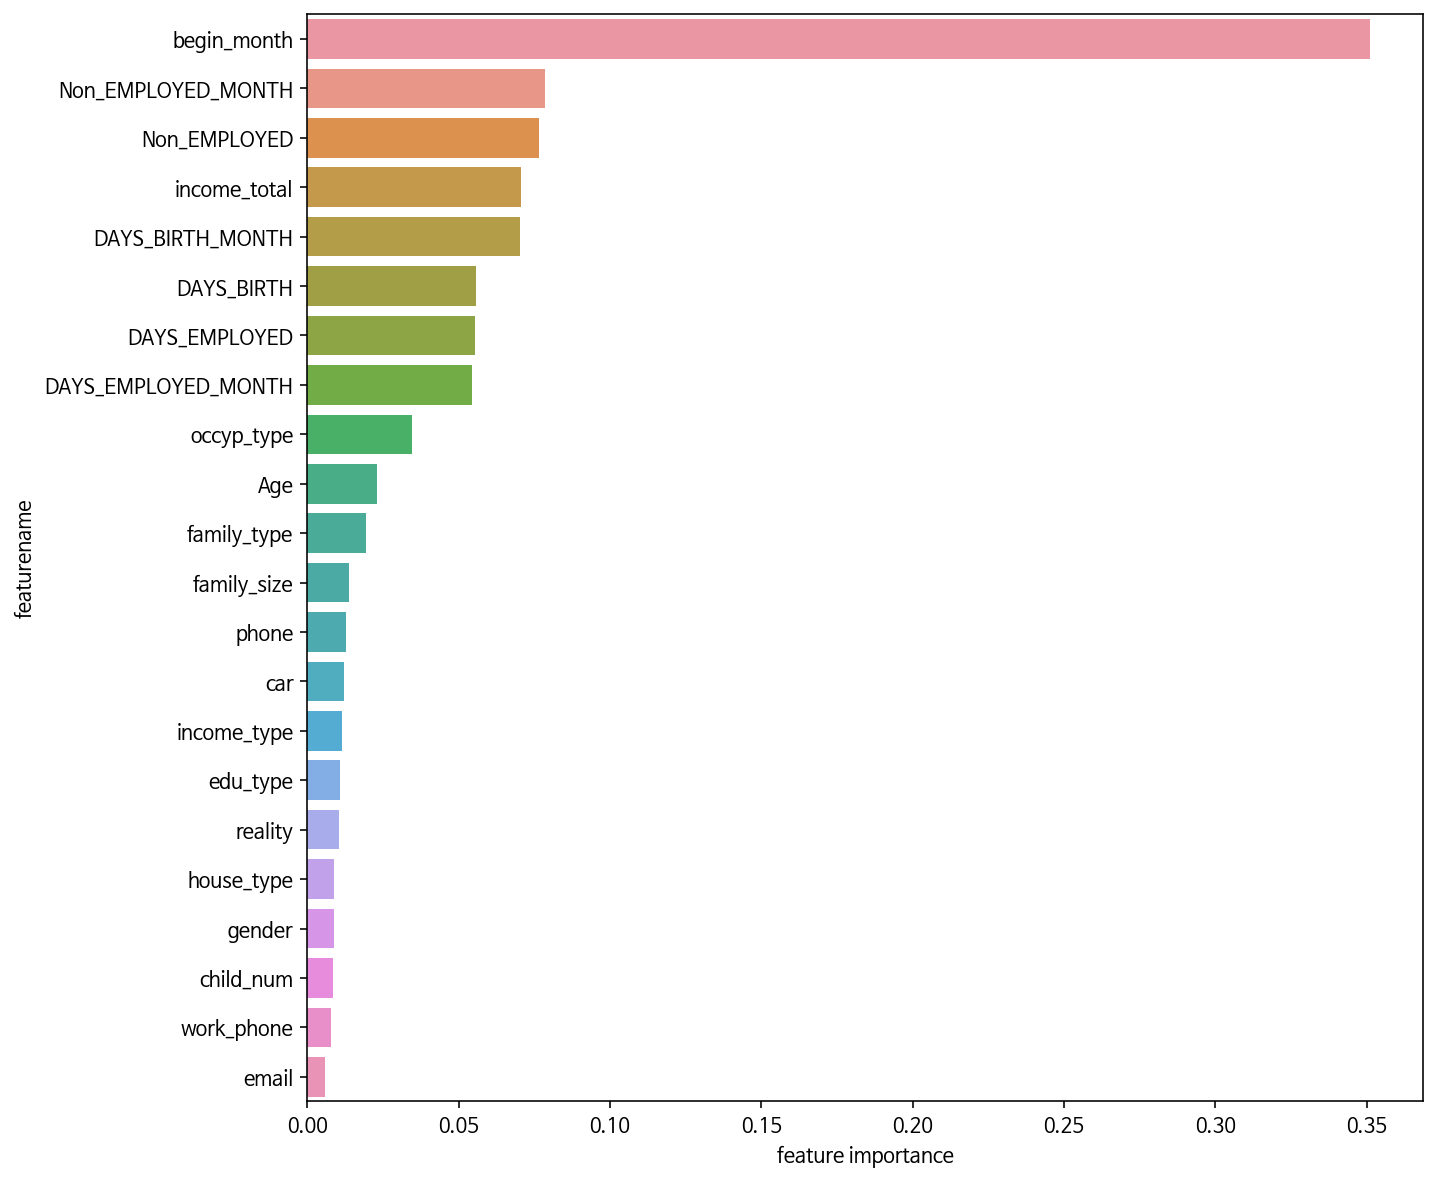

In [67]:
plot_feature_importance(cf,X_test)

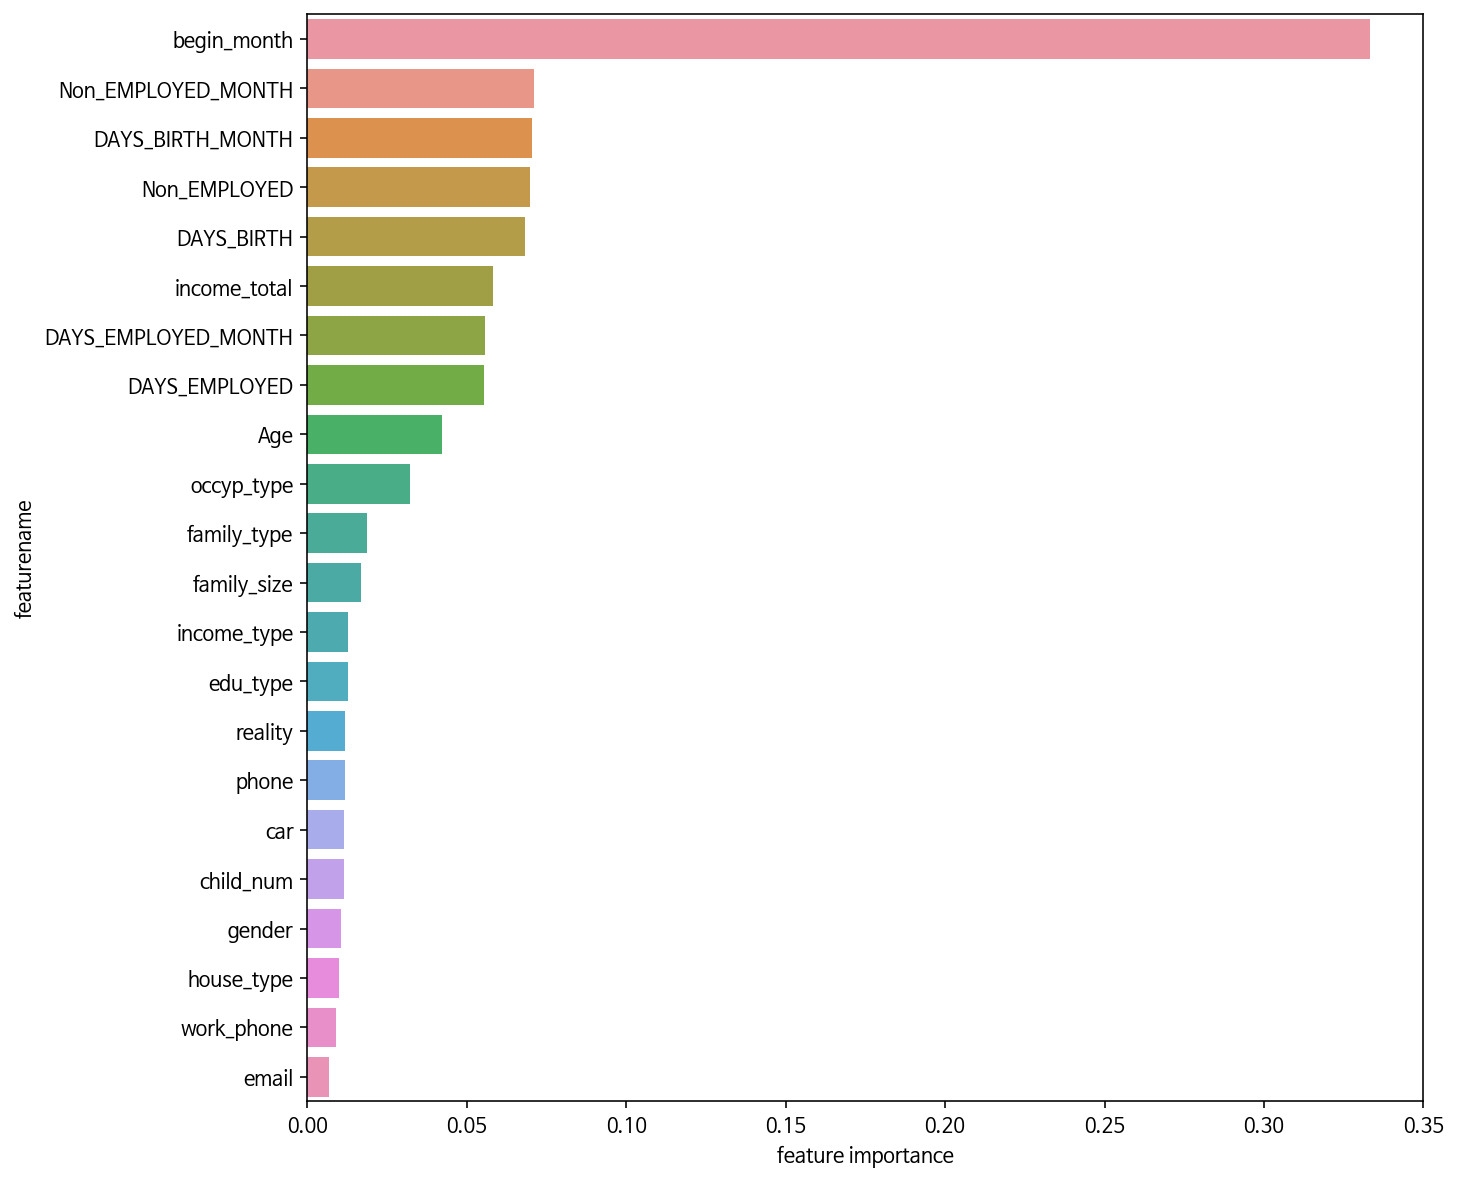

In [68]:
plot_feature_importance(rf,X_test)

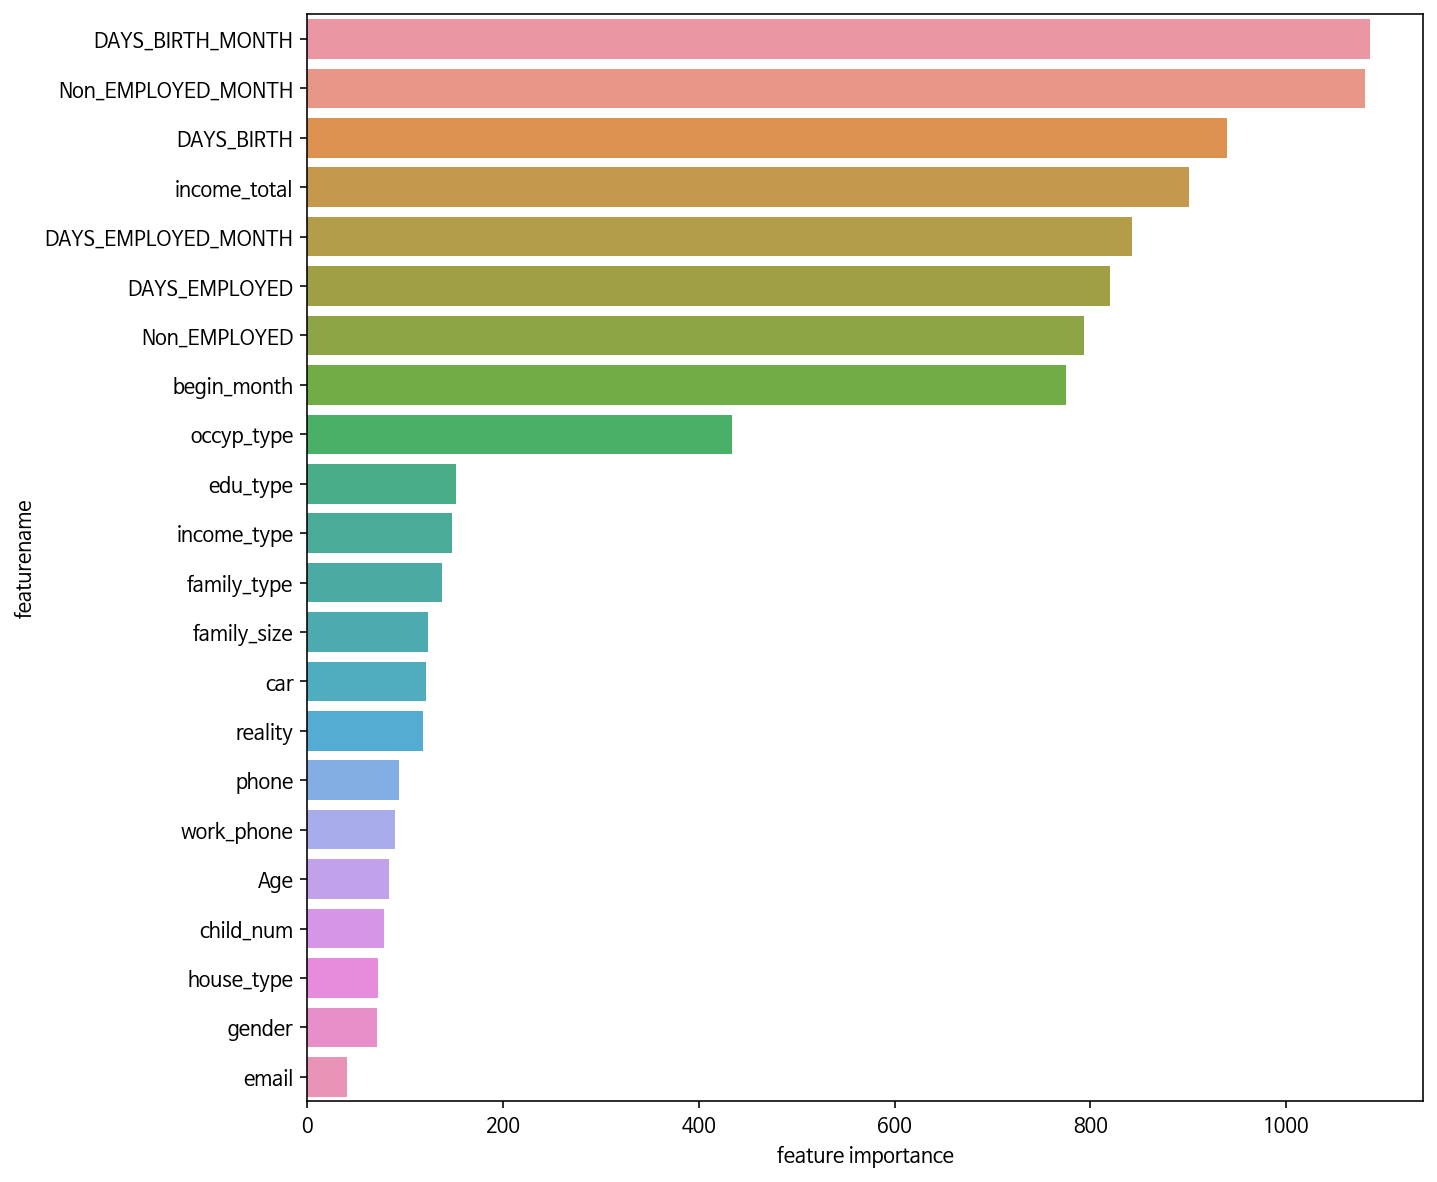

In [69]:
plot_feature_importance(lgb,X_test)

#모델들의 하이퍼 파라미터 수정하기 전에는 평가지표인 logloss를 보았을때 대다수의 모델들이 평균 0.7을 넘어가며, logloss는 답을 맞출 확률이 높을수록 0에 수렴하기때문에, 대략 40%정도로 문제를 맞춘다는 것을 볼 수 있음.

#결정트리, 랜덤포레스트에서는 신용카드 발급일이 가장 큰 feature_importace를 보여주었음.
#lgb는 기존 feature에서 수정한 MONTH들의 improtance가 높음을 볼 수 있다.

#날짜와 관련된 데이터들과 수입데이터들이 타겟데이터에 영향이 큰것을 볼 수 있음.

#하이퍼파라미터 튜닝


#optuna라는 새로운 튜닝 라이브러리 발견..

In [70]:
def lgb_objective(trial: Trial) -> float:
    params_lgb = {
        "random_state": 42,
        "verbosity": -1,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "objective": "multiclass",
        "metric": "multi_logloss",
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 3e-5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    
    ## 학습 모델 생성, 학습 진행
    model = LGBMClassifier(**params_lgb)
    model.fit(
        X_train_1,
        y_train_1,
        eval_set=[(X_train_1, y_train_1), (X_val_1, y_val_1)],
        early_stopping_rounds=50,
        verbose=False,
    )

    lgb_pred = model.predict_proba(X_val_1)
    log_score = log_loss(y_val_1, lgb_pred)
    ##logloss확인
    return log_score

In [71]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="minimize", ###로그로스 최소화 하는 방향으로 학습 진행 -> 즉, 정답맞출 확률이 증가하는 방향으로 진행
    sampler=sampler,
)
study.optimize(lgb_objective, n_trials=100) # n_trials 지정해주지 않으면, 무한 반복
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2022-05-24 01:30:55,002] A new study created in memory with name: lgbm_parameter_opt
[I 2022-05-24 01:31:10,033] Trial 0 finished with value: 0.7141636323932565 and parameters: {'reg_alpha': 1.12424581642324e-05, 'reg_lambda': 0.08556428806974939, 'max_depth': 15, 'num_leaves': 154, 'colsample_bytree': 0.4936111842654619, 'subsample': 0.40919616423534183, 'subsample_freq': 1, 'min_child_samples': 88, 'max_bin': 380}. Best is trial 0 with value: 0.7141636323932565.
[I 2022-05-24 01:31:20,307] Trial 1 finished with value: 0.7070419073438657 and parameters: {'reg_alpha': 2.1245096608103405e-05, 'reg_lambda': 0.0018526142807772773, 'max_depth': 20, 'num_leaves': 214, 'colsample_bytree': 0.5274034664069657, 'subsample': 0.42727747704497043, 'subsample_freq': 2, 'min_child_samples': 34, 'max_bin': 357}. Best is trial 1 with value: 0.7070419073438657.
[I 2022-05-24 01:31:33,337] Trial 2 finished with value: 0.7177436940897574 and parameters: {'reg_alpha': 1.2964031109077052e-05, 'reg_lambd

Best Score: 0.6921635379033808
Best trial: {'reg_alpha': 1.000479841969165e-05, 'reg_lambda': 0.060114161302905235, 'max_depth': 17, 'num_leaves': 89, 'colsample_bytree': 0.4598464612841949, 'subsample': 0.8066206495137557, 'subsample_freq': 7, 'min_child_samples': 5, 'max_bin': 442}


In [72]:
def rf_objective(trial: Trial) -> float:
  params_rf = {
      'random_state': 42,
      'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
      'max_depth': trial.suggest_int('max_depth', 4, 500),
      'min_samples_split': trial.suggest_int('min_samples_split', 2, 150),
      'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 60)
      }
    
    ## 학습 모델 생성, 학습 진행
  model = RandomForestClassifier(**params_rf)
  model.fit(
        X_train_1,
        y_train_1)

  lgb_pred = model.predict_proba(X_val_1)
  log_score = log_loss(y_val_1, lgb_pred)
    ##logloss확인
  return log_score

In [73]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name='rf_parameter_opt',
    direction='minimize', ###로그로스 최소화 하는 방향으로 학습 진행 -> 즉, 정답맞출 확률이 증가하는 방향으로 진행
    sampler=sampler,
)
study.optimize(rf_objective, n_trials=50) # n_trials 지정해주지 않으면, 무한 반복
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2022-05-24 01:49:54,249] A new study created in memory with name: rf_parameter_opt
[I 2022-05-24 01:50:05,661] Trial 0 finished with value: 0.7808025859834086 and parameters: {'n_estimators': 406, 'max_depth': 476, 'min_samples_split': 111, 'min_samples_leaf': 37}. Best is trial 0 with value: 0.7808025859834086.
[I 2022-05-24 01:50:11,046] Trial 1 finished with value: 0.7865170154657277 and parameters: {'n_estimators': 198, 'max_depth': 81, 'min_samples_split': 10, 'min_samples_leaf': 53}. Best is trial 0 with value: 0.7808025859834086.
[I 2022-05-24 01:50:27,395] Trial 2 finished with value: 0.7895536045518514 and parameters: {'n_estimators': 621, 'max_depth': 355, 'min_samples_split': 5, 'min_samples_leaf': 59}. Best is trial 0 with value: 0.7808025859834086.
[I 2022-05-24 01:50:56,629] Trial 3 finished with value: 0.7373928871048614 and parameters: {'n_estimators': 841, 'max_depth': 109, 'min_samples_split': 29, 'min_samples_leaf': 12}. Best is trial 3 with value: 0.7373928871048

Best Score: 0.6927945025516236
Best trial: {'n_estimators': 655, 'max_depth': 422, 'min_samples_split': 8, 'min_samples_leaf': 2}


In [74]:
def cf_objective(trial: Trial) -> float:
    params_cf = {
        "random_state": 42,
        "max_depth": trial.suggest_int("max_depth", 1, 100),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 500),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 500),
        "max_features": trial.suggest_int("max_features", 1, 20),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 2, 500),
    }
    
    ## 학습 모델 생성, 학습 진행
    model = DecisionTreeClassifier(**params_cf)
    model.fit(
        X_train_1,
        y_train_1
    )

    cf_pred = model.predict_proba(X_val_1)
    log_score = log_loss(y_val_1, cf_pred)
    ##logloss확인
    return log_score

In [75]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="cf_parameter_opt",
    direction="minimize", ###로그로스 최소화 하는 방향으로 학습 진행 -> 즉, 정답맞출 확률이 증가하는 방향으로 진행
    sampler=sampler,
)
study.optimize(cf_objective, n_trials=100) # n_trials 지정해주지 않으면, 무한 반복
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2022-05-24 02:06:32,657] A new study created in memory with name: cf_parameter_opt
[I 2022-05-24 02:06:32,761] Trial 0 finished with value: 0.8066258265043069 and parameters: {'max_depth': 38, 'min_samples_split': 476, 'min_samples_leaf': 367, 'max_features': 12, 'max_leaf_nodes': 79}. Best is trial 0 with value: 0.8066258265043069.
[I 2022-05-24 02:06:32,857] Trial 1 finished with value: 0.8073278229326669 and parameters: {'max_depth': 16, 'min_samples_split': 30, 'min_samples_leaf': 434, 'max_features': 13, 'max_leaf_nodes': 355}. Best is trial 0 with value: 0.8066258265043069.
[I 2022-05-24 02:06:32,887] Trial 2 finished with value: 0.8508258441696236 and parameters: {'max_depth': 3, 'min_samples_split': 485, 'min_samples_leaf': 417, 'max_features': 5, 'max_leaf_nodes': 92}. Best is trial 0 with value: 0.8066258265043069.
[I 2022-05-24 02:06:32,966] Trial 3 finished with value: 0.8120060601257665 and parameters: {'max_depth': 19, 'min_samples_split': 153, 'min_samples_leaf': 263,

Best Score: 0.8034877004618277
Best trial: {'max_depth': 84, 'min_samples_split': 168, 'min_samples_leaf': 268, 'max_features': 13, 'max_leaf_nodes': 157}


In [76]:
def xgb_objective(trial: Trial) -> float:
    params_xgb = {
        "random_state": 42,
        "verbosity": 1,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "objective": "multiclass",
        "metric": "multi_logloss",
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 3e-5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "min_child_weight": trial.suggest_int("min_child_weight", 0, 100),
        "min_split_loss": trial.suggest_int("min_split_loss", 0, 100),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.0, 1.0),
    }
    
    ## 학습 모델 생성, 학습 진행
    model = XGBClassifier(**params_xgb)
    model.fit(
        X_train_1,
        y_train_1,
        eval_set=[(X_train_1, y_train_1), (X_val_1, y_val_1)],
        early_stopping_rounds=10,
        verbose=False,
    )

    xgb_pred = model.predict_proba(X_val_1)
    log_score = log_loss(y_val_1, xgb_pred)
    ##logloss확인
    return log_score

In [77]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="xgbm_parameter_opt",
    direction="minimize", ###로그로스 최소화 하는 방향으로 학습 진행 -> 즉, 정답맞출 확률이 증가하는 방향으로 진행
    sampler=sampler,
)
study.optimize(xgb_objective, n_trials=50) # n_trials 지정해주지 않으면, 무한 반복
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2022-05-24 02:06:43,915] A new study created in memory with name: xgbm_parameter_opt
[I 2022-05-24 02:06:44,483] Trial 0 finished with value: 1.0822001939413792 and parameters: {'reg_alpha': 1.12424581642324e-05, 'reg_lambda': 0.08556428806974939, 'max_depth': 15, 'min_child_weight': 60, 'min_split_loss': 15, 'subsample': 0.40919616423534183, 'colsample_bytree': 0.05808361216819946}. Best is trial 0 with value: 1.0822001939413792.
[I 2022-05-24 02:06:45,769] Trial 1 finished with value: 1.0798655454343262 and parameters: {'reg_alpha': 2.598662261179031e-05, 'reg_lambda': 0.05410035504573868, 'max_depth': 15, 'min_child_weight': 2, 'min_split_loss': 97, 'subsample': 0.8827098485602951, 'colsample_bytree': 0.21233911067827616}. Best is trial 1 with value: 1.0798655454343262.
[I 2022-05-24 02:06:47,024] Trial 2 finished with value: 1.079860840914403 and parameters: {'reg_alpha': 5.462930766540947e-06, 'reg_lambda': 0.016506414052763946, 'max_depth': 7, 'min_child_weight': 53, 'min_spli

Best Score: 0.7021306718890968
Best trial: {'reg_alpha': 1.3416672967612636e-05, 'reg_lambda': 0.005592491200273799, 'max_depth': 16, 'min_child_weight': 9, 'min_split_loss': 1, 'subsample': 0.8162374313686281, 'colsample_bytree': 0.7028958875430833}


#Optuna를 통해 얻은 하이퍼파라미터를 모델링하여 Kfold에 다시 적용해봄

In [79]:
###결정트리 하이퍼파라미터 변경

cf_hyper = DecisionTreeClassifier(max_depth = 84, min_samples_split = 168, min_samples_leaf = 268, max_features = 13, max_leaf_nodes = 157)
cf_hyper.fit(X_train_1,y_train_1)
y_pred_cf_hyper = cf_hyper.predict_proba(X_val_1)

print(f"log_loss: {log_loss(to_categorical(y_val_1['credit']), y_pred_cf_hyper)}")

log_loss: 0.8115224833088281


In [80]:
###랜덤포레스트 하이퍼파라미터 변경

rf_hyper = RandomForestClassifier(n_estimators = 655, max_depth = 422, min_samples_split = 8, min_samples_leaf = 2)
rf_hyper.fit(X_train_1,y_train_1)
y_pred_rf_hyper = rf_hyper.predict_proba(X_val_1)

print(f"log_loss: {log_loss(to_categorical(y_val_1['credit']), y_pred_rf_hyper)}")

log_loss: 0.6926026609061706


In [81]:
###LGBM 하이퍼파라미터 변경

lgb_hyper = LGBMClassifier(reg_alpha = 1.000479841969165e-05, reg_lambda = 0.060114161302905235, max_depth = 17, num_leaves = 89, colsample_bytree = 0.4598464612841949, subsample = 0.8066206495137557, subsample_freq = 7, min_child_samples = 5, max_bin = 442)
lgb_hyper.fit(X_train_1,y_train_1)
y_pred_lgb_hyper = lgb_hyper.predict_proba(X_val_1)

print(f"log_loss: {log_loss(to_categorical(y_val_1['credit']), y_pred_lgb_hyper)}")

log_loss: 0.7091491513314622


In [82]:
###XGBM 하이퍼파라미터 변경

xgb_hyper = XGBClassifier(reg_alpha = 1.3416672967612636e-05, reg_lambda = 0.005592491200273799, max_depth = 16, min_child_weight = 9, min_split_loss = 1, subsample = 0.8162374313686281, colsample_bytree = 0.7028958875430833)
xgb_hyper.fit(X_train_1,y_train_1)
y_pred_xgb_hyper = xgb_hyper.predict_proba(X_val_1)

print(f"log_loss: {log_loss(to_categorical(y_val_1['credit']), y_pred_xgb_hyper)}")

log_loss: 0.7030904966069798


In [83]:
start_kfold(cf_hyper)

FOLD 0 : logloss : 0.7970840274830455
FOLD 1 : logloss : 0.8043526737578097
FOLD 2 : logloss : 0.8119478359292881
FOLD 3 : logloss : 0.8209832009097471
FOLD 4 : logloss : 0.818830903542065
Mean:0.8106397283243911


array([[0.09873279, 0.21549312, 0.68577409],
       [0.10120604, 0.14888077, 0.74991319],
       [0.11471101, 0.16567644, 0.71961255],
       ...,
       [0.1071538 , 0.17216144, 0.72068476],
       [0.12332217, 0.19922228, 0.67745555],
       [0.11601081, 0.21325026, 0.67073892]])

In [84]:
start_kfold(rf_hyper)

FOLD 0 : logloss : 0.6889633844295093
FOLD 1 : logloss : 0.6949111453057376
FOLD 2 : logloss : 0.7034486810809669
FOLD 3 : logloss : 0.7004297348243664
FOLD 4 : logloss : 0.70222140996349
Mean:0.697994871120814


array([[0.06575222, 0.22151988, 0.7127279 ],
       [0.25596314, 0.25649438, 0.48754248],
       [0.04387772, 0.06792833, 0.88819395],
       ...,
       [0.0465628 , 0.15316128, 0.80027592],
       [0.25715029, 0.40834681, 0.33450291],
       [0.0924185 , 0.26375538, 0.64382612]])

In [85]:
start_kfold(lgb_hyper)

FOLD 0 : logloss : 0.7021098298158996
FOLD 1 : logloss : 0.7057025980829507
FOLD 2 : logloss : 0.7197998538688303
FOLD 3 : logloss : 0.7149899380422312
FOLD 4 : logloss : 0.714690263288015
Mean:0.7114584966195854


array([[0.06144061, 0.17598983, 0.76256956],
       [0.18689864, 0.20831087, 0.60479049],
       [0.06786844, 0.11066963, 0.82146193],
       ...,
       [0.05684389, 0.1481468 , 0.79500931],
       [0.17330907, 0.28466389, 0.54202705],
       [0.09514201, 0.26896893, 0.63588907]])

In [86]:
start_kfold(xgb_hyper)

FOLD 0 : logloss : 0.7014768490009116
FOLD 1 : logloss : 0.6965769564363197
FOLD 2 : logloss : 0.7175913530364915
FOLD 3 : logloss : 0.7101336679409042
FOLD 4 : logloss : 0.7135588174883015
Mean:0.7078675287805857


array([[0.06568232, 0.17639413, 0.75792357],
       [0.23567495, 0.24381376, 0.52051128],
       [0.03160361, 0.07034945, 0.89804695],
       ...,
       [0.0732627 , 0.10845521, 0.81828209],
       [0.25554971, 0.41176981, 0.33268046],
       [0.05749727, 0.2839776 , 0.6585251 ]])

In [87]:
start_StratifiedKFold(cf_hyper)

FOLD 0 : logloss : 0.8042399474606052
FOLD 1 : logloss : 0.8201091761933843
FOLD 2 : logloss : 0.8133930715903402
FOLD 3 : logloss : 0.8197082199886562
FOLD 4 : logloss : 0.8124188622824707
Mean:0.8139738555030913


array([[0.10483836, 0.18653682, 0.70862482],
       [0.10844227, 0.1662008 , 0.72535693],
       [0.09573074, 0.168326  , 0.73594327],
       ...,
       [0.12304825, 0.15004297, 0.72690878],
       [0.1241461 , 0.21222787, 0.66362603],
       [0.0954274 , 0.30774128, 0.59683132]])

In [88]:
start_StratifiedKFold(rf_hyper)

FOLD 0 : logloss : 0.6908431976776552
FOLD 1 : logloss : 0.6938589131340072
FOLD 2 : logloss : 0.698629671745219
FOLD 3 : logloss : 0.6917897671652681
FOLD 4 : logloss : 0.7025124404487781
Mean:0.6955267980341855


array([[0.06854675, 0.22246979, 0.70898346],
       [0.25405015, 0.25465317, 0.49129668],
       [0.04661658, 0.06834037, 0.88504305],
       ...,
       [0.04638218, 0.15049092, 0.8031269 ],
       [0.23616525, 0.42942921, 0.33440553],
       [0.0892717 , 0.26739558, 0.64333272]])

In [89]:
start_StratifiedKFold(lgb_hyper)

FOLD 0 : logloss : 0.7101634109142203
FOLD 1 : logloss : 0.7119409853939189
FOLD 2 : logloss : 0.7109649625766734
FOLD 3 : logloss : 0.7065530028117878
FOLD 4 : logloss : 0.7104163445607262
Mean:0.7100077412514653


array([[0.07136123, 0.14450391, 0.78413486],
       [0.20731331, 0.22584745, 0.56683925],
       [0.05788889, 0.12330679, 0.81880432],
       ...,
       [0.05541166, 0.13403418, 0.81055417],
       [0.15929212, 0.31818154, 0.52252634],
       [0.07923945, 0.29091853, 0.62984202]])

In [90]:
start_StratifiedKFold(xgb_hyper)

FOLD 0 : logloss : 0.7038541627018811
FOLD 1 : logloss : 0.7016842313408359
FOLD 2 : logloss : 0.7072390988046595
FOLD 3 : logloss : 0.6941628417433265
FOLD 4 : logloss : 0.7108988015773391
Mean:0.7035678272336084


array([[0.07074466, 0.15017017, 0.77908517],
       [0.20895331, 0.26372703, 0.52731966],
       [0.03665015, 0.07561185, 0.88773799],
       ...,
       [0.07119383, 0.14109522, 0.78771095],
       [0.19843318, 0.44579969, 0.35576715],
       [0.05286377, 0.33472271, 0.61241351]])

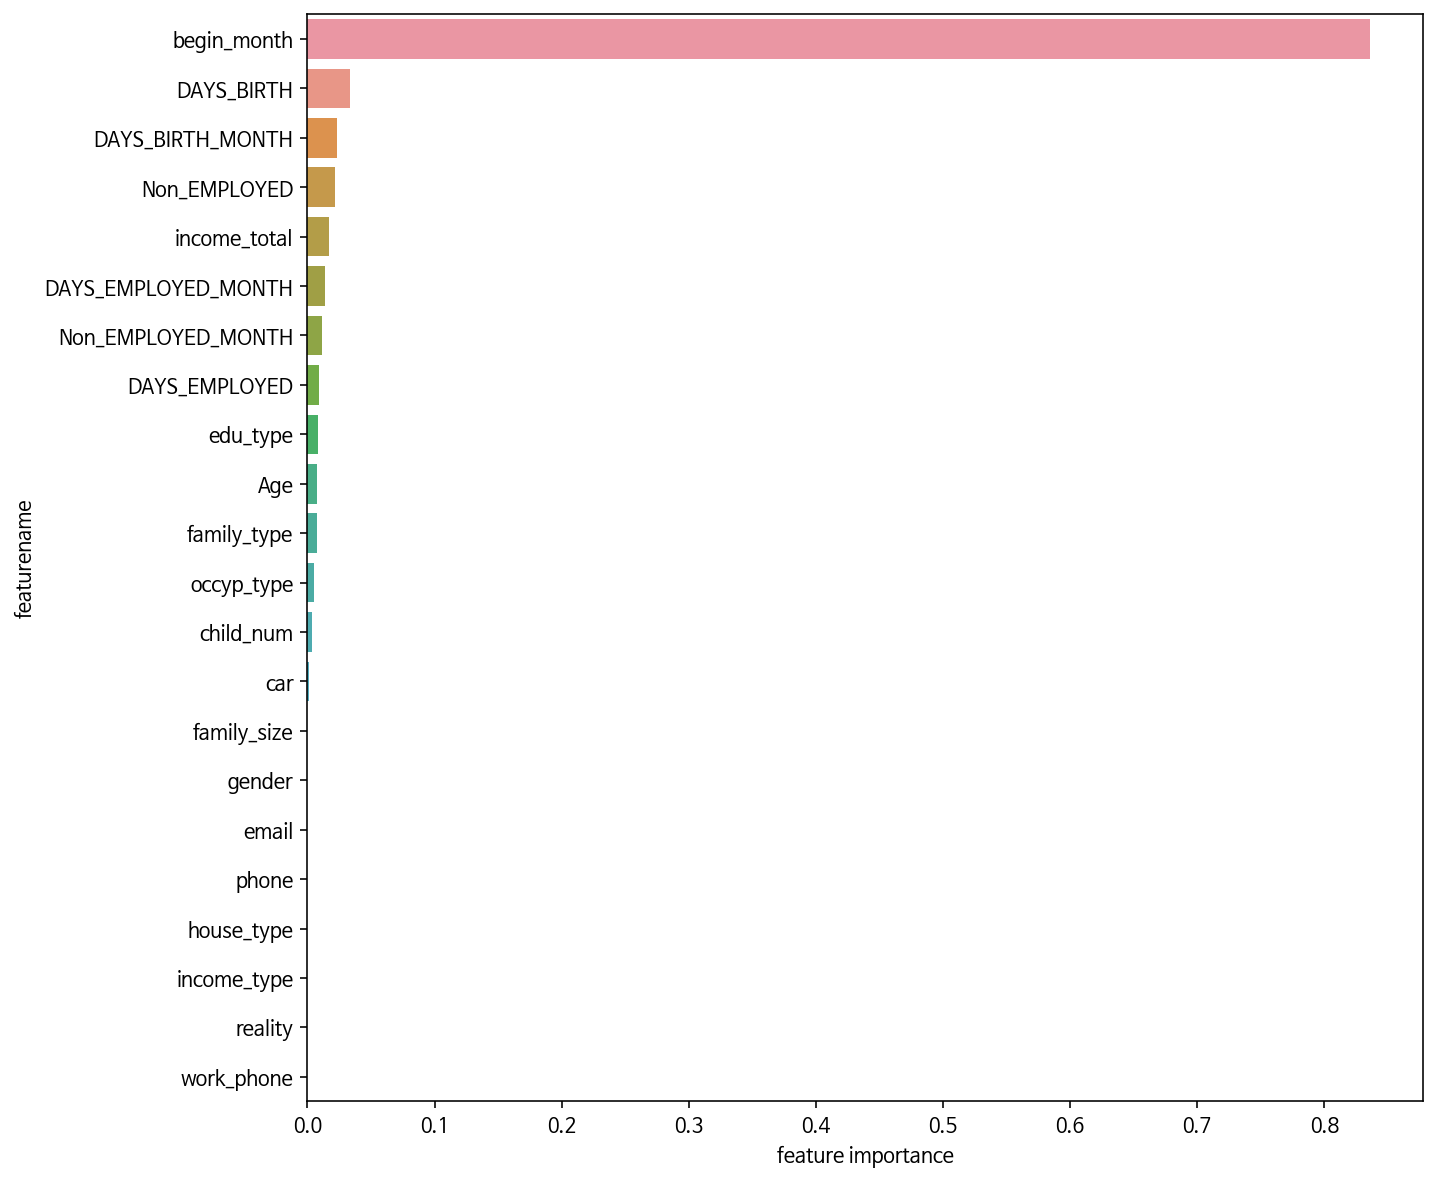

In [91]:
plot_feature_importance(cf_hyper,X_test)

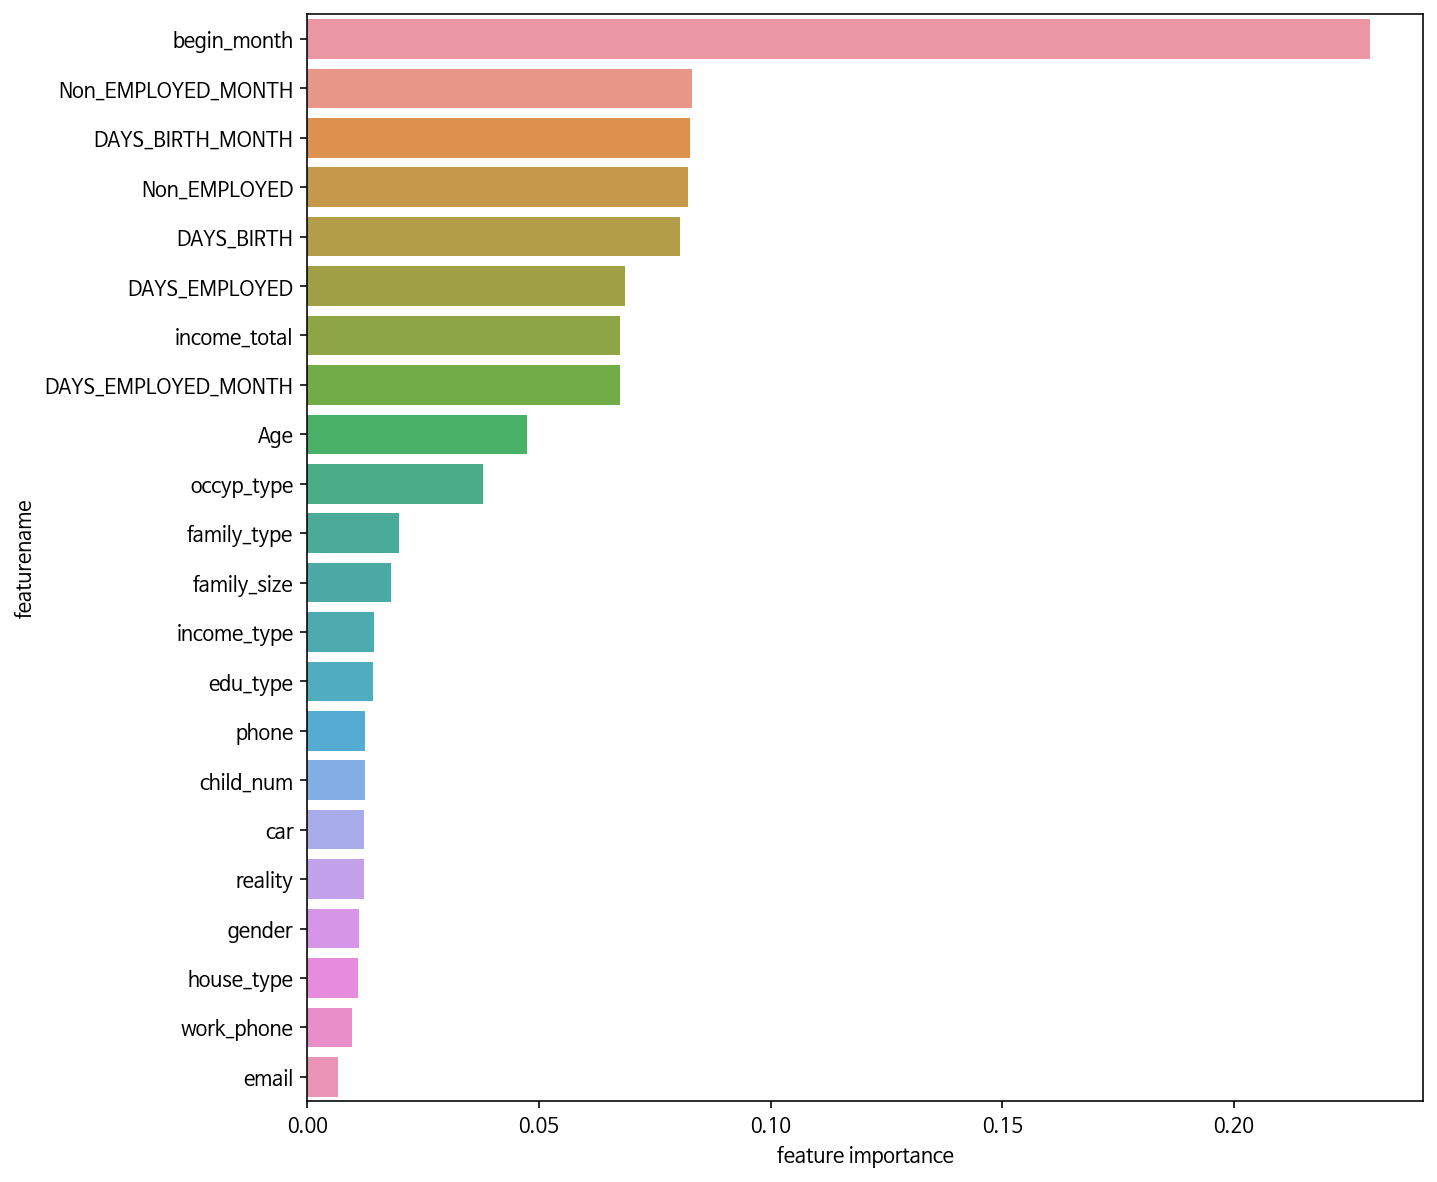

In [92]:
plot_feature_importance(rf_hyper,X_test)

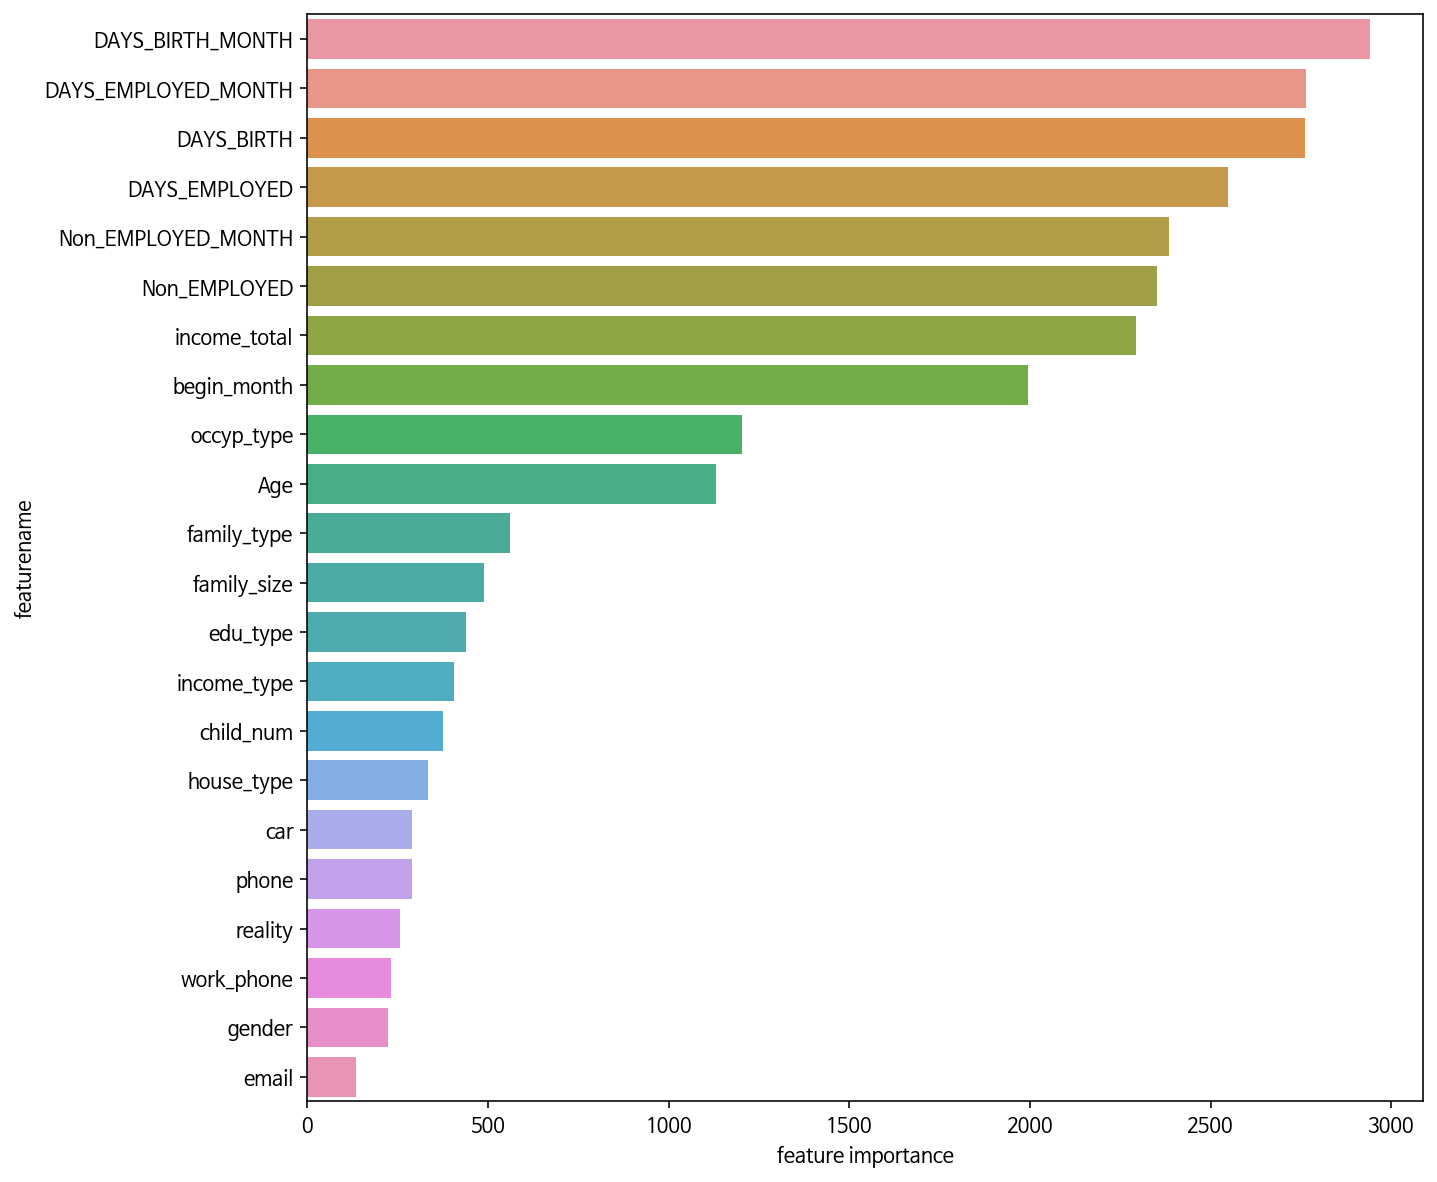

In [93]:
plot_feature_importance(lgb_hyper,X_test)

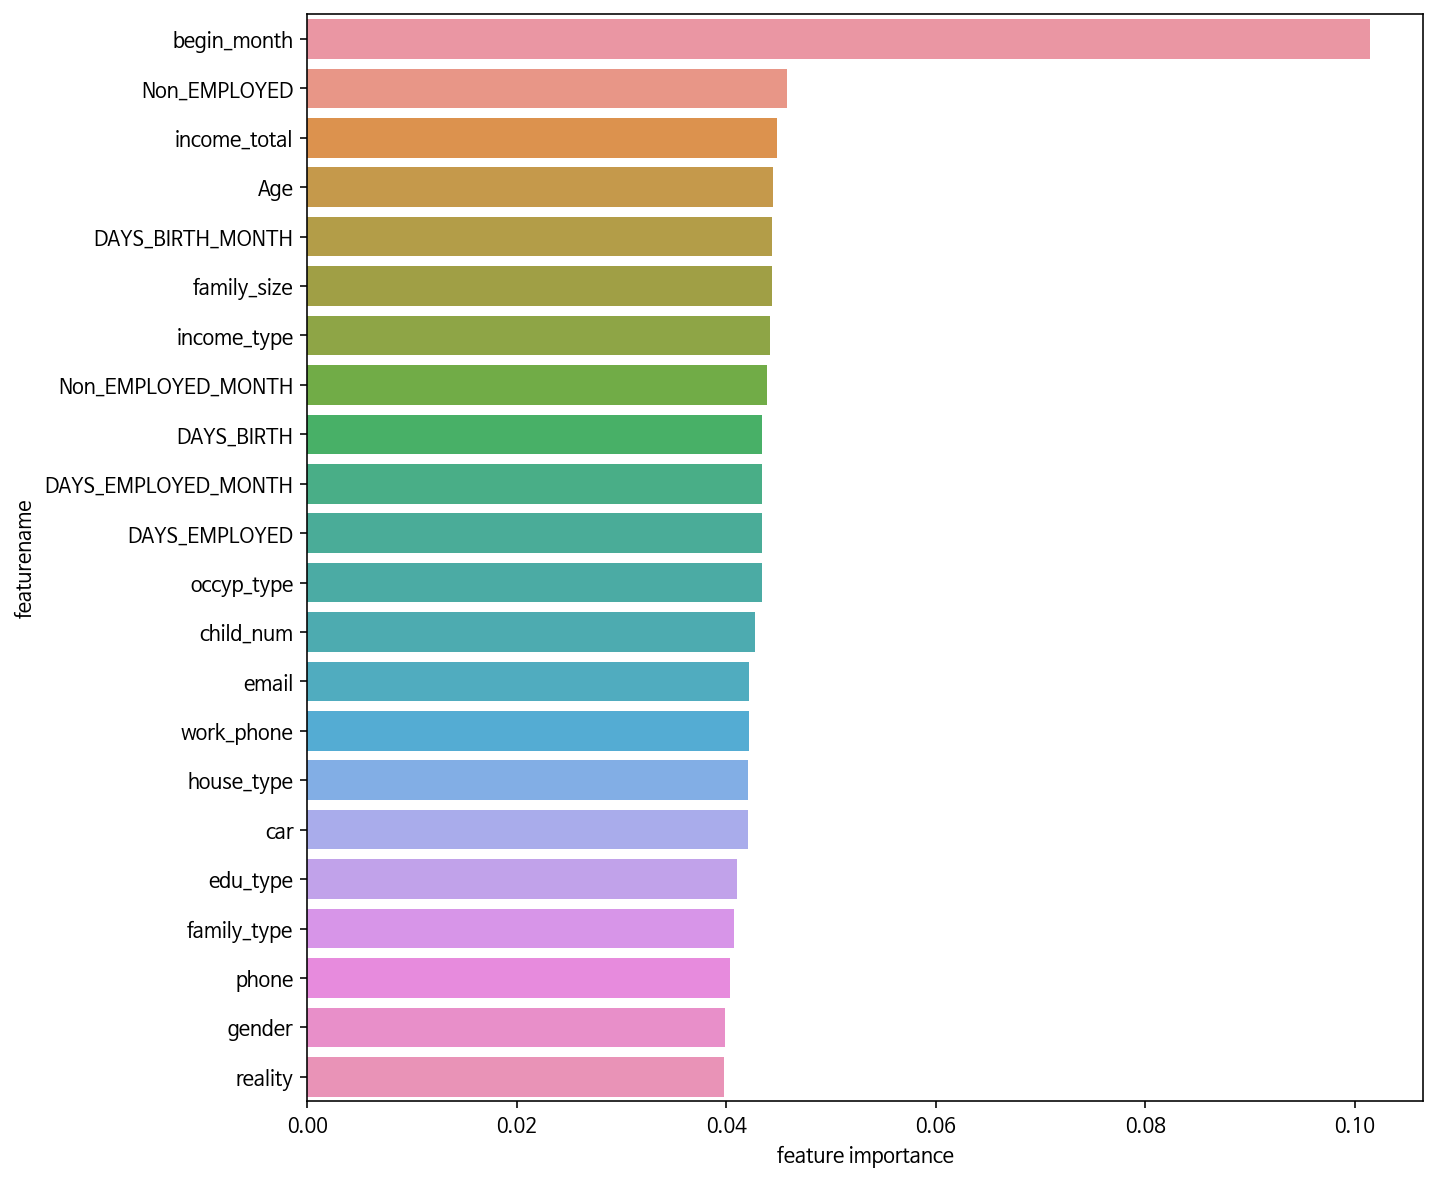

In [94]:
plot_feature_importance(xgb_hyper,X_test)

In [95]:
skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = [] ### 모델의 평가지표 logloss를 저장하기 위한 빈 리스트
sub=np.zeros((X_test.shape[0], 3)) ###0의 빈리스트 10000,3의 형태로 만들기

for n_fold, (train_index, val_index) in enumerate(skfolds.split(X_train, y_train)): ###folds.split으로 데이터 분리 
  X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index] 
  y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
  rf_hyper.fit(X_train_fold, y_train_fold) ###모델 학습
        
  prediction = rf_hyper.predict_proba(X_val_fold) ###분리한 검증 데이터의 예측 확률
        
  logloss = log_loss(to_categorical(y_val_fold['credit']), prediction) ###로그로스값 비교하여 저장
  results.append(logloss) ### 빈리스트에 로그로스 저장
  print(f"FOLD {n_fold} : logloss : {logloss}") ### fold수와 그 로그로스 표현
        
  sub += rf_hyper.predict_proba(X_test) ### 테스트 데이터확률 값 sub에 저장
        
        
  mean_result = np.mean(results) ### 로그로스가 저장된 results 값 평균
print("Mean:{}".format(mean_result)) ### 로그로스 평균값 표시

FOLD 0 : logloss : 0.6923051691202959
FOLD 1 : logloss : 0.6927529814111613
FOLD 2 : logloss : 0.699965312561207
FOLD 3 : logloss : 0.6927084538038404
FOLD 4 : logloss : 0.7031741047526673
Mean:0.6961812043298343


#PDP

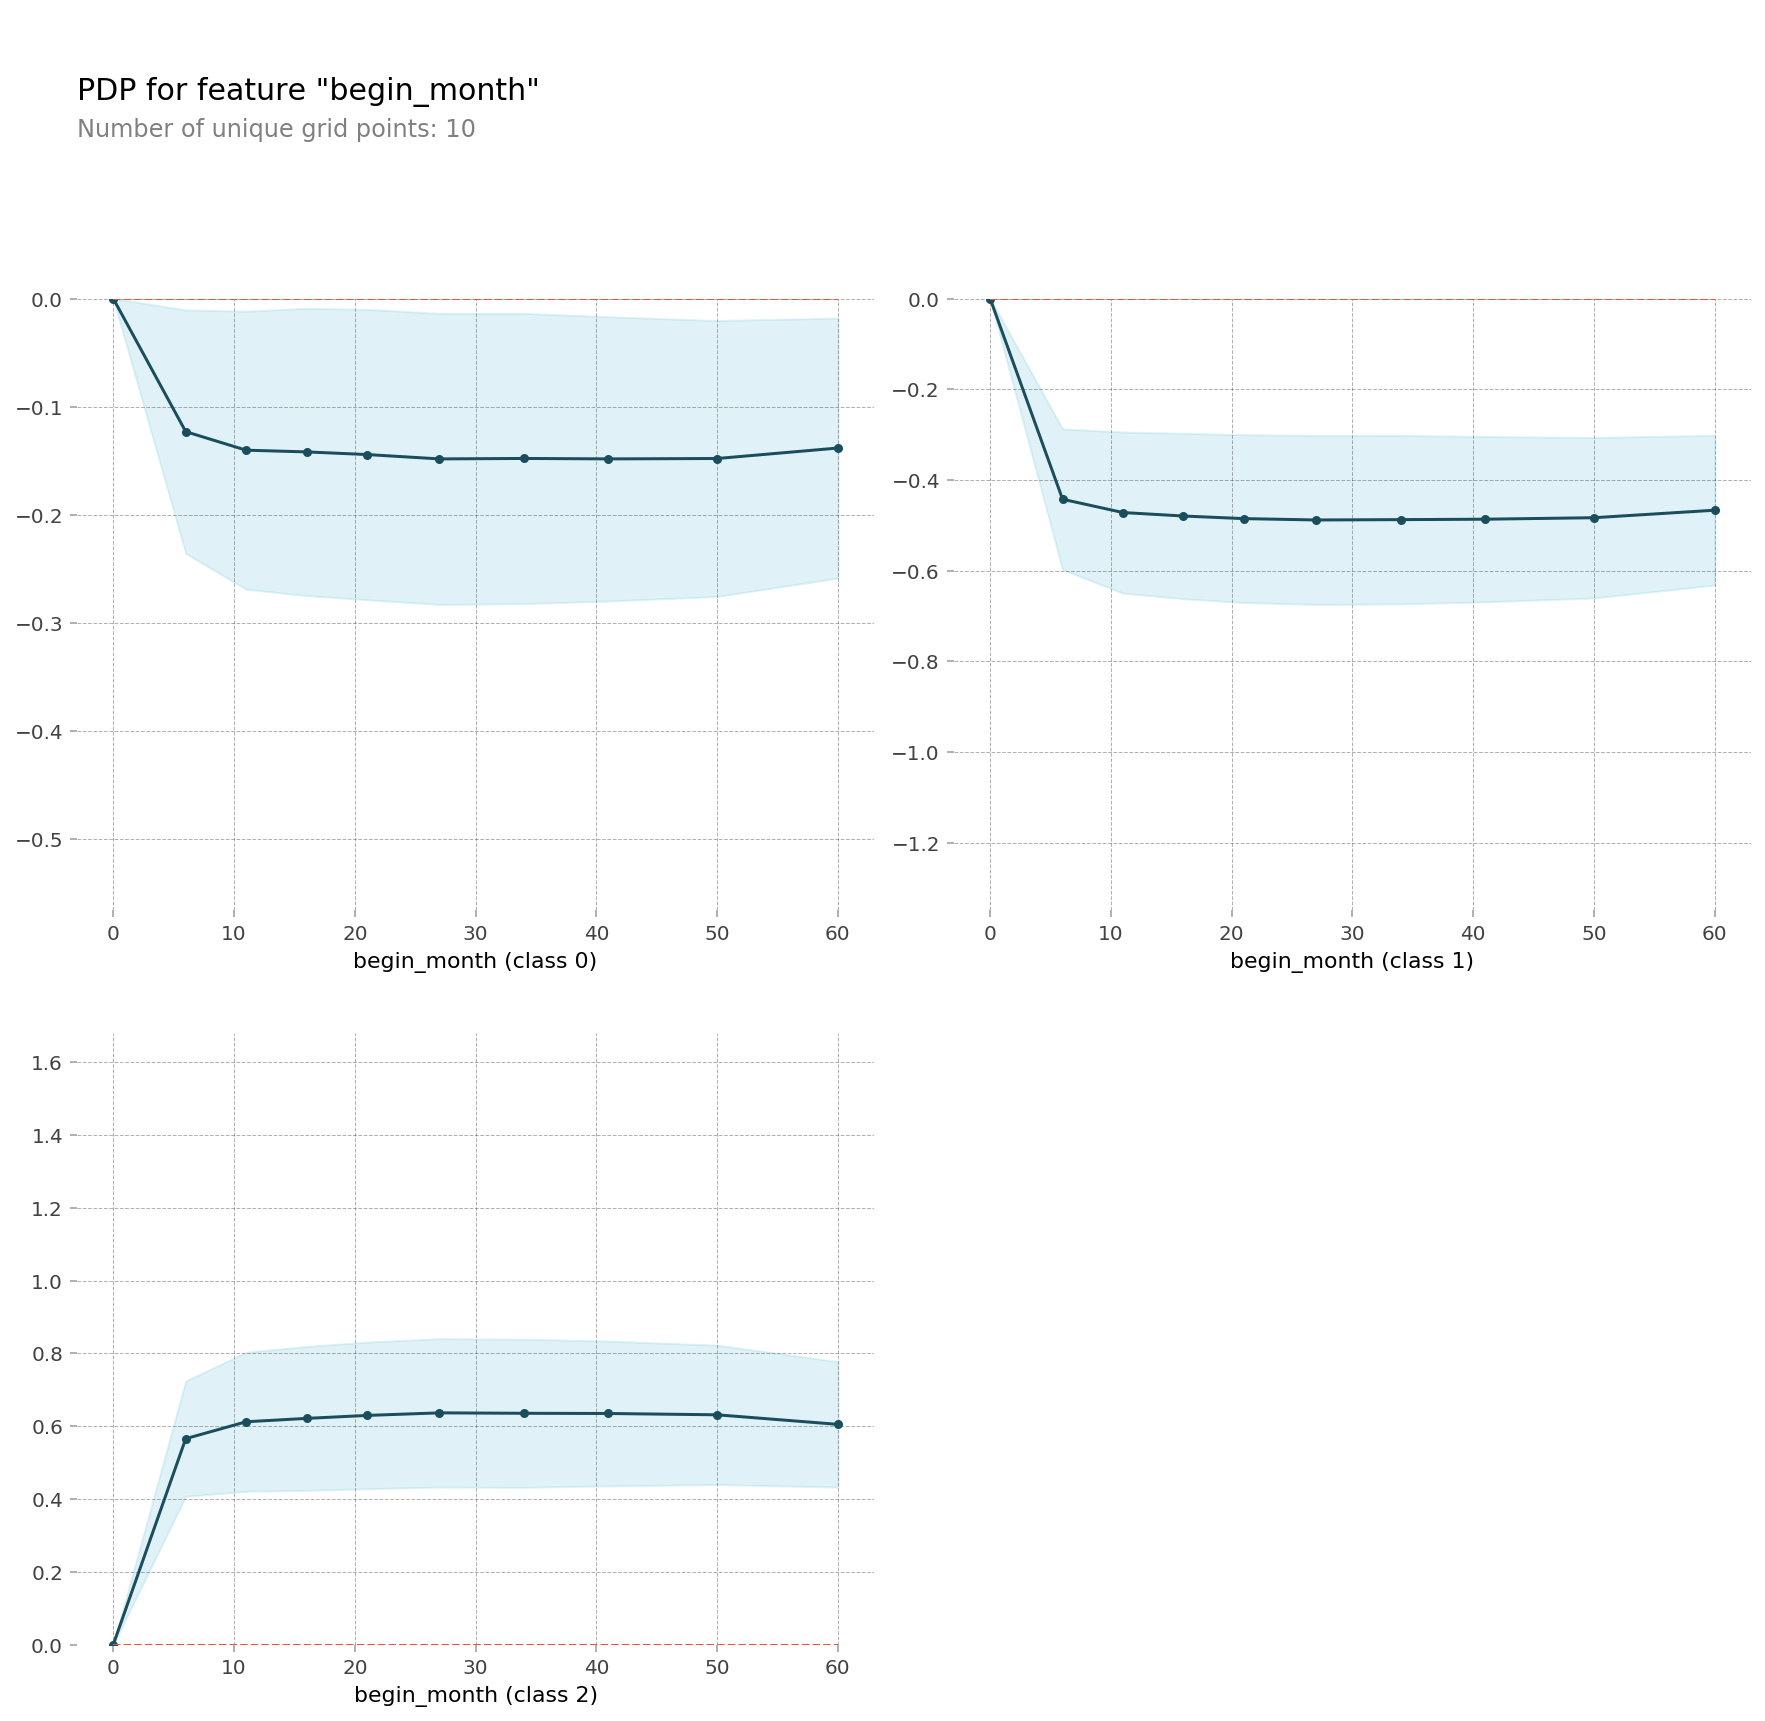

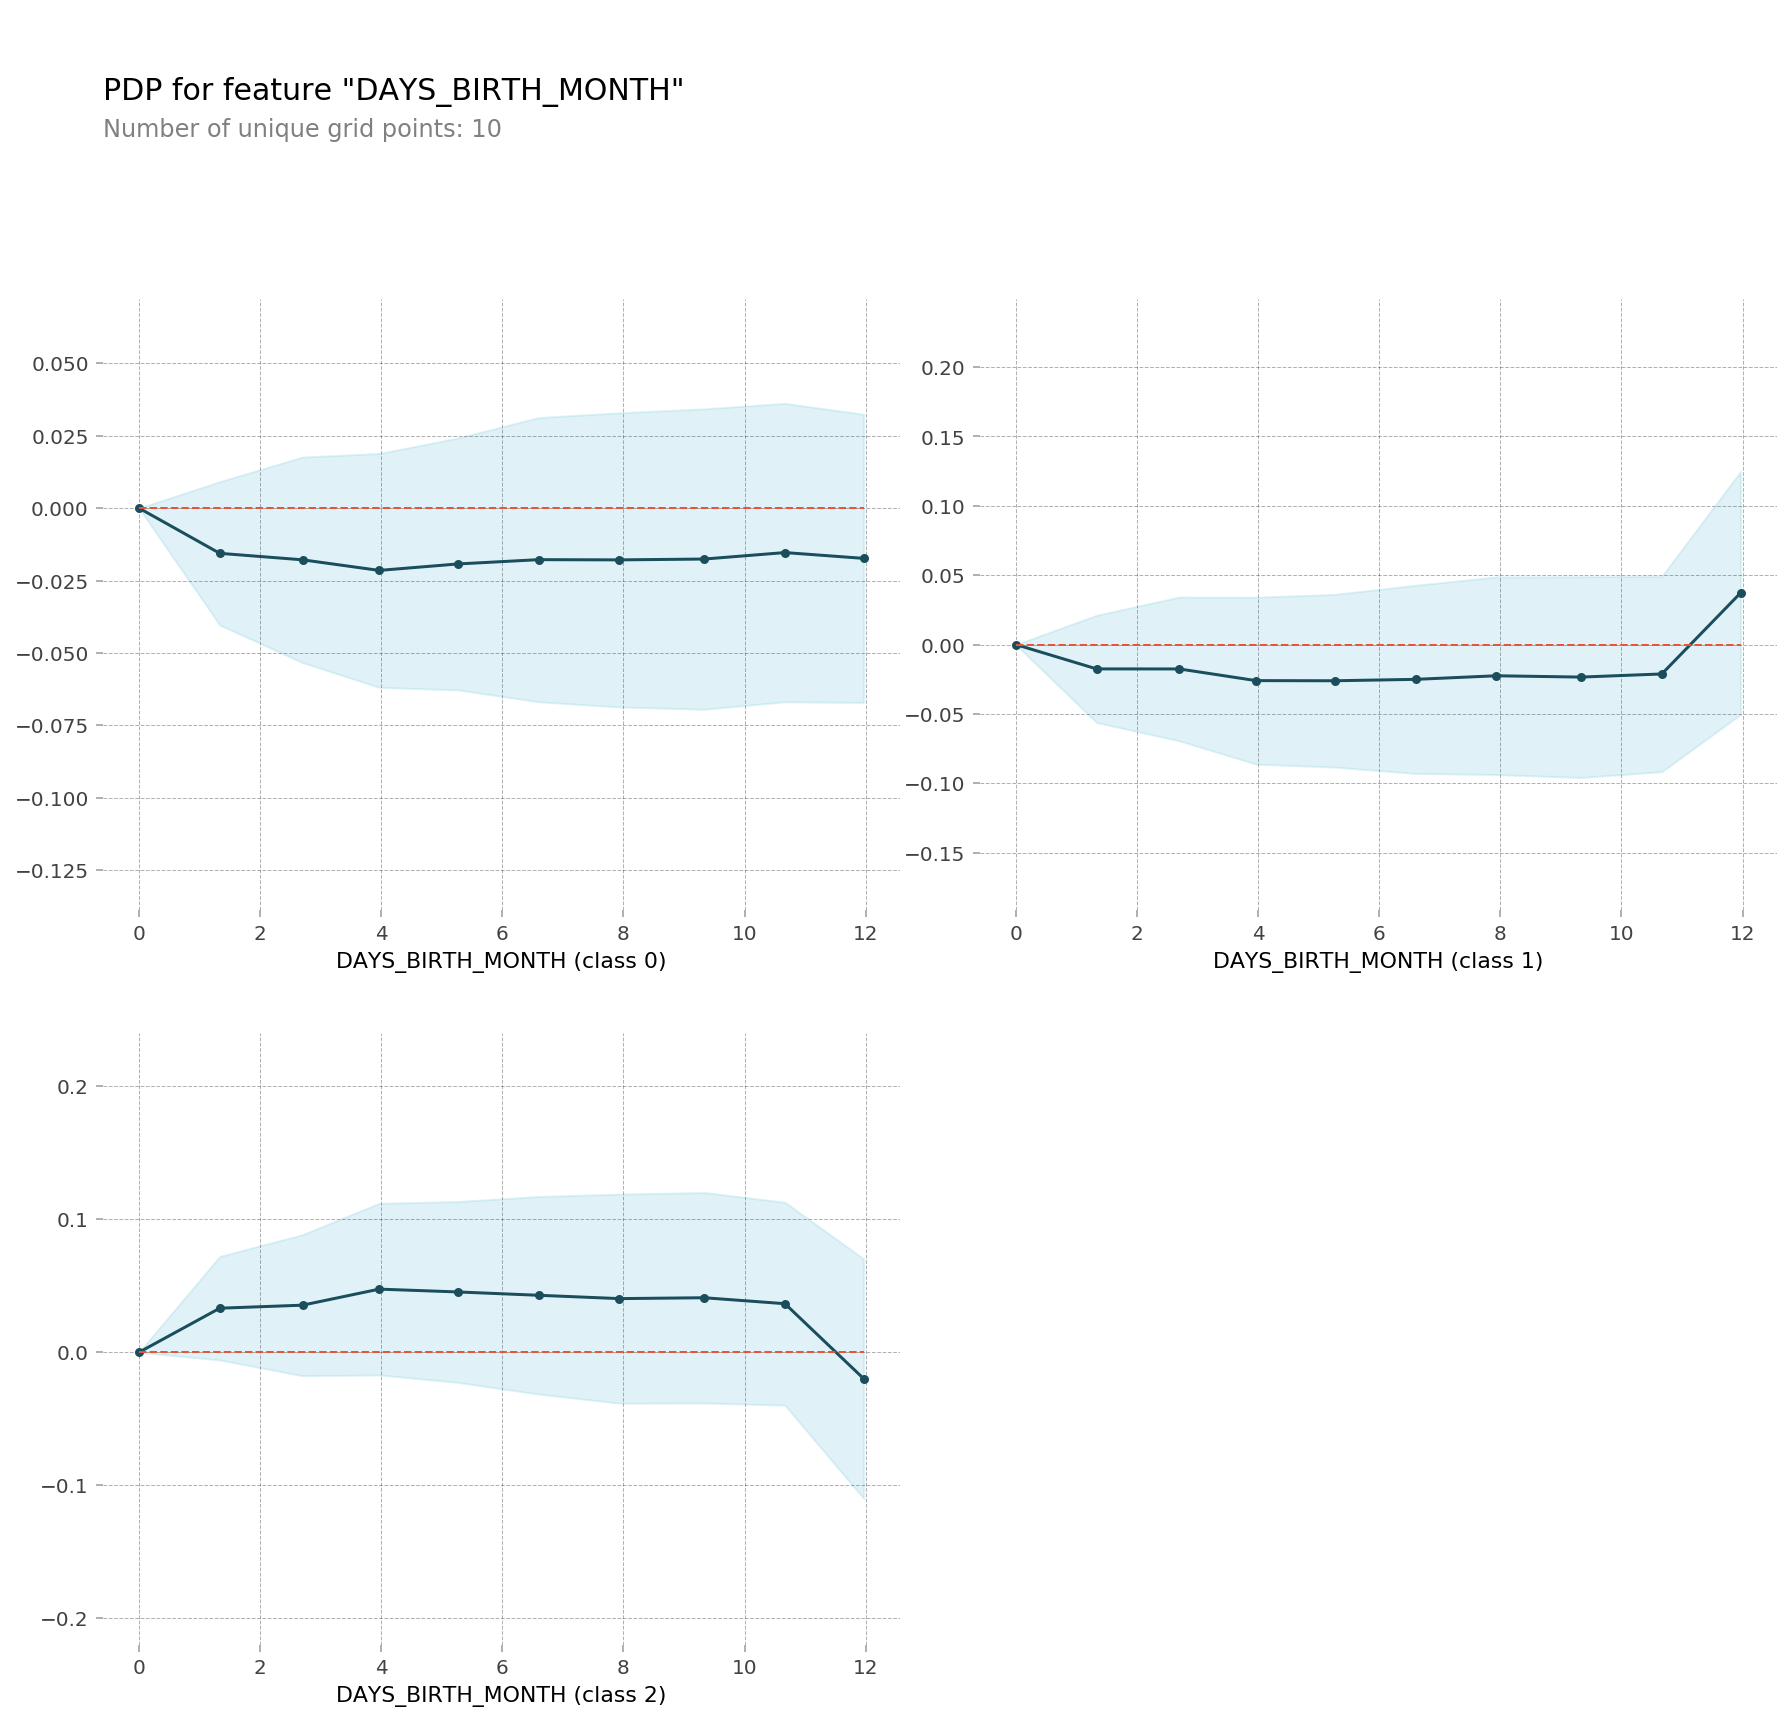

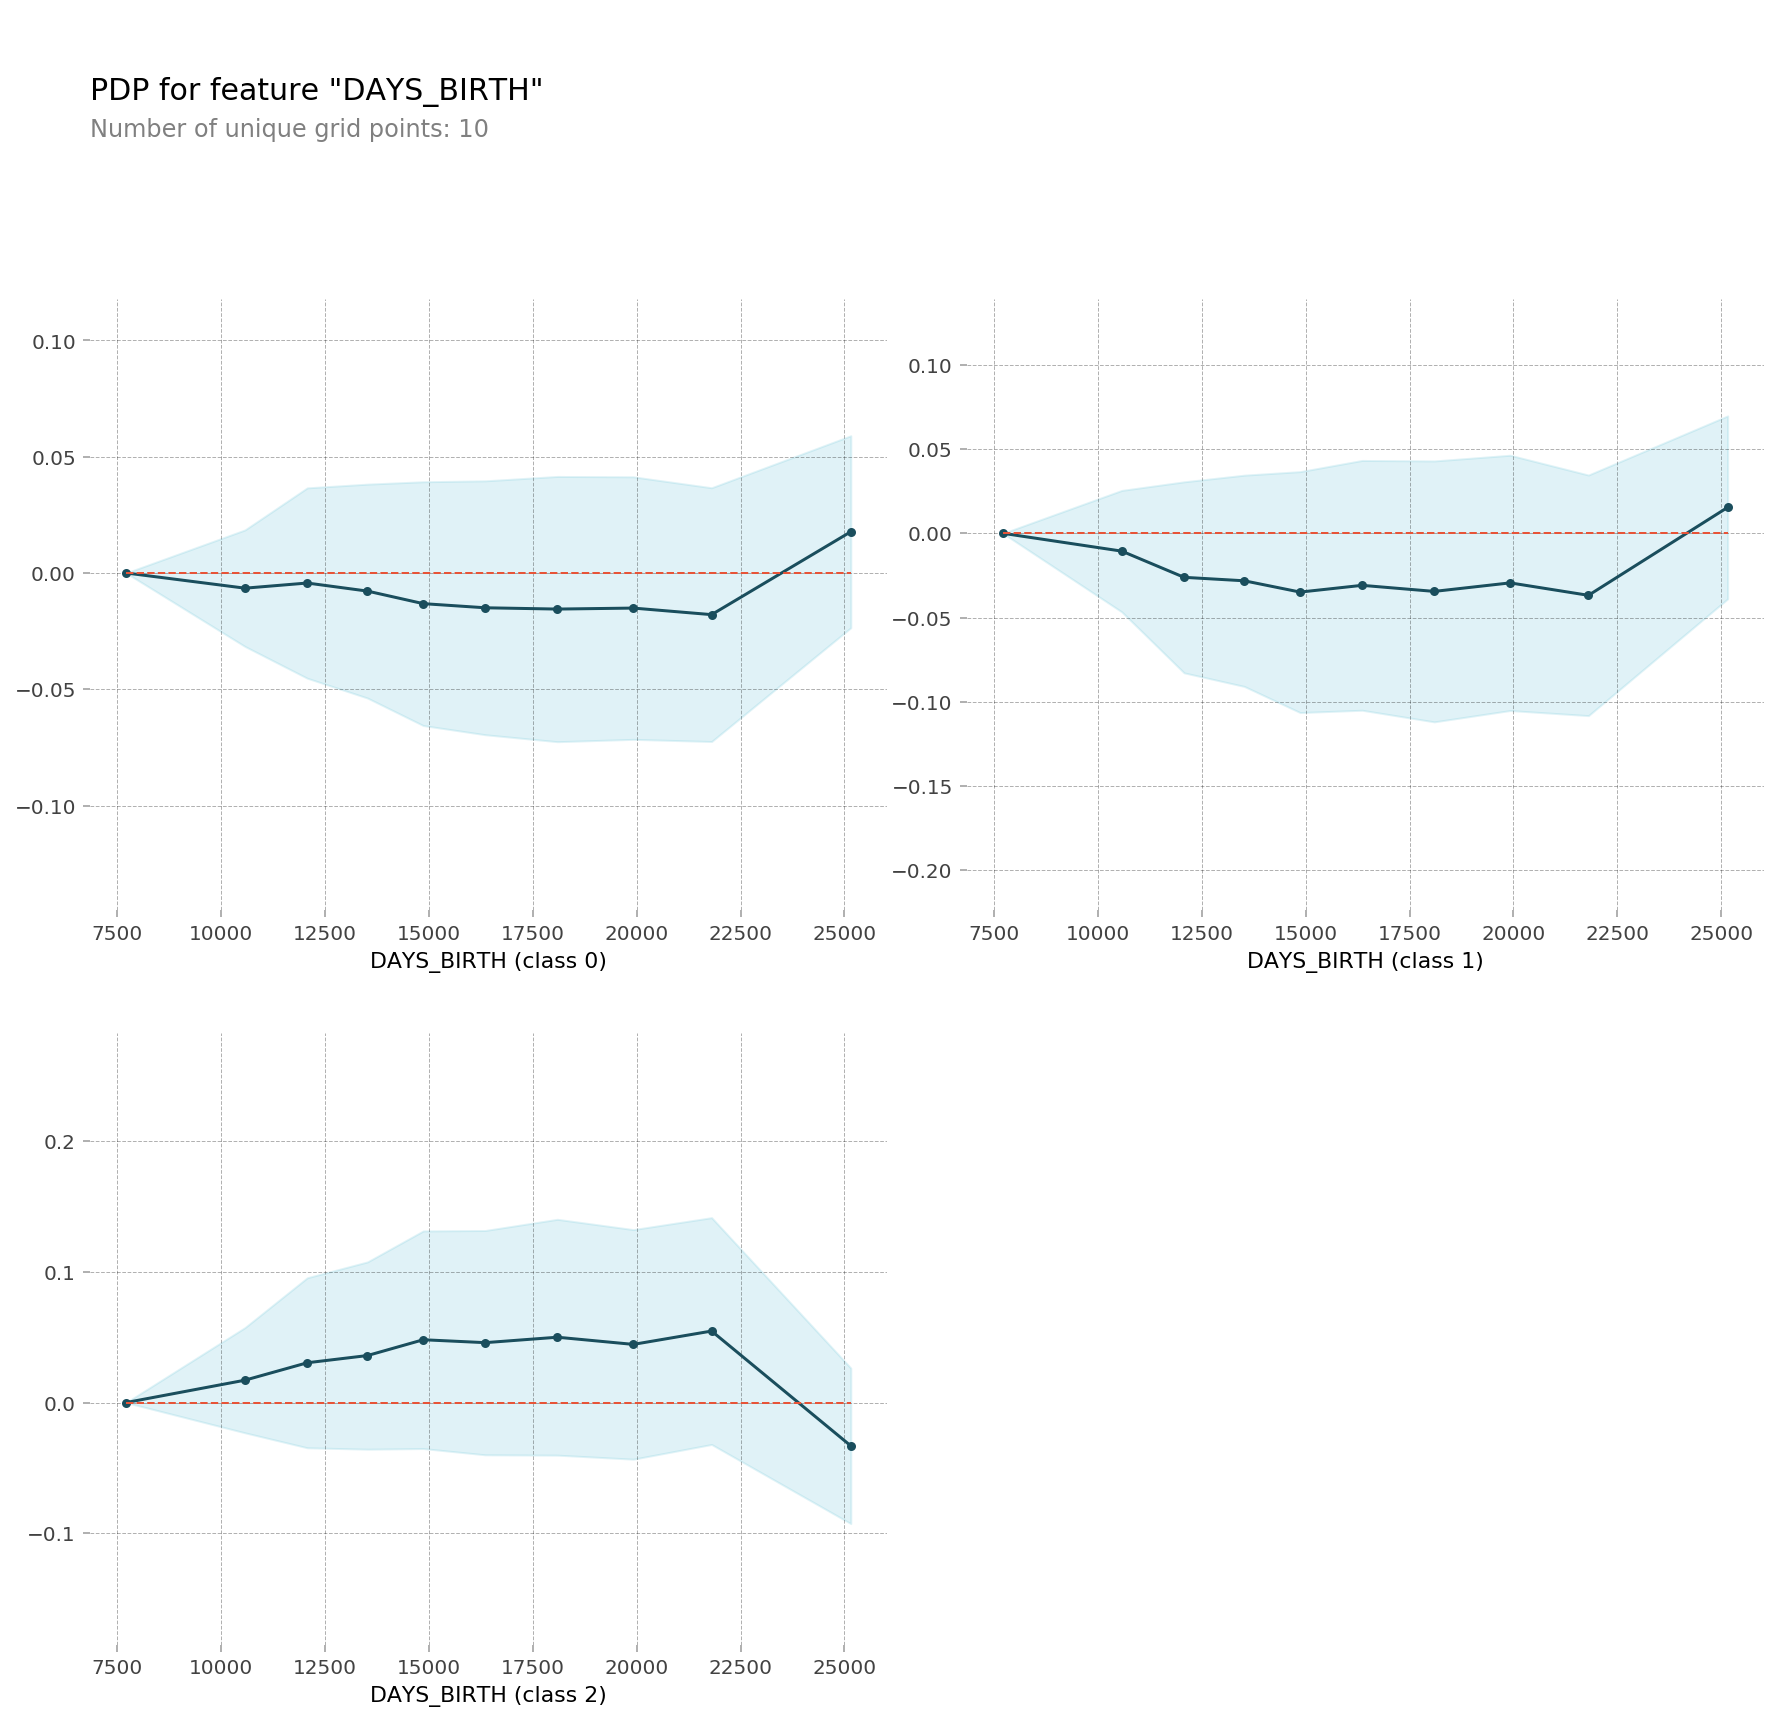

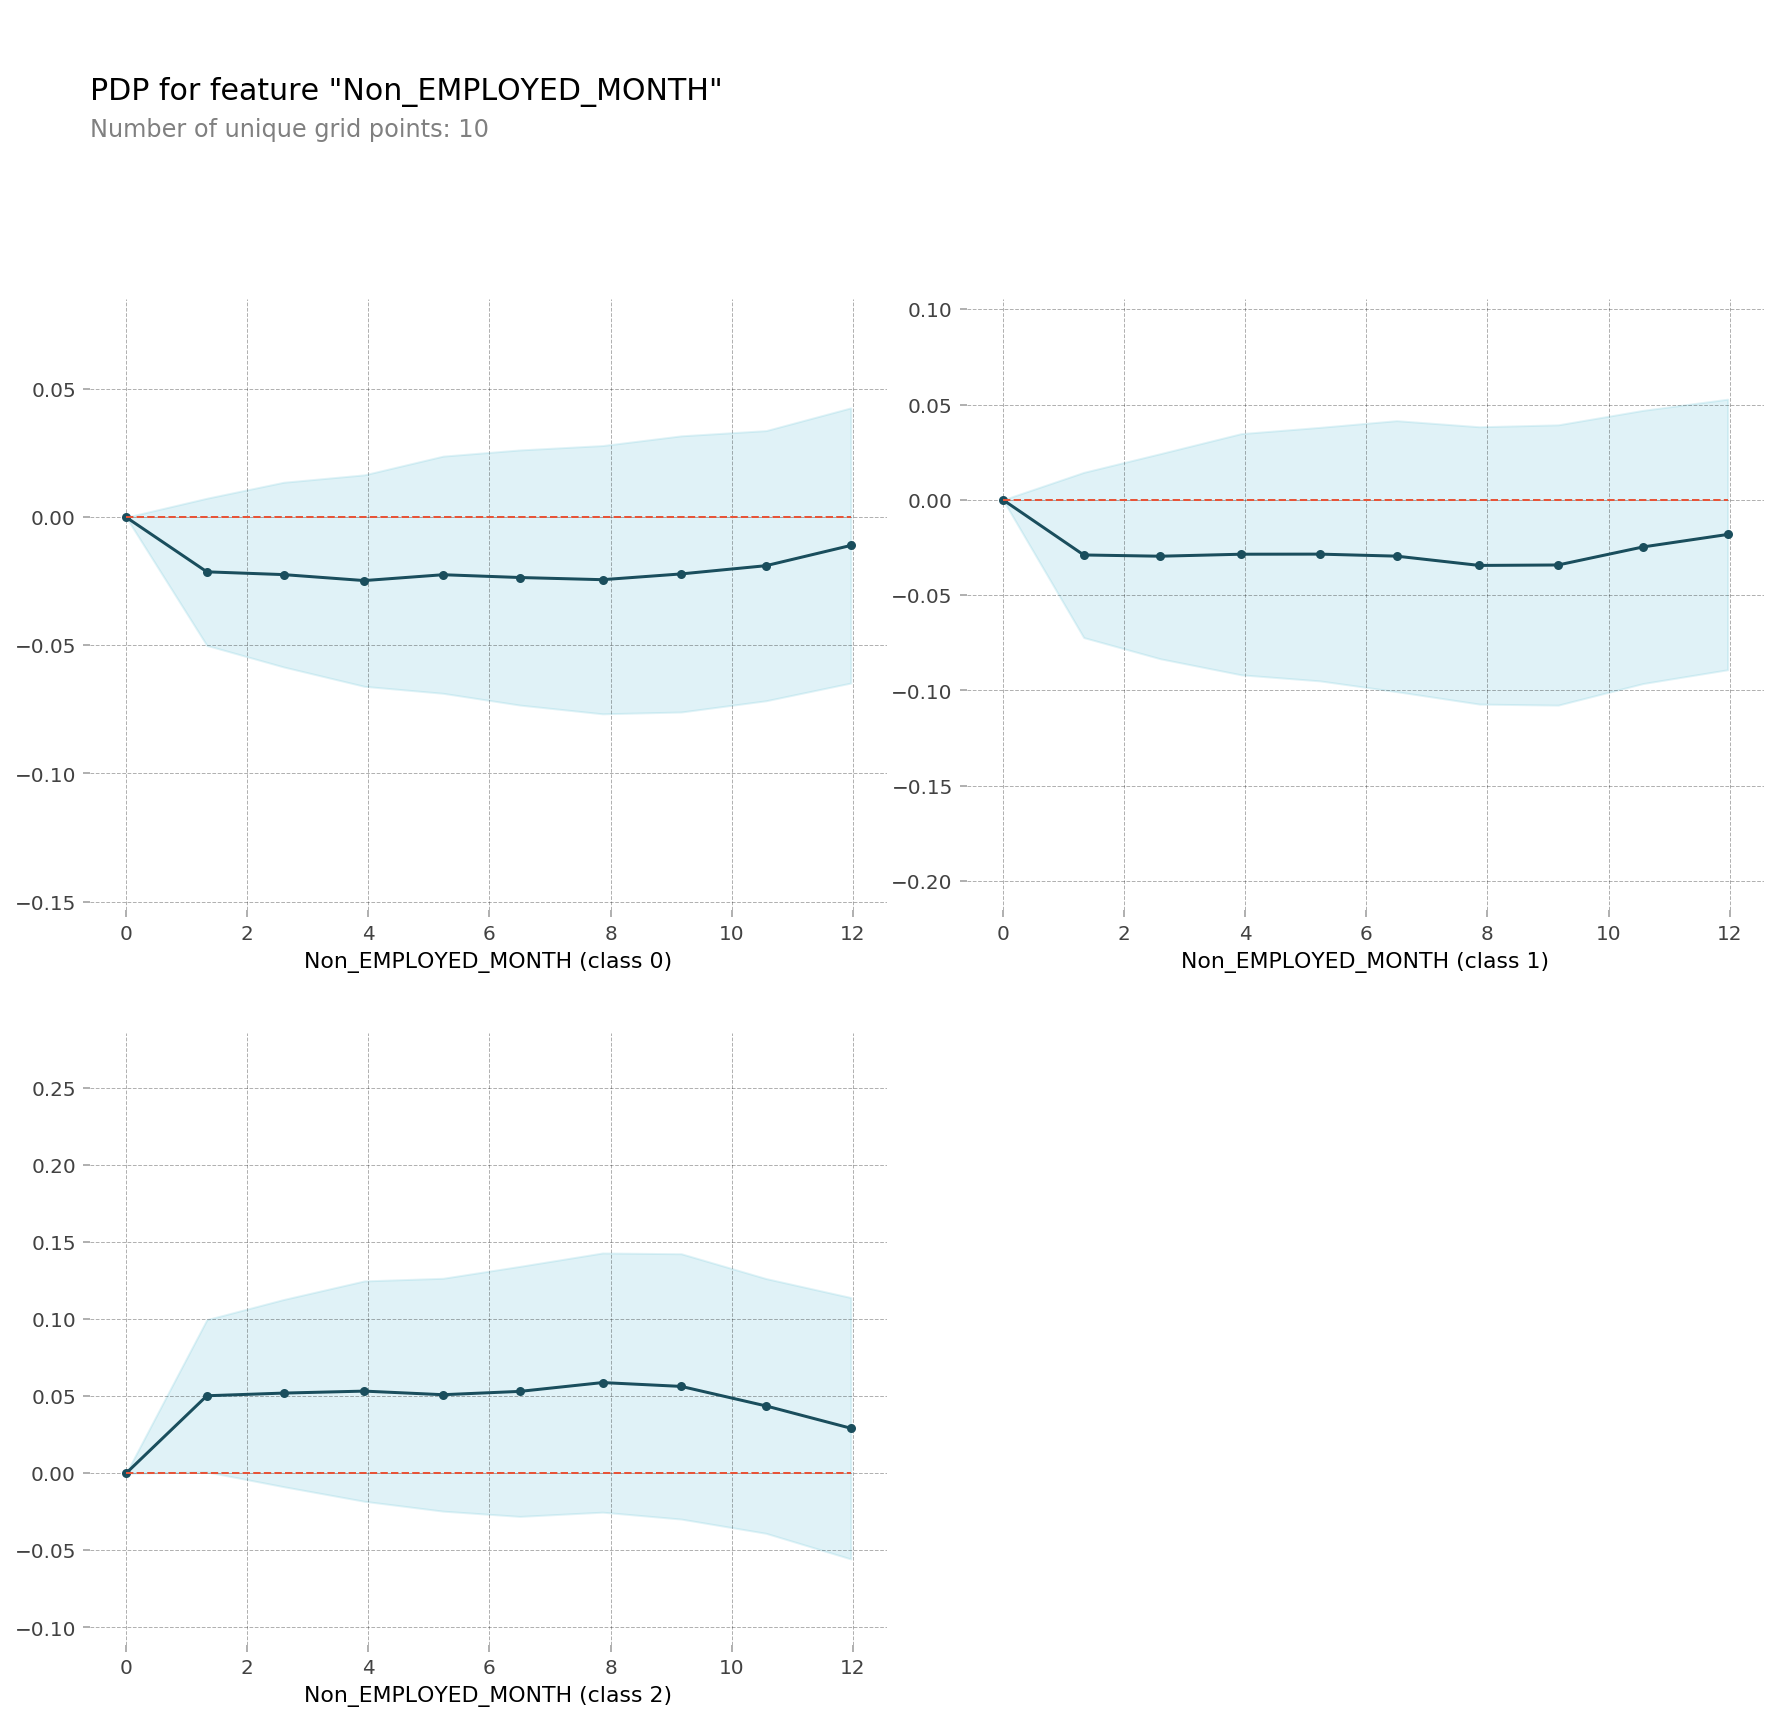

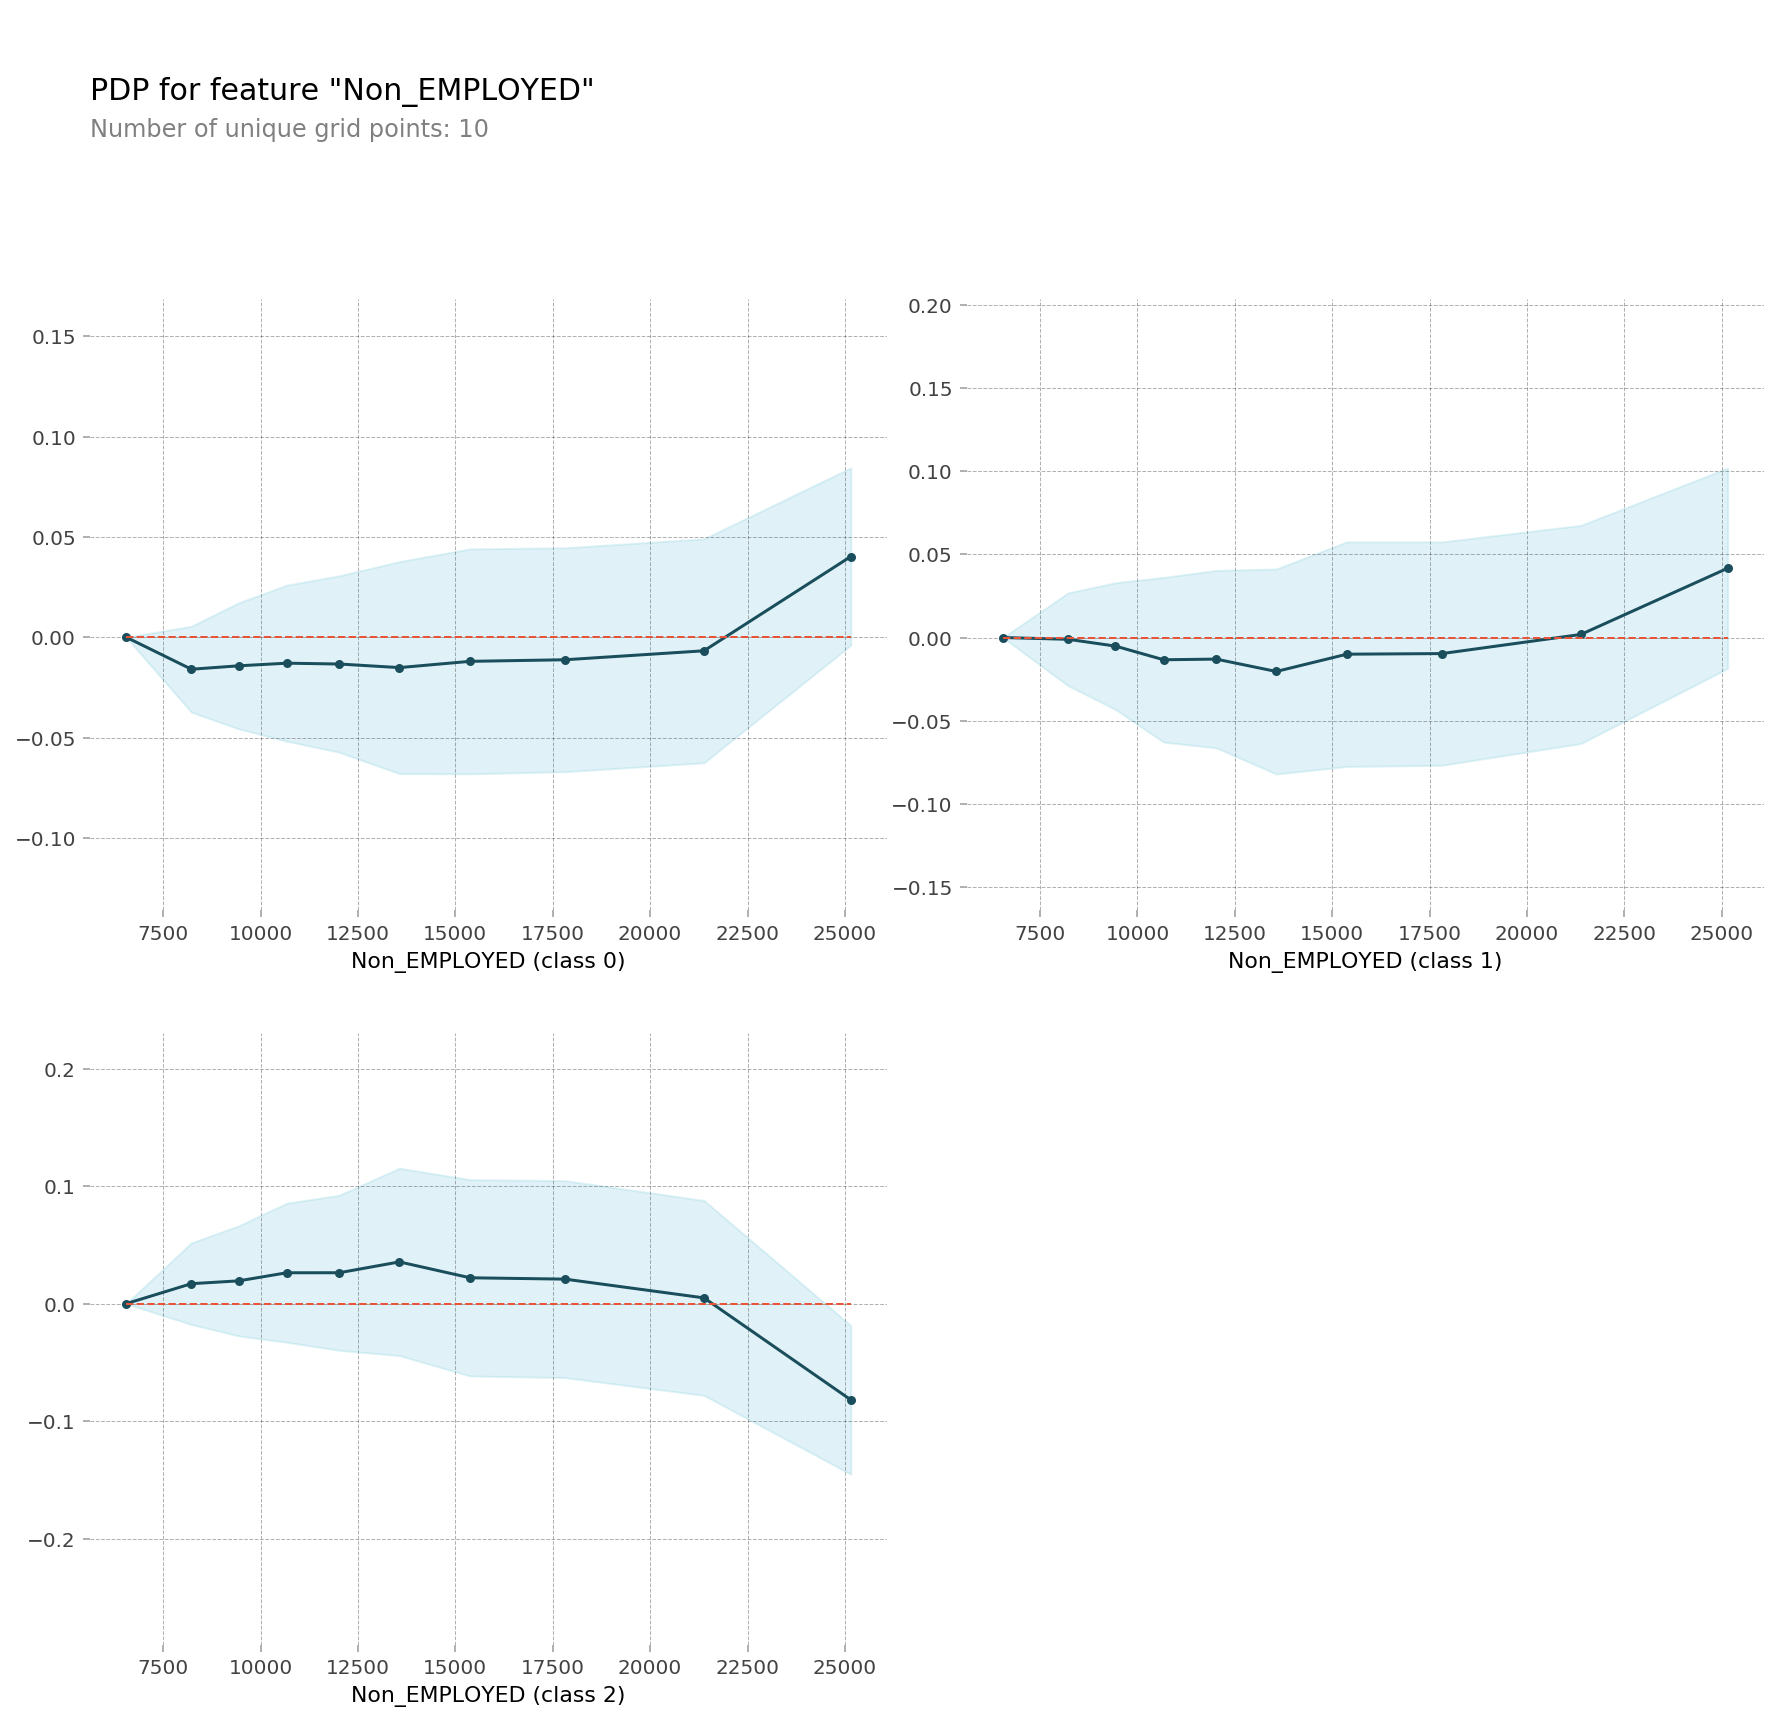

In [98]:
fe_list = ['begin_month','DAYS_BIRTH_MONTH','DAYS_BIRTH','Non_EMPLOYED_MONTH','Non_EMPLOYED']

for i in fe_list:
  feature = i

  isolated = pdp_isolate(
    model=rf_hyper, 
    dataset=X_train_1, 
    model_features=X_train_1.columns, 
    feature=feature,
    grid_type='percentile', 
    num_grid_points=10)
  
  pdp_plot(isolated, feature_name=feature);